In [1]:
import jax
import jax.numpy as jnp
import surrojax_gp
import approx_post
import oed_toolbox
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

In [2]:
prng = jax.random.PRNGKey(42)

# Joint Samples

As a 'sanity check' on our model, let's first draw some $(\theta, y)$ samples from the joint distribution for different $d$ values:

Load our previously trained model from Notebook \[1\]

In [3]:
beam_gp = surrojax_gp.load_gp('nonlinear_beam_gp.json')

Let's define our prior and noise covariance:

In [4]:
noise_cov = 0.005*jnp.identity(1)
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
joint = oed_toolbox.distributions.Joint.from_prior_and_likelihood(prior, likelihood)

In [5]:
samples_per_d = 100
d_amortise = []
y_amortise = []
for d in jnp.linspace(0,1,10):
    samples = joint.sample(d,samples_per_d)
    y = beam_model.predict(samples['theta'], d)
    d_amortise.append(samples['d'])
    y_amortise.append(y)

KeyError: 'd'

<AxesSubplot:>

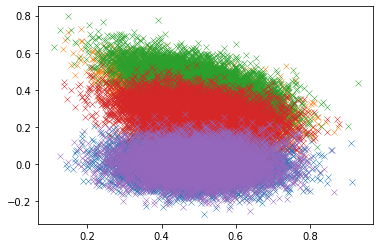

In [5]:
d = 1.0
joint_samples = joint.sample(d,10000)
sns.scatterplot(x=joint_samples['theta'].squeeze(), y=joint_samples['y'].squeeze(), marker='x')
d = 0.75
joint_samples = joint.sample(d,10000)
sns.scatterplot(x=joint_samples['theta'].squeeze(), y=joint_samples['y'].squeeze(), marker='x')
d = 0.5
joint_samples = joint.sample(d,10000)
sns.scatterplot(x=joint_samples['theta'].squeeze(), y=joint_samples['y'].squeeze(), marker='x')
d = 0.25
joint_samples = joint.sample(d,10000)
sns.scatterplot(x=joint_samples['theta'].squeeze(), y=joint_samples['y'].squeeze(), marker='x')
d = 0.0
joint_samples = joint.sample(d,10000)
sns.scatterplot(x=joint_samples['theta'].squeeze(), y=joint_samples['y'].squeeze(), marker='x')

In [6]:
model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
true_posterior = computation_helpers.construct_true_posterior(model, noise_cov, prior_mean, prior_cov)

Create Laplace approximation posterior:

In [7]:
model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
minimizer = oed_toolbox.optim.gradient_descent_for_map(lr=1e-4)
laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(model, minimizer, noise_cov, prior_mean, prior_cov)

In [72]:
max_iter = 200
num_samples = 1000
y_lims = (0.0, 1.0)
d_lims = (0.0, 1.0)
num_y_pts = num_d_pts = 10
num_layers = 5
nn_width = 10
activation = 'tanh'
phi_lims = {'mean': {'lb':-0.5, 'ub':1.5}, 'log_chol_diag': {'lb':-3, 'ub':-2.}} #, }
reverse_approx, reverse_loss = \
computation_helpers.train_nn_amortised_normal_approx(beam_gp, y_lims, d_lims, num_y_pts, num_d_pts, 
                                                     noise_cov, prior_mean, prior_cov, 
                                                     prng, num_samples, max_iter,
                                                     num_layers, nn_width, activation, phi_lims,
                                                     loss_name='reverse_kl', 
                                                     use_reparameterisation=True)

Loss = 17.890928268432617, Params = Jaxtainer({'W_0': DeviceArray([[-0.85361445,  0.10228678, -0.26648486, -0.9732463 ,
              -0.257548  ,  2.0651658 ,  1.8293415 , -0.28121525,
              -0.40304098,  0.02247722],
             [-0.19696254,  0.14237425,  0.36207777, -1.0551792 ,
               0.814806  , -1.4481947 ,  0.03363504,  0.82011616,
              -0.5448952 ,  0.3766396 ]], dtype=float32), 'b_0': DeviceArray([ 0.1       ,  0.09999999,  0.1       ,  0.1       ,
             -0.09999998, -0.1       ,  0.1       , -0.1       ,
             -0.1       ,  0.1       ], dtype=float32), 'W_1': DeviceArray([[-0.5503296 ,  0.15684679, -0.6928241 ,  0.6630895 ,
               0.07340518,  0.08788153,  0.27850816,  0.47573107,
              -0.09239852,  0.44840443],
             [ 0.2808062 ,  0.6939169 ,  0.2636167 ,  0.7210491 ,
              -0.2866405 , -0.00864759,  0.09292676,  0.4357826 ,
              -0.02529968,  0.2752719 ],
             [-0.73095316, -0.5640517

Loss = 20.257125854492188, Params = Jaxtainer({'W_0': DeviceArray([[-0.93279505,  0.02157685, -0.24828623, -1.0665004 ,
              -0.30036756,  2.0692873 ,  1.7527423 , -0.32786396,
              -0.30552176,  0.04073517],
             [-0.09684384,  0.06751374,  0.43570018, -1.010245  ,
               0.7455896 , -1.5183403 , -0.01464876,  0.7451505 ,
              -0.49289772,  0.45140788]], dtype=float32), 'b_0': DeviceArray([ 0.19476911,  0.02644307,  0.17982787,  0.12536798,
             -0.1749224 , -0.17873347,  0.05408872, -0.179161  ,
             -0.06616887,  0.18138024], dtype=float32), 'W_1': DeviceArray([[-0.649757  ,  0.22646818, -0.62001437,  0.5815712 ,
              -0.00876605,  0.03976399,  0.36753303,  0.57306045,
              -0.17594048,  0.543141  ],
             [ 0.38046408,  0.6217569 ,  0.18916035,  0.8017906 ,
              -0.20655563,  0.05462962,  0.00894714,  0.369093  ,
               0.05510563,  0.18598671],
             [-0.6379286 , -0.6412493

Loss = 32.80378723144531, Params = Jaxtainer({'W_0': DeviceArray([[-0.9239821 , -0.0369087 , -0.27989417, -1.1558107 ,
              -0.3527055 ,  2.126722  ,  1.6715512 , -0.34142303,
              -0.20698157,  0.0142407 ],
             [-0.00423092,  0.00846828,  0.49382073, -0.94732666,
               0.6869951 , -1.5770319 , -0.06906005,  0.68757886,
              -0.42288905,  0.50322086]], dtype=float32), 'b_0': DeviceArray([ 2.8979975e-01, -3.0251194e-02,  2.2947134e-01,
              1.6702694e-01, -2.4314192e-01, -2.3352247e-01,
              9.8049641e-05, -2.3505303e-01, -2.9650703e-03,
              2.2613297e-01], dtype=float32), 'W_1': DeviceArray([[-0.6155357 ,  0.2752025 , -0.5714171 ,  0.5172192 ,
              -0.04381543,  0.03879216,  0.42189008,  0.66219413,
              -0.24828729,  0.62145036],
             [ 0.3933733 ,  0.5667268 ,  0.1302592 ,  0.86296654,
              -0.1498205 ,  0.09944852, -0.05058179,  0.30486032,
               0.11715159,  0.116422

Loss = 17.925132751464844, Params = Jaxtainer({'W_0': DeviceArray([[-0.96205544, -0.08339131, -0.32452315, -1.2473898 ,
              -0.40522718,  2.2003195 ,  1.6060655 , -0.34399295,
              -0.11531889, -0.02413387],
             [ 0.06297171, -0.03938968,  0.5297338 , -0.9169059 ,
               0.63224226, -1.5977933 , -0.11616941,  0.6438659 ,
              -0.3498367 ,  0.5346606 ]], dtype=float32), 'b_0': DeviceArray([ 0.35648635, -0.07575402,  0.25672242,  0.18262027,
             -0.30513152, -0.24536844, -0.04613763, -0.27703717,
              0.06048507,  0.250816  ], dtype=float32), 'W_1': DeviceArray([[-0.58875054,  0.31517115, -0.5383326 ,  0.46027675,
              -0.07022755,  0.05019614,  0.4657638 ,  0.7442351 ,
              -0.31252587,  0.68679494],
             [ 0.40918925,  0.52155936,  0.08083154,  0.9116075 ,
              -0.10265903,  0.13871118, -0.09947215,  0.25787452,
               0.16699252,  0.0598701 ],
             [-0.728176  , -0.7482824

Loss = 22.203031539916992, Params = Jaxtainer({'W_0': DeviceArray([[-0.9178389 , -0.13550657, -0.33039433, -1.2956522 ,
              -0.42638162,  2.2193916 ,  1.5436546 , -0.3498273 ,
              -0.04581026, -0.04109329],
             [ 0.14152578, -0.08846609,  0.57851905, -0.85979843,
               0.60466254, -1.6463225 , -0.1527633 ,  0.6056272 ,
              -0.3142928 ,  0.57575226]], dtype=float32), 'b_0': DeviceArray([ 0.43441314, -0.12248414,  0.29809642,  0.20937602,
             -0.33798325, -0.28348893, -0.08102265, -0.31334352,
              0.0951356 ,  0.28346738], dtype=float32), 'W_1': DeviceArray([[-0.5303418 ,  0.34817666, -0.49672377,  0.4363332 ,
              -0.09357712,  0.06131119,  0.50418156,  0.71059716,
              -0.36077595,  0.7398773 ],
             [ 0.44530928,  0.48335552,  0.05214818,  0.9758526 ,
              -0.06643473,  0.17208101, -0.13734964,  0.19838986,
               0.21434537,  0.00626491],
             [-0.734557  , -0.7895474

Loss = 16.084991455078125, Params = Jaxtainer({'W_0': DeviceArray([[-0.90054166, -0.17512986, -0.35380998, -1.3547963 ,
              -0.43374196,  2.2635558 ,  1.5042146 , -0.34649193,
               0.01777477, -0.06847634],
             [ 0.1813609 , -0.12776479,  0.60208684, -0.8391042 ,
               0.59007007, -1.6549462 , -0.17362538,  0.57872576,
              -0.27700356,  0.60001415]], dtype=float32), 'b_0': DeviceArray([ 0.4827518 , -0.16059572,  0.3203015 ,  0.2160415 ,
             -0.3584897 , -0.2890911 , -0.10304225, -0.33995694,
              0.12695973,  0.30385065], dtype=float32), 'W_1': DeviceArray([[-0.50952446,  0.3764679 , -0.4634528 ,  0.40955928,
              -0.11311341,  0.07659473,  0.5374574 ,  0.68234867,
              -0.40452325,  0.7837527 ],
             [ 0.39905187,  0.4506831 ,  0.02304026,  1.0271516 ,
              -0.03622406,  0.21226662, -0.16969752,  0.13957508,
               0.24962299, -0.04777576],
             [-0.6861986 , -0.8256761

Loss = 17.57318878173828, Params = Jaxtainer({'W_0': DeviceArray([[-0.88495666, -0.20996922, -0.37387934, -1.4119836 ,
              -0.43966392,  2.2965498 ,  1.4697163 , -0.34387773,
               0.07176821, -0.09193492],
             [ 0.219681  , -0.16176037,  0.62422645, -0.82786095,
               0.576898  , -1.6688532 , -0.19469424,  0.55435485,
              -0.24564318,  0.62181896]], dtype=float32), 'b_0': DeviceArray([ 0.52680016, -0.19327551,  0.3394746 ,  0.21112755,
             -0.37685922, -0.2948401 , -0.12453623, -0.363673  ,
              0.15567237,  0.3205999 ], dtype=float32), 'W_1': DeviceArray([[-0.5030313 ,  0.40147036, -0.43436363,  0.39250433,
              -0.13148615,  0.08878814,  0.5666769 ,  0.6577621 ,
              -0.44221202,  0.8206394 ],
             [ 0.3626699 ,  0.4220298 , -0.00234625,  1.069968  ,
              -0.00904743,  0.24580124, -0.19833887,  0.08985328,
               0.28101456, -0.09421169],
             [-0.6524596 , -0.85680443

Loss = 18.02444839477539, Params = Jaxtainer({'W_0': DeviceArray([[-0.86932874, -0.2410365 , -0.3904399 , -1.4642096 ,
              -0.4454058 ,  2.3229733 ,  1.4376159 , -0.3421208 ,
               0.11902729, -0.11225253],
             [ 0.25774136, -0.19157803,  0.6453276 , -0.8167925 ,
               0.56406295, -1.6846024 , -0.21729201,  0.53197104,
              -0.21631218,  0.6412269 ]], dtype=float32), 'b_0': DeviceArray([ 0.5689874 , -0.22187878,  0.35706943,  0.20132016,
             -0.39432377, -0.30016962, -0.14650217, -0.38525796,
              0.18322387,  0.3345714 ], dtype=float32), 'W_1': DeviceArray([[-0.5094038 ,  0.42373344, -0.40864217,  0.38183275,
              -0.14868192,  0.09926816,  0.5931178 ,  0.63542634,
              -0.47536182,  0.85194606],
             [ 0.34268594,  0.39671126, -0.02457405,  1.1050962 ,
               0.01563554,  0.27435407, -0.22460577,  0.04568999,
               0.309473  , -0.13323566],
             [-0.6349118 , -0.8839499 

Loss = 16.462526321411133, Params = Jaxtainer({'W_0': DeviceArray([[-0.85613453, -0.26842368, -0.40655705, -1.513014  ,
              -0.45100462,  2.351146  ,  1.4093149 , -0.3404677 ,
               0.16248402, -0.13188307],
             [ 0.2911812 , -0.21785632,  0.66297424, -0.8090605 ,
               0.5522276 , -1.6943681 , -0.23781614,  0.5120921 ,
              -0.18708737,  0.6571243 ]], dtype=float32), 'b_0': DeviceArray([ 0.60646665, -0.24707258,  0.37162307,  0.19067886,
             -0.41046873, -0.30047646, -0.16681772, -0.40449265,
              0.21021083,  0.34565577], dtype=float32), 'W_1': DeviceArray([[-0.5178419 ,  0.44358018, -0.38576633,  0.37369782,
              -0.16428256,  0.10836242,  0.61695546,  0.61512446,
              -0.5046967 ,  0.8795423 ],
             [ 0.3223998 ,  0.37417346, -0.04454195,  1.132929  ,
               0.03776255,  0.30252114, -0.24827889,  0.0061155 ,
               0.33382207, -0.16920133],
             [-0.6187014 , -0.9079541

Loss = 15.686298370361328, Params = Jaxtainer({'W_0': DeviceArray([[-0.8459596 , -0.292478  , -0.42292342, -1.5580747 ,
              -0.45651585,  2.3834774 ,  1.3855742 , -0.3387994 ,
               0.2029288 , -0.15129527],
             [ 0.31823856, -0.24102469,  0.67684865, -0.8055453 ,
               0.5415457 , -1.6952975 , -0.25435314,  0.49462602,
              -0.15893082,  0.6697183 ]], dtype=float32), 'b_0': DeviceArray([ 0.6385468 , -0.2693476 ,  0.38336962,  0.17999975,
             -0.42485312, -0.2951616 , -0.1839145 , -0.4214987 ,
              0.23525114,  0.3545718 ], dtype=float32), 'W_1': DeviceArray([[-5.2170604e-01,  4.6128875e-01, -3.6533922e-01,
               3.6683133e-01, -1.7810790e-01,  1.1600572e-01,
               6.3796365e-01,  5.9784210e-01, -5.3058118e-01,
               9.0460539e-01],
             [ 2.9555556e-01,  3.5400096e-01, -6.2629275e-02,
               1.1537182e+00,  5.7338975e-02,  3.3190501e-01,
              -2.6877752e-01, -3.0736931e-

Loss = 15.612750053405762, Params = Jaxtainer({'W_0': DeviceArray([[-0.8383303 , -0.31319353, -0.43928143, -1.5973697 ,
              -0.46015322,  2.4188411 ,  1.3667604 , -0.336627  ,
               0.24097085, -0.16981019],
             [ 0.33842692, -0.2612219 ,  0.68709344, -0.81222564,
               0.53314525, -1.6864446 , -0.26519   ,  0.47968817,
              -0.13158138,  0.67946523]], dtype=float32), 'b_0': DeviceArray([ 0.66678464, -0.28872582,  0.3936723 ,  0.18165366,
             -0.43592522, -0.28830975, -0.1986238 , -0.43632466,
              0.25785133,  0.3630145 ], dtype=float32), 'W_1': DeviceArray([[-0.517726  ,  0.47719008, -0.34744978,  0.36181492,
              -0.19047518,  0.12319393,  0.6566173 ,  0.58272135,
              -0.55347466,  0.92757976],
             [ 0.2572316 ,  0.3357842 , -0.07845371,  1.1668088 ,
               0.07451428,  0.36105236, -0.28684852, -0.06515098,
               0.3691502 , -0.23942262],
             [-0.57123446, -0.9486337

Loss = 16.064746856689453, Params = Jaxtainer({'W_0': DeviceArray([[-0.83262897, -0.33101648, -0.4554436 , -1.6311088 ,
              -0.4634713 ,  2.456626  ,  1.3510739 , -0.33433837,
               0.2769969 , -0.18751755],
             [ 0.35284954, -0.27883846,  0.69492877, -0.8238398 ,
               0.52584684, -1.6701635 , -0.27184936,  0.4666888 ,
              -0.10650232,  0.68729067]], dtype=float32), 'b_0': DeviceArray([ 0.6916227 , -0.30552712,  0.40204862,  0.18641743,
             -0.44551456, -0.27706692, -0.21140374, -0.4494272 ,
              0.27970603,  0.37011597], dtype=float32), 'W_1': DeviceArray([[-0.51118654,  0.49161932, -0.33138654,  0.36003217,
              -0.20184046,  0.12888855,  0.6729428 ,  0.56997794,
              -0.5731663 ,  0.94863075],
             [ 0.21649818,  0.31904688, -0.09281445,  1.1715906 ,
               0.09049615,  0.39029485, -0.30224428, -0.09670695,
               0.38022774, -0.27352467],
             [-0.5424269 , -0.9658226

Loss = 15.925920486450195, Params = Jaxtainer({'W_0': DeviceArray([[-0.8322198 , -0.34640744, -0.4735548 , -1.6683185 ,
              -0.46822646,  2.5052621 ,  1.3428935 , -0.33163953,
               0.31370962, -0.20645735],
             [ 0.35779545, -0.29415056,  0.6983544 , -0.84958243,
               0.5178953 , -1.6373127 , -0.27081218,  0.4556092 ,
              -0.07805088,  0.69144064]], dtype=float32), 'b_0': DeviceArray([ 0.7101592 , -0.320177  ,  0.4061846 ,  0.18630275,
             -0.45544586, -0.25015566, -0.22005776, -0.46084228,
              0.30569306,  0.3739343 ], dtype=float32), 'W_1': DeviceArray([[-0.49026105,  0.5048148 , -0.316772  ,  0.36396995,
              -0.21180111,  0.1292975 ,  0.68724614,  0.55920553,
              -0.5878552 ,  0.97156996],
             [ 0.16225298,  0.30378756, -0.10605184,  1.16349   ,
               0.10406147,  0.42742229, -0.3147028 , -0.12679876,
               0.38245556, -0.31366113],
             [-0.5042947 , -0.9812869

Loss = 15.681769371032715, Params = Jaxtainer({'W_0': DeviceArray([[-0.83480746, -0.3605027 , -0.49002624, -1.694554  ,
              -0.47353965,  2.5540187 ,  1.3355201 , -0.32896364,
               0.34824467, -0.22366571],
             [ 0.3593617 , -0.30801007,  0.70035183, -0.8730621 ,
               0.50918823, -1.600146  , -0.26801407,  0.4457233 ,
              -0.04748986,  0.69420886]], dtype=float32), 'b_0': DeviceArray([ 0.72798085, -0.33327517,  0.4098619 ,  0.20658217,
             -0.46513116, -0.22383274, -0.23080048, -0.4711876 ,
              0.3337618 ,  0.37738556], dtype=float32), 'W_1': DeviceArray([[-0.46956712,  0.51722735, -0.30375358,  0.3695215 ,
              -0.22156934,  0.12954773,  0.701401  ,  0.5473075 ,
              -0.60063505,  0.99415076],
             [ 0.10811821,  0.29015672, -0.11753358,  1.1542041 ,
               0.11630404,  0.46337888, -0.32736644, -0.15192953,
               0.38236296, -0.3532691 ],
             [-0.46672755, -0.9949882

Loss = 15.68718147277832, Params = Jaxtainer({'W_0': DeviceArray([[-0.8481752 , -0.37398538, -0.5054964 , -1.7325268 ,
              -0.47940147,  2.609507  ,  1.3388261 , -0.3251502 ,
               0.37963125, -0.23943666],
             [ 0.34991089, -0.32090536,  0.6993958 , -0.91829073,
               0.49895132, -1.5512763 , -0.25603998,  0.43768162,
              -0.01148963,  0.6946556 ]], dtype=float32), 'b_0': DeviceArray([ 0.73631936, -0.34529245,  0.41090536,  0.22199315,
             -0.47643197, -0.18405329, -0.23739494, -0.47986144,
              0.36788386,  0.3788154 ], dtype=float32), 'W_1': DeviceArray([[-0.43352568,  0.5285477 , -0.2919859 ,  0.38042295,
              -0.23040436,  0.12373435,  0.7163247 ,  0.5334159 ,
              -0.6071617 ,  1.0202905 ],
             [ 0.04216916,  0.27969995, -0.12752809,  1.1406457 ,
               0.12450801,  0.5066561 , -0.3403495 , -0.17362332,
               0.37253854, -0.39707297],
             [-0.4196143 , -1.0080926 

Loss = 16.24190330505371, Params = Jaxtainer({'W_0': DeviceArray([[-0.86199856, -0.3870909 , -0.5143656 , -1.7167996 ,
              -0.48316076,  2.6399932 ,  1.3236885 , -0.32222283,
               0.40141144, -0.25002983],
             [ 0.352473  , -0.33320764,  0.7034404 , -0.8928419 ,
               0.48961422, -1.535753  , -0.27041027,  0.42867568,
               0.01640754,  0.6976481 ]], dtype=float32), 'b_0': DeviceArray([ 0.758358  , -0.35625347,  0.41756687,  0.27263686,
             -0.48721462, -0.18539569, -0.2689234 , -0.48957503,
              0.4003797 ,  0.38265175], dtype=float32), 'W_1': DeviceArray([[-4.5252472e-01,  5.4007453e-01, -2.8157192e-01,
               3.7824067e-01, -2.4506138e-01,  1.3423416e-01,
               7.3760962e-01,  5.0780791e-01, -6.2437868e-01,
               1.0363072e+00],
             [ 3.5194587e-02,  2.7093920e-01, -1.3573295e-01,
               1.1533309e+00,  1.3859251e-01,  5.2030951e-01,
              -3.6190113e-01, -1.7484702e-0

Loss = 16.181211471557617, Params = Jaxtainer({'W_0': DeviceArray([[-0.88388926, -0.39980596, -0.51874214, -1.6959103 ,
              -0.48363832,  2.6617475 ,  1.311555  , -0.3185297 ,
               0.41253898, -0.25616565],
             [ 0.35151294, -0.34478885,  0.7096608 , -0.8608832 ,
               0.4826645 , -1.5293525 , -0.2872257 ,  0.42059627,
               0.03275638,  0.7024317 ]], dtype=float32), 'b_0': DeviceArray([ 0.7747481 , -0.36664027,  0.42604676,  0.3246414 ,
             -0.49591425, -0.19353178, -0.30063438, -0.4982986 ,
              0.4250506 ,  0.3879411 ], dtype=float32), 'W_1': DeviceArray([[-0.47563288,  0.5505315 , -0.27221474,  0.3718963 ,
              -0.25908482,  0.14691082,  0.75827146,  0.48226386,
              -0.6425905 ,  1.0491865 ],
             [ 0.03329447,  0.26564544, -0.14267582,  1.1770419 ,
               0.149685  ,  0.5272922 , -0.38137197, -0.17437847,
               0.395521  , -0.43159008],
             [-0.41525808, -1.0297723

Loss = 15.95409107208252, Params = Jaxtainer({'W_0': DeviceArray([[-0.91276306, -0.41184795, -0.5190638 , -1.6677483 ,
              -0.48119673,  2.6769385 ,  1.3027602 , -0.31397843,
               0.41578263, -0.25833225],
             [ 0.34681982, -0.35545227,  0.71740216, -0.8232684 ,
               0.47745168, -1.5277873 , -0.30494392,  0.4135925 ,
               0.04352536,  0.70841944]], dtype=float32), 'b_0': DeviceArray([ 0.78785163, -0.3761119 ,  0.43663868,  0.3834734 ,
             -0.50263625, -0.20851871, -0.3340869 , -0.5060364 ,
              0.44507757,  0.39487556], dtype=float32), 'W_1': DeviceArray([[-0.5038561 ,  0.560187  , -0.26397225,  0.36375043,
              -0.27340096,  0.16236365,  0.7792012 ,  0.45544645,
              -0.6611829 ,  1.0599772 ],
             [ 0.03642737,  0.2633443 , -0.14831765,  1.2071701 ,
               0.15886389,  0.52802354, -0.40005764, -0.1709572 ,
               0.4106589 , -0.4382034 ],
             [-0.4203517 , -1.0403336 

Loss = 15.540505409240723, Params = Jaxtainer({'W_0': DeviceArray([[-0.94781905, -0.4231442 , -0.51637524, -1.6372471 ,
              -0.47620863,  2.688942  ,  1.3002086 , -0.30861893,
               0.41274717, -0.25735205],
             [ 0.33734193, -0.36522582,  0.7257283 , -0.7843758 ,
               0.47386783, -1.5272815 , -0.31956822,  0.40772757,
               0.04922576,  0.7151729 ]], dtype=float32), 'b_0': DeviceArray([ 0.79554826, -0.38477606,  0.4483256 ,  0.4434953 ,
             -0.50734735, -0.225722  , -0.36507663, -0.5126601 ,
              0.460009  ,  0.40298194], dtype=float32), 'W_1': DeviceArray([[-0.53113604,  0.5691025 , -0.2566078 ,  0.35535464,
              -0.28711414,  0.17816584,  0.79906327,  0.42938802,
              -0.67884135,  1.0696375 ],
             [ 0.03815136,  0.26348627, -0.15293549,  1.2401654 ,
               0.16510236,  0.526287  , -0.41619906, -0.16760202,
               0.4253836 , -0.44090915],
             [-0.42505884, -1.0505861

Loss = 15.28325366973877, Params = Jaxtainer({'W_0': DeviceArray([[-0.98095554, -0.4334988 , -0.51144105, -1.5970081 ,
              -0.46996224,  2.6935675 ,  1.2927864 , -0.3035564 ,
               0.40805635, -0.25441644],
             [ 0.33291253, -0.37406066,  0.734798  , -0.7377305 ,
               0.4713353 , -1.5333239 , -0.33920205,  0.40218604,
               0.05555053,  0.72234565]], dtype=float32), 'b_0': DeviceArray([ 0.80692166, -0.3926165 ,  0.4611988 ,  0.50900066,
             -0.51058906, -0.25026315, -0.39974156, -0.51892585,
              0.47383663,  0.41191682], dtype=float32), 'W_1': DeviceArray([[-0.56179607,  0.5777592 , -0.25015092,  0.34560105,
              -0.30140397,  0.19685312,  0.8190174 ,  0.4025677 ,
              -0.6973998 ,  1.0779414 ],
             [ 0.04556474,  0.2641395 , -0.15651745,  1.2755655 ,
               0.17202975,  0.51751846, -0.43336678, -0.16040324,
               0.44317243, -0.44030106],
             [-0.43419856, -1.059513  

Loss = 15.489846229553223, Params = Jaxtainer({'W_0': DeviceArray([[-1.0107268 , -0.44294998, -0.5061928 , -1.5492843 ,
              -0.46335956,  2.694465  ,  1.2826372 , -0.29895797,
               0.40396786, -0.25093725],
             [ 0.32941142, -0.38213503,  0.74328345, -0.68904793,
               0.4697428 , -1.5407436 , -0.35799927,  0.3971795 ,
               0.06161699,  0.7293097 ]], dtype=float32), 'b_0': DeviceArray([ 0.8216562 , -0.39972162,  0.47403684,  0.57915616,
             -0.5125029 , -0.27907002, -0.4357406 , -0.52485555,
              0.48728096,  0.42105576], dtype=float32), 'W_1': DeviceArray([[-5.90135515e-01,  5.86183190e-01, -2.44604975e-01,
               3.34921271e-01, -3.15326810e-01,  2.16737717e-01,
               8.37916672e-01,  3.75563622e-01, -7.16290653e-01,
               1.08538699e+00],
             [ 5.13272397e-02,  2.64219463e-01, -1.59095332e-01,
               1.31098115e+00,  1.79048285e-01,  5.05427301e-01,
              -4.50110137e

Loss = 15.434616088867188, Params = Jaxtainer({'W_0': DeviceArray([[-1.0424465 , -0.45178765, -0.5025623 , -1.5120412 ,
              -0.45717716,  2.7003927 ,  1.280727  , -0.29432616,
               0.3997898 , -0.24827023],
             [ 0.31713158, -0.38970032,  0.74970526, -0.6551768 ,
               0.46881568, -1.5411408 , -0.36592633,  0.39318967,
               0.06291004,  0.73525023]], dtype=float32), 'b_0': DeviceArray([ 0.83060294, -0.406371  ,  0.48484093,  0.64089876,
             -0.5138231 , -0.30133164, -0.46438068, -0.52995867,
              0.49858677,  0.4290625 ], dtype=float32), 'W_1': DeviceArray([[-0.60907507,  0.5938432 , -0.23966545,  0.32508117,
              -0.32711482,  0.23301373,  0.8543249 ,  0.35268638,
              -0.732915  ,  1.0928028 ],
             [ 0.04552497,  0.26431385, -0.16113558,  1.343203  ,
               0.18310843,  0.49925724, -0.46319982, -0.1401879 ,
               0.47822928, -0.43910784],
             [-0.44056076, -1.0739325

Loss = 15.381814002990723, Params = Jaxtainer({'W_0': DeviceArray([[-1.0685284 , -0.46000558, -0.4996855 , -1.4741199 ,
              -0.45208144,  2.7047007 ,  1.2746375 , -0.2905425 ,
               0.3980627 , -0.24637161],
             [ 0.30822825, -0.3967045 ,  0.75559026, -0.6231604 ,
               0.46802783, -1.5427786 , -0.37481102,  0.38934886,
               0.06526408,  0.74055713]], dtype=float32), 'b_0': DeviceArray([ 0.8417837 , -0.4125902 ,  0.4945812 ,  0.6986288 ,
             -0.51509005, -0.3228048 , -0.492301  , -0.53487456,
              0.5102604 ,  0.43606064], dtype=float32), 'W_1': DeviceArray([[-0.6257591 ,  0.60089   , -0.23529093,  0.31554756,
              -0.33760235,  0.2480959 ,  0.86952156,  0.33324257,
              -0.7486069 ,  1.0996706 ],
             [ 0.0398677 ,  0.26377824, -0.1626775 ,  1.3734734 ,
               0.18690354,  0.49297804, -0.47655305, -0.13153428,
               0.4938135 , -0.43977198],
             [-0.43906242, -1.0799851

Loss = 15.036452293395996, Params = Jaxtainer({'W_0': DeviceArray([[-1.0905112 , -0.46760735, -0.4978778 , -1.4297729 ,
              -0.44875965,  2.7096364 ,  1.2648255 , -0.28749594,
               0.39968324, -0.24533539],
             [ 0.2987249 , -0.40316662,  0.7602432 , -0.5908801 ,
               0.46647164, -1.5417804 , -0.3826473 ,  0.385791  ,
               0.07048046,  0.744921  ]], dtype=float32), 'b_0': DeviceArray([ 0.85618716, -0.4183328 ,  0.50337195,  0.7586721 ,
             -0.5168433 , -0.34376925, -0.5213846 , -0.5397214 ,
              0.52423203,  0.4422356 ], dtype=float32), 'W_1': DeviceArray([[-0.6407872 ,  0.607567  , -0.23153912,  0.30655605,
              -0.34765288,  0.26272932,  0.88405967,  0.31435946,
              -0.7636573 ,  1.1062838 ],
             [ 0.03312911,  0.26225305, -0.16354093,  1.4010735 ,
               0.19147992,  0.4869878 , -0.49080083, -0.11760481,
               0.50883025, -0.44199607],
             [-0.4362373 , -1.0848637

Loss = 14.854985237121582, Params = Jaxtainer({'W_0': DeviceArray([[-1.1058545 , -0.47459704, -0.49620178, -1.380103  ,
              -0.44623113,  2.7105732 ,  1.2486074 , -0.2852267 ,
               0.40346667, -0.24462388],
             [ 0.29684535, -0.40904403,  0.7650401 , -0.5526632 ,
               0.46506226, -1.5454315 , -0.3953869 ,  0.3821393 ,
               0.07833486,  0.74912053]], dtype=float32), 'b_0': DeviceArray([ 0.873661  , -0.42364603,  0.5111126 ,  0.8169445 ,
             -0.51915026, -0.36486   , -0.5513121 , -0.5444423 ,
              0.5399126 ,  0.44742674], dtype=float32), 'W_1': DeviceArray([[-0.6561006 ,  0.61381376, -0.227927  ,  0.29819477,
              -0.35729918,  0.2765443 ,  0.89811623,  0.29661068,
              -0.7774937 ,  1.1124059 ],
             [ 0.03042635,  0.2603105 , -0.16456416,  1.4269373 ,
               0.1974062 ,  0.4788598 , -0.5064237 , -0.10037973,
               0.52388394, -0.443852  ],
             [-0.43600404, -1.0888833

Loss = 14.848925590515137, Params = Jaxtainer({'W_0': DeviceArray([[-1.1351291 , -0.4812961 , -0.495752  , -1.3703582 ,
              -0.44284764,  2.722795  ,  1.2561219 , -0.28185737,
               0.40128598, -0.24436016],
             [ 0.2764552 , -0.4146476 ,  0.76734793, -0.5453942 ,
               0.4638078 , -1.5376238 , -0.39109093,  0.37969136,
               0.07747847,  0.7519904 ]], dtype=float32), 'b_0': DeviceArray([ 0.8743383 , -0.42869177,  0.5172603 ,  0.8539042 ,
             -0.5207952 , -0.37492582, -0.5673991 , -0.5480858 ,
              0.54882276,  0.45182374], dtype=float32), 'W_1': DeviceArray([[-0.6643158 ,  0.61940503, -0.22473751,  0.29070315,
              -0.3648919 ,  0.28604376,  0.9094264 ,  0.28261483,
              -0.7891706 ,  1.1186508 ],
             [ 0.01445716,  0.25994873, -0.16541654,  1.4502574 ,
               0.1967843 ,  0.48208895, -0.5136633 , -0.09517265,
               0.5336141 , -0.44661745],
             [-0.42649713, -1.093411 

Loss = 14.854269981384277, Params = Jaxtainer({'W_0': DeviceArray([[-1.1693776 , -0.48758414, -0.49577716, -1.3750976 ,
              -0.43874192,  2.738337  ,  1.2733208 , -0.278155  ,
               0.39626163, -0.24418712],
             [ 0.2496911 , -0.41987407,  0.7685199 , -0.5488534 ,
               0.46291798, -1.5265921 , -0.3802645 ,  0.3777871 ,
               0.07301699,  0.7542877 ]], dtype=float32), 'b_0': DeviceArray([ 0.8677799 , -0.4333869 ,  0.52210546,  0.88083893,
             -0.52224666, -0.38018999, -0.57691216, -0.5511464 ,
              0.5551448 ,  0.45554557], dtype=float32), 'W_1': DeviceArray([[-0.6690546 ,  0.62473875, -0.22174859,  0.28391862,
              -0.37173498,  0.29334807,  0.91911036,  0.26925328,
              -0.79942334,  1.1247841 ],
             [-0.00752676,  0.26007003, -0.16640587,  1.4717551 ,
               0.19383849,  0.48959035, -0.51659733, -0.09356222,
               0.5411276 , -0.44956553],
             [-0.41270268, -1.0976121

Loss = 14.758296966552734, Params = Jaxtainer({'W_0': DeviceArray([[-1.199602  , -0.49354547, -0.49764967, -1.3776705 ,
              -0.437792  ,  2.7562447 ,  1.2856104 , -0.27526817,
               0.39587578, -0.24555735],
             [ 0.22365536, -0.42473397,  0.7680937 , -0.5536319 ,
               0.46006885, -1.5130284 , -0.37058237,  0.37586743,
               0.0743046 ,  0.75538796]], dtype=float32), 'b_0': DeviceArray([ 0.86350447, -0.43776697,  0.5246119 ,  0.90780795,
             -0.526239  , -0.38184792, -0.58841336, -0.55437934,
              0.5671035 ,  0.45760107], dtype=float32), 'W_1': DeviceArray([[-0.6732856 ,  0.6302163 , -0.21904083,  0.27794984,
              -0.378747  ,  0.2993775 ,  0.92824996,  0.2534716 ,
              -0.80849075,  1.1308316 ],
             [-0.02831776,  0.25837567, -0.16703923,  1.4908204 ,
               0.19283237,  0.49925303, -0.52122706, -0.08283378,
               0.546603  , -0.45454413],
             [-0.3992454 , -1.1000104

Loss = 14.7164306640625, Params = Jaxtainer({'W_0': DeviceArray([[-1.2138575 , -0.49927762, -0.50117147, -1.3593613 ,
              -0.44165173,  2.770776  ,  1.2785884 , -0.27446318,
               0.4046251 , -0.24893098],
             [ 0.21031792, -0.429256  ,  0.7667396 , -0.54575276,
               0.45456803, -1.502128  , -0.3711258 ,  0.3731686 ,
               0.08687074,  0.75532544]], dtype=float32), 'b_0': DeviceArray([ 0.87288964, -0.4418893 ,  0.52516794,  0.9451477 ,
             -0.53372574, -0.38503116, -0.6095876 , -0.55856496,
              0.5888182 ,  0.4578047 ], dtype=float32), 'W_1': DeviceArray([[-0.6786875 ,  0.6359028 , -0.21663079,  0.27258226,
              -0.38646942,  0.3054752 ,  0.9373364 ,  0.23466426,
              -0.81713927,  1.1366172 ],
             [-0.04143304,  0.25349662, -0.16685131,  1.5081015 ,
               0.19756633,  0.50577897, -0.5323771 , -0.05582484,
               0.5532597 , -0.46232167],
             [-0.3902285 , -1.0997369 ,

Loss = 14.506975173950195, Params = Jaxtainer({'W_0': DeviceArray([[-1.2171876 , -0.504795  , -0.5051228 , -1.3302138 ,
              -0.44847128,  2.7828462 ,  1.2596086 , -0.27508172,
               0.41866374, -0.253467  ],
             [ 0.2070962 , -0.4334858 ,  0.7649419 , -0.5295068 ,
               0.44723168, -1.4933846 , -0.37934098,  0.36989218,
               0.10704318,  0.7543756 ]], dtype=float32), 'b_0': DeviceArray([ 0.89050734, -0.44577298,  0.52484643,  0.98687124,
             -0.54309314, -0.38890257, -0.63592696, -0.56321514,
              0.6154702 ,  0.4568581 ], dtype=float32), 'W_1': DeviceArray([[-0.684447  ,  0.6415223 , -0.21434118,  0.26775604,
              -0.39424637,  0.31130275,  0.94605374,  0.21561378,
              -0.82512206,  1.1420532 ],
             [-0.04905877,  0.24701358, -0.16612194,  1.5238417 ,
               0.20471156,  0.51029885, -0.548507  , -0.02135777,
               0.5603153 , -0.47157723],
             [-0.3844958 , -1.0978011

Loss = 14.423593521118164, Params = Jaxtainer({'W_0': DeviceArray([[-1.2316916 , -0.50974184, -0.50731915, -1.3237563 ,
              -0.45201567,  2.7981336 ,  1.2569628 , -0.27412492,
               0.42594928, -0.25623244],
             [ 0.19677015, -0.4373498 ,  0.76309115, -0.5242755 ,
               0.44097346, -1.4823012 , -0.38095942,  0.3673932 ,
               0.1225287 ,  0.75361556]], dtype=float32), 'b_0': DeviceArray([ 0.8959913 , -0.44929153,  0.5248193 ,  1.0140299 ,
             -0.55069417, -0.38827106, -0.6521457 , -0.5666645 ,
              0.6357989 ,  0.4564304 ], dtype=float32), 'W_1': DeviceArray([[-0.6894151 ,  0.6470389 , -0.21184519,  0.26349515,
              -0.4016773 ,  0.315533  ,  0.954311  ,  0.19840023,
              -0.83155894,  1.1476983 ],
             [-0.06095879,  0.24295577, -0.16669868,  1.5380266 ,
               0.20755039,  0.5184594 , -0.5597695 , -0.00413252,
               0.5639238 , -0.47777015],
             [-0.37667283, -1.0965456

Loss = 14.53419017791748, Params = Jaxtainer({'W_0': DeviceArray([[-1.2736152 , -0.51354074, -0.5063898 , -1.3559057 ,
              -0.44438687,  2.8194618 ,  1.2906542 , -0.2681621 ,
               0.41576505, -0.2540698 ],
             [ 0.16137911, -0.4405956 ,  0.7620784 , -0.54702204,
               0.4410687 , -1.4662277 , -0.3594224 ,  0.3676292 ,
               0.11778028,  0.75510645]], dtype=float32), 'b_0': DeviceArray([ 0.8732931 , -0.45221242,  0.5259991 ,  1.0132899 ,
             -0.5519949 , -0.38085297, -0.64474463, -0.567206  ,
              0.6399436 ,  0.45839784], dtype=float32), 'W_1': DeviceArray([[-0.6934279 ,  0.6524805 , -0.20921487,  0.2597361 ,
              -0.4084999 ,  0.3177459 ,  0.9626908 ,  0.1835637 ,
              -0.8361968 ,  1.1540595 ],
             [-0.08712458,  0.24498455, -0.17023395,  1.5507374 ,
               0.20145439,  0.53334117, -0.5537402 , -0.01934432,
               0.56200916, -0.47496492],
             [-0.3605317 , -1.0986035 

Loss = 14.429899215698242, Params = Jaxtainer({'W_0': DeviceArray([[-1.3128635 , -0.51706797, -0.5045312 , -1.3888142 ,
              -0.4370362 ,  2.8389099 ,  1.3226293 , -0.2625991 ,
               0.40489572, -0.25169513],
             [ 0.12952726, -0.4435548 ,  0.761175  , -0.56815195,
               0.44102958, -1.4522276 , -0.34010908,  0.3678137 ,
               0.1129291 ,  0.7564179 ]], dtype=float32), 'b_0': DeviceArray([ 0.8510987 , -0.45492464,  0.5280296 ,  1.0093212 ,
             -0.5526496 , -0.3741133 , -0.6364236 , -0.5675637 ,
              0.6414162 ,  0.46057028], dtype=float32), 'W_1': DeviceArray([[-0.6965853 ,  0.65735793, -0.20681019,  0.25628623,
              -0.41476193,  0.31968492,  0.97008264,  0.17171611,
              -0.8404177 ,  1.1599811 ],
             [-0.11057286,  0.24777418, -0.1733563 ,  1.5623783 ,
               0.19532019,  0.5473276 , -0.547715  , -0.03782523,
               0.5601321 , -0.4715936 ],
             [-0.34627208, -1.1008246

Loss = 14.620441436767578, Params = Jaxtainer({'W_0': DeviceArray([[-1.316471  , -0.5214655 , -0.5038429 , -1.3893949 ,
              -0.44110012,  2.851942  ,  1.3177326 , -0.2623857 ,
               0.41250363, -0.25471765],
             [ 0.13200253, -0.44683242,  0.7601676 , -0.56442016,
               0.4342857 , -1.4440393 , -0.34712175,  0.3652865 ,
               0.13104674,  0.75441945]], dtype=float32), 'b_0': DeviceArray([ 0.85973835, -0.4580026 ,  0.52959305,  1.024135  ,
             -0.5595579 , -0.3722217 , -0.6495434 , -0.57052153,
              0.6586073 ,  0.45926812], dtype=float32), 'W_1': DeviceArray([[-0.69770414,  0.6613187 , -0.20450948,  0.2530989 ,
              -0.42012087,  0.32182017,  0.9751749 ,  0.16376579,
              -0.84463793,  1.1643411 ],
             [-0.11477315,  0.24582407, -0.17314388,  1.5733082 ,
               0.19340317,  0.55548143, -0.56422526, -0.03912112,
               0.5614768 , -0.479973  ],
             [-0.34339935, -1.0998211

Loss = 14.392383575439453, Params = Jaxtainer({'W_0': DeviceArray([[-1.3327852 , -0.5249914 , -0.5028653 , -1.4013863 ,
              -0.4390236 ,  2.8654091 ,  1.3279227 , -0.2598712 ,
               0.41142383, -0.25542396],
             [ 0.11839478, -0.44949767,  0.7595912 , -0.5740207 ,
               0.43281063, -1.4347025 , -0.3397453 ,  0.3646092 ,
               0.13454908,  0.7545039 ]], dtype=float32), 'b_0': DeviceArray([ 0.8550299 , -0.4605534 ,  0.5314125 ,  1.0294839 ,
             -0.5621152 , -0.36947447, -0.6512766 , -0.5719657 ,
              0.6661929 ,  0.4595522 ], dtype=float32), 'W_1': DeviceArray([[-0.69894826,  0.6649963 , -0.20256725,  0.25017813,
              -0.42500758,  0.32385132,  0.980258  ,  0.15659137,
              -0.848606  ,  1.1684556 ],
             [-0.12732747,  0.24624868, -0.1742137 ,  1.5831865 ,
               0.19000211,  0.5648053 , -0.567684  , -0.0486122 ,
               0.5623226 , -0.4818106 ],
             [-0.33452797, -1.1006495

Loss = 14.442709922790527, Params = Jaxtainer({'W_0': DeviceArray([[-1.3630245 , -0.52748305, -0.50179374, -1.425716  ,
              -0.43034527,  2.8793166 ,  1.3538771 , -0.25457585,
               0.4009192 , -0.25317976],
             [ 0.08991756, -0.45149806,  0.7592499 , -0.59525466,
               0.436414  , -1.4247565 , -0.31907114,  0.36583844,
               0.12440275,  0.7568548 ]], dtype=float32), 'b_0': DeviceArray([ 0.8357195 , -0.46250546,  0.5331788 ,  1.0244317 ,
             -0.5602445 , -0.3655505 , -0.64088005, -0.57165253,
              0.66388494,  0.4617643 ], dtype=float32), 'W_1': DeviceArray([[-7.0124233e-01,  6.6858512e-01, -2.0106645e-01,
               2.4751677e-01, -4.2957065e-01,  3.2564953e-01,
               9.8606324e-01,  1.4915437e-01, -8.5214943e-01,
               1.1728115e+00],
             [-1.4866285e-01,  2.4925271e-01, -1.7727992e-01,
               1.5920392e+00,  1.8550178e-01,  5.7519853e-01,
              -5.5743307e-01, -6.5155953e-

Loss = 14.500438690185547, Params = Jaxtainer({'W_0': DeviceArray([[-1.3894062 , -0.5302492 , -0.50224626, -1.449785  ,
              -0.42494965,  2.8967123 ,  1.3764552 , -0.25031936,
               0.39443108, -0.25302234],
             [ 0.06034817, -0.45361313,  0.75823706, -0.623326  ,
               0.43863145, -1.410233  , -0.2970651 ,  0.36705512,
               0.11626105,  0.758229  ]], dtype=float32), 'b_0': DeviceArray([ 0.8176858 , -0.4645739 ,  0.5338346 ,  1.0162162 ,
             -0.55999756, -0.35745594, -0.6310252 , -0.57158846,
              0.66421765,  0.46260834], dtype=float32), 'W_1': DeviceArray([[-7.0131701e-01,  6.7150337e-01, -1.9985464e-01,
               2.4508275e-01, -4.3306068e-01,  3.2679030e-01,
               9.9041802e-01,  1.4378843e-01, -8.5526276e-01,
               1.1761466e+00],
             [-1.6961902e-01,  2.5119743e-01, -1.7957717e-01,
               1.6000116e+00,  1.7961144e-01,  5.8924431e-01,
              -5.5011666e-01, -8.2430243e-

Loss = 14.576083183288574, Params = Jaxtainer({'W_0': DeviceArray([[-1.3945737 , -0.5337278 , -0.50412977, -1.452428  ,
              -0.42876998,  2.911895  ,  1.3767256 , -0.24998334,
               0.40170008, -0.25743634],
             [ 0.05126989, -0.45606685,  0.7568196 , -0.6344665 ,
               0.43473113, -1.39726   , -0.2925438 ,  0.36617804,
               0.12527844,  0.756593  ]], dtype=float32), 'b_0': DeviceArray([ 0.8211867 , -0.467028  ,  0.5333159 ,  1.0235825 ,
             -0.5661039 , -0.3506617 , -0.6380968 , -0.57372653,
              0.67887634,  0.4599175 ], dtype=float32), 'W_1': DeviceArray([[-0.69965607,  0.67377496, -0.19869268,  0.2428644 ,
              -0.4358952 ,  0.3277466 ,  0.99302614,  0.13992356,
              -0.85808206,  1.178251  ],
             [-0.17524604,  0.24911155, -0.17934449,  1.6073487 ,
               0.17659809,  0.60087246, -0.5600688 , -0.08564188,
               0.55785173, -0.4833749 ],
             [-0.29852048, -1.105217 

Loss = 14.456125259399414, Params = Jaxtainer({'W_0': DeviceArray([[-1.3806803 , -0.5359577 , -0.5027564 , -1.4243315 ,
              -0.4311916 ,  2.9057503 ,  1.3594412 , -0.25250244,
               0.41072023, -0.26115078],
             [ 0.06137341, -0.45758685,  0.7592229 , -0.6166216 ,
               0.43322188, -1.4012386 , -0.30262458,  0.36383903,
               0.13339084,  0.7563971 ]], dtype=float32), 'b_0': DeviceArray([ 0.85043126, -0.46832135,  0.5376394 ,  1.062816  ,
             -0.56939083, -0.3688841 , -0.66380787, -0.5780072 ,
              0.6939417 ,  0.4587091 ], dtype=float32), 'W_1': DeviceArray([[-7.0343256e-01,  6.7579383e-01, -1.9836737e-01,
               2.4071909e-01, -4.4016081e-01,  3.3363599e-01,
               9.9542278e-01,  1.3524887e-01, -8.6406112e-01,
               1.1785979e+00],
             [-1.6117451e-01,  2.4454947e-01, -1.7543243e-01,
               1.6144438e+00,  1.8561472e-01,  5.9012371e-01,
              -5.7332575e-01, -7.8076303e-

Loss = 14.36299991607666, Params = Jaxtainer({'W_0': DeviceArray([[-1.3601844 , -0.5380111 , -0.50167906, -1.3888489 ,
              -0.43623114,  2.8961425 ,  1.3355418 , -0.25626817,
               0.42250597, -0.26563847],
             [ 0.08116923, -0.45892042,  0.76175797, -0.5883782 ,
               0.4297377 , -1.409591  , -0.32110378,  0.36061665,
               0.14630283,  0.75558484]], dtype=float32), 'b_0': DeviceArray([ 0.8849372 , -0.46946505,  0.5415703 ,  1.1067271 ,
             -0.5741959 , -0.38932902, -0.69380474, -0.5827775 ,
              0.7111322 ,  0.45695063], dtype=float32), 'W_1': DeviceArray([[-7.06729591e-01,  6.77511990e-01, -1.98125944e-01,
               2.38759369e-01, -4.44306523e-01,  3.39419156e-01,
               9.96916234e-01,  1.30766839e-01, -8.69712651e-01,
               1.17838657e+00],
             [-1.40846595e-01,  2.38997683e-01, -1.71902478e-01,
               1.62092090e+00,  1.97625220e-01,  5.76153278e-01,
              -5.90523839e-

Loss = 14.524698257446289, Params = Jaxtainer({'W_0': DeviceArray([[-1.3542153 , -0.53914773, -0.49970955, -1.3678635 ,
              -0.43530452,  2.8884704 ,  1.3272512 , -0.25707468,
               0.42503893, -0.26624337],
             [ 0.09038396, -0.45988852,  0.76404244, -0.56950426,
               0.42892674, -1.4157704 , -0.33032128,  0.3587248 ,
               0.15134898,  0.7562114 ]], dtype=float32), 'b_0': DeviceArray([ 0.9062078 , -0.47016674,  0.54586023,  1.1399246 ,
             -0.5753497 , -0.4073974 , -0.71266687, -0.58586764,
              0.71951115,  0.45749447], dtype=float32), 'W_1': DeviceArray([[-7.12095499e-01,  6.79679275e-01, -1.98673874e-01,
               2.36952156e-01, -4.48664844e-01,  3.44894409e-01,
               1.00029016e+00,  1.24082044e-01, -8.75078022e-01,
               1.17979646e+00],
             [-1.29203379e-01,  2.36546382e-01, -1.71284601e-01,
               1.62673247e+00,  2.06933588e-01,  5.64327836e-01,
              -5.96305370e

Loss = 14.433707237243652, Params = Jaxtainer({'W_0': DeviceArray([[-1.3759913 , -0.5385748 , -0.49619183, -1.3737321 ,
              -0.420191  ,  2.8829515 ,  1.348343  , -0.25112805,
               0.41042405, -0.25922674],
             [ 0.07606933, -0.46005654,  0.76638603, -0.5690567 ,
               0.4366991 , -1.4205967 , -0.31843153,  0.36021417,
               0.13830552,  0.7608181 ]], dtype=float32), 'b_0': DeviceArray([ 0.9024718 , -0.47009468,  0.5504835 ,  1.1540769 ,
             -0.5684571 , -0.4223331 , -0.71041507, -0.5854504 ,
              0.7127956 ,  0.46225178], dtype=float32), 'W_1': DeviceArray([[-0.72266054,  0.6828819 , -0.1998969 ,  0.23529956,
              -0.45339662,  0.34966916,  1.0082588 ,  0.11348378,
              -0.8797154 ,  1.1846962 ],
             [-0.1355666 ,  0.24012533, -0.17566045,  1.6319072 ,
               0.21168946,  0.5554596 , -0.5799196 , -0.07445782,
               0.61487305, -0.4784638 ],
             [-0.32592115, -1.1005758

Loss = 14.67626667022705, Params = Jaxtainer({'W_0': DeviceArray([[-1.387224  , -0.53872633, -0.4937376 , -1.3723106 ,
              -0.41171607,  2.87947   ,  1.3587545 , -0.24788715,
               0.40345156, -0.25606444],
             [ 0.06807295, -0.46047446,  0.76836187, -0.56649053,
               0.4414928 , -1.4236841 , -0.31207204,  0.3608098 ,
               0.13127184,  0.7636264 ]], dtype=float32), 'b_0': DeviceArray([ 0.90522784, -0.4703393 ,  0.55418193,  1.17038   ,
             -0.56495756, -0.43461296, -0.7134648 , -0.5859907 ,
              0.7116309 ,  0.46468595], dtype=float32), 'W_1': DeviceArray([[-0.7290976 ,  0.6851504 , -0.20045766,  0.23378552,
              -0.45715758,  0.35386825,  1.0133673 ,  0.10608319,
              -0.8837724 ,  1.1874751 ],
             [-0.13599077,  0.2414724 , -0.17797635,  1.6366056 ,
               0.21613853,  0.5486654 , -0.5720591 , -0.0841023 ,
               0.6244206 , -0.46963468],
             [-0.32630447, -1.1013124 

Loss = 14.61274242401123, Params = Jaxtainer({'W_0': DeviceArray([[-1.3910453 , -0.5394118 , -0.49276263, -1.3643575 ,
              -0.40888536,  2.8786523 ,  1.3610865 , -0.24683596,
               0.40265396, -0.2558722 ],
             [ 0.06326191, -0.46112975,  0.7694479 , -0.5636599 ,
               0.4434108 , -1.4231809 , -0.3091075 ,  0.3607438 ,
               0.12937891,  0.76483446]], dtype=float32), 'b_0': DeviceArray([ 0.91391313, -0.4708505 ,  0.5566629 ,  1.1904753 ,
             -0.56499416, -0.44424874, -0.72190624, -0.5875639 ,
              0.7159192 ,  0.465109  ], dtype=float32), 'W_1': DeviceArray([[-0.73409945,  0.68693256, -0.20076703,  0.23239432,
              -0.46061414,  0.35793465,  1.0172262 ,  0.10029799,
              -0.887651  ,  1.189205  ],
             [-0.132411  ,  0.24042793, -0.17870522,  1.640852  ,
               0.22208945,  0.5438531 , -0.56990516, -0.08791699,
               0.6333305 , -0.46679232],
             [-0.3284062 , -1.100617  

Loss = 14.249543190002441, Params = Jaxtainer({'W_0': DeviceArray([[-1.4055403 , -0.540302  , -0.4931038 , -1.3748441 ,
              -0.40481317,  2.889939  ,  1.3743623 , -0.24368343,
               0.39933395, -0.2561828 ],
             [ 0.04309371, -0.46195266,  0.7689278 , -0.58409745,
               0.4464641 , -1.4104518 , -0.29291362,  0.36247408,
               0.12293822,  0.76550436]], dtype=float32), 'b_0': DeviceArray([ 0.909671  , -0.4714854 ,  0.5578454 ,  1.1931787 ,
             -0.56389195, -0.44295794, -0.7195703 , -0.5875741 ,
              0.7167123 ,  0.4651521 ], dtype=float32), 'W_1': DeviceArray([[-0.73777175,  0.68842894, -0.20105426,  0.23111813,
              -0.4634754 ,  0.3611482 ,  1.0207092 ,  0.09525982,
              -0.8908583 ,  1.1908331 ],
             [-0.13921532,  0.24127787, -0.18041976,  1.6446091 ,
               0.21888186,  0.5501972 , -0.5642793 , -0.10228964,
               0.63463163, -0.46582773],
             [-0.3219244 , -1.1015447

Loss = 14.419411659240723, Params = Jaxtainer({'W_0': DeviceArray([[-1.4263617 , -0.54084986, -0.49182218, -1.3925414 ,
              -0.3960885 ,  2.9011717 ,  1.3948737 , -0.23913132,
               0.39046606, -0.254443  ],
             [ 0.01527052, -0.46257198,  0.7693039 , -0.6123808 ,
               0.45283026, -1.3965544 , -0.269651  ,  0.3652304 ,
               0.10882942,  0.76759076]], dtype=float32), 'b_0': DeviceArray([ 0.8991816 , -0.4719441 ,  0.56054115,  1.1899674 ,
             -0.55932754, -0.44167593, -0.711168  , -0.5867268 ,
              0.7111528 ,  0.46675056], dtype=float32), 'W_1': DeviceArray([[-0.7426141 ,  0.6898453 , -0.20158072,  0.22992526,
              -0.46636653,  0.36464217,  1.0248742 ,  0.09015168,
              -0.8942374 ,  1.1927925 ],
             [-0.15081638,  0.24450085, -0.18208736,  1.6480597 ,
               0.21307045,  0.55683666, -0.5522271 , -0.1229648 ,
               0.63698643, -0.4597058 ],
             [-0.31189582, -1.1042806

Loss = 14.535475730895996, Params = Jaxtainer({'W_0': DeviceArray([[-1.4433903 , -0.5413741 , -0.49030066, -1.4067954 ,
              -0.38801295,  2.9092379 ,  1.4121814 , -0.23520182,
               0.38296974, -0.2530446 ],
             [-0.0065174 , -0.46313113,  0.77038276, -0.63474184,
               0.4589208 , -1.3869268 , -0.2510022 ,  0.36745363,
               0.09644295,  0.7696351 ]], dtype=float32), 'b_0': DeviceArray([ 0.8908307 , -0.47236   ,  0.5634276 ,  1.1877168 ,
             -0.5547047 , -0.4421293 , -0.7040027 , -0.5859374 ,
              0.70593965,  0.46827462], dtype=float32), 'W_1': DeviceArray([[-0.74608964,  0.6908781 , -0.20202921,  0.22883141,
              -0.46876663,  0.36760062,  1.0280256 ,  0.08629219,
              -0.89711833,  1.1942594 ],
             [-0.16022073,  0.24793495, -0.18383397,  1.6512789 ,
               0.20710419,  0.56124693, -0.543097  , -0.14229447,
               0.6395031 , -0.45469853],
             [-0.30377927, -1.107276 

Loss = 14.412150382995605, Params = Jaxtainer({'W_0': DeviceArray([[-1.4575454 , -0.54199886, -0.49015087, -1.4180512 ,
              -0.38129252,  2.916247  ,  1.4269372 , -0.23179139,
               0.37779877, -0.25299734],
             [-0.02590443, -0.4636592 ,  0.7716481 , -0.6551606 ,
               0.4652699 , -1.3796811 , -0.23388194,  0.36953422,
               0.08433321,  0.77163005]], dtype=float32), 'b_0': DeviceArray([ 0.88343054, -0.4728127 ,  0.56517273,  1.1855943 ,
             -0.550611  , -0.44236076, -0.69735175, -0.58512974,
              0.7022378 ,  0.4689374 ], dtype=float32), 'W_1': DeviceArray([[-0.748144  ,  0.69143707, -0.20238124,  0.22783636,
              -0.4703151 ,  0.3698768 ,  1.030356  ,  0.08445781,
              -0.89937973,  1.1950887 ],
             [-0.1691467 ,  0.2509439 , -0.1861038 ,  1.6542511 ,
               0.20147294,  0.5654408 , -0.536114  , -0.1588561 ,
               0.64100003, -0.45191225],
             [-0.29570293, -1.1104425

Loss = 14.518439292907715, Params = Jaxtainer({'W_0': DeviceArray([[-1.4521626 , -0.5433493 , -0.49147397, -1.4083958 ,
              -0.38313302,  2.9171114 ,  1.4224236 , -0.23254408,
               0.3858418 , -0.2575538 ],
             [-0.02346352, -0.46452975,  0.77336514, -0.65483236,
               0.46647125, -1.3795729 , -0.23499896,  0.3690527 ,
               0.08827613,  0.77111226]], dtype=float32), 'b_0': DeviceArray([ 0.8955575 , -0.4736721 ,  0.56542605,  1.20009   ,
             -0.5528956 , -0.44681537, -0.70675397, -0.58673656,
              0.7130705 ,  0.4659537 ], dtype=float32), 'W_1': DeviceArray([[-0.7477817 ,  0.6914876 , -0.20222455,  0.22695833,
              -0.47124368,  0.3712255 ,  1.0305219 ,  0.08506405,
              -0.9008661 ,  1.194601  ],
             [-0.16522706,  0.24962948, -0.18684043,  1.6571194 ,
               0.19981274,  0.5641683 , -0.5462125 , -0.1624899 ,
               0.6446633 , -0.45994726],
             [-0.2970737 , -1.1105616

Loss = 14.387198448181152, Params = Jaxtainer({'W_0': DeviceArray([[-1.4378842 , -0.54466623, -0.4941241 , -1.3860477 ,
              -0.3878739 ,  2.9115229 ,  1.4092151 , -0.23533262,
               0.39833724, -0.26382747],
             [-0.01152923, -0.46525848,  0.7756914 , -0.6422066 ,
               0.46728393, -1.3869997 , -0.24376503,  0.36742425,
               0.09492726,  0.7705678 ]], dtype=float32), 'b_0': DeviceArray([ 0.91624725, -0.47446033,  0.56449395,  1.2247734 ,
             -0.5571581 , -0.4561614 , -0.72324634, -0.58945876,
              0.72844315,  0.46174628], dtype=float32), 'W_1': DeviceArray([[-0.7465519 ,  0.6912401 , -0.20190713,  0.22617415,
              -0.4715861 ,  0.3720826 ,  1.0299836 ,  0.0872774 ,
              -0.90184045,  1.1934015 ],
             [-0.15524729,  0.24577701, -0.18736482,  1.6598507 ,
               0.20451868,  0.5573139 , -0.56005865, -0.15764016,
               0.65166986, -0.469604  ],
             [-0.30273774, -1.1091261

Loss = 14.2904634475708, Params = Jaxtainer({'W_0': DeviceArray([[-1.4161505 , -0.5462093 , -0.49568394, -1.3569548 ,
              -0.39488864,  2.9023063 ,  1.3887241 , -0.24002843,
               0.41411424, -0.27101108],
             [ 0.00817466, -0.46608222,  0.77888983, -0.6230818 ,
               0.46665248, -1.397381  , -0.25911275,  0.3647517 ,
               0.10577736,  0.7694221 ]], dtype=float32), 'b_0': DeviceArray([ 0.94363976, -0.47533578,  0.56462336,  1.2541907 ,
             -0.5624796 , -0.46834445, -0.7452813 , -0.5931762 ,
              0.746493  ,  0.45712543], dtype=float32), 'W_1': DeviceArray([[-0.7437516 ,  0.6907678 , -0.20167302,  0.2254562 ,
              -0.4717678 ,  0.3728959 ,  1.0280087 ,  0.09002248,
              -0.9028686 ,  1.1912746 ],
             [-0.14041755,  0.2409118 , -0.18523915,  1.6624591 ,
               0.20935403,  0.54742706, -0.57907325, -0.14896724,
               0.66134435, -0.4817262 ],
             [-0.3118766 , -1.1069429 ,

Loss = 14.408756256103516, Params = Jaxtainer({'W_0': DeviceArray([[-1.3983636 , -0.5468547 , -0.4933708 , -1.330223  ,
              -0.39584723,  2.885652  ,  1.3725815 , -0.24339405,
               0.42281625, -0.2735122 ],
             [ 0.03132399, -0.46646795,  0.7839369 , -0.5959762 ,
               0.46819562, -1.4156733 , -0.27694255,  0.36184436,
               0.11243198,  0.77024466]], dtype=float32), 'b_0': DeviceArray([ 0.96833605, -0.47573504,  0.56740487,  1.2829493 ,
             -0.56399775, -0.48622927, -0.7647416 , -0.59626967,
              0.7581468 ,  0.45549017], dtype=float32), 'W_1': DeviceArray([[-0.7428922 ,  0.69107187, -0.20186326,  0.22480369,
              -0.47265935,  0.3736729 ,  1.0276566 ,  0.09014264,
              -0.90382177,  1.1908044 ],
             [-0.1246888 ,  0.23882514, -0.18368101,  1.6649251 ,
               0.21473551,  0.5313549 , -0.59224904, -0.14336681,
               0.67464465, -0.48441556],
             [-0.3236136 , -1.1057639

Loss = 14.670698165893555, Params = Jaxtainer({'W_0': DeviceArray([[-1.407024  , -0.54569584, -0.48767072, -1.330011  ,
              -0.37987694,  2.8685496 ,  1.3834574 , -0.23921181,
               0.41357732, -0.2668491 ],
             [ 0.03519234, -0.4660787 ,  0.7897291 , -0.58340746,
               0.47893766, -1.434797  , -0.27734917,  0.36213303,
               0.1026216 ,  0.77546513]], dtype=float32), 'b_0': DeviceArray([ 0.97054446, -0.47528175,  0.5718445 ,  1.2938459 ,
             -0.5557583 , -0.5038627 , -0.76477474, -0.5956376 ,
              0.754488  ,  0.4590917 ], dtype=float32), 'W_1': DeviceArray([[-0.7487566 ,  0.693065  , -0.20268096,  0.22422089,
              -0.4748848 ,  0.37440136,  1.03282   ,  0.08551291,
              -0.90449864,  1.1948035 ],
             [-0.12484685,  0.24389434, -0.1883353 ,  1.667158  ,
               0.2145362 ,  0.5156679 , -0.5847003 , -0.15306415,
               0.6864696 , -0.46823183],
             [-0.32585883, -1.1084386

Loss = 14.344470024108887, Params = Jaxtainer({'W_0': DeviceArray([[-1.4243547 , -0.54433876, -0.4786068 , -1.3448536 ,
              -0.35862958,  2.8550682 ,  1.4033358 , -0.2326282 ,
               0.3984652 , -0.2572938 ],
             [ 0.03262964, -0.46569806,  0.7960835 , -0.5813699 ,
               0.49141753, -1.450385  , -0.2718287 ,  0.36338603,
               0.0895955 ,  0.78104216]], dtype=float32), 'b_0': DeviceArray([ 0.9638795 , -0.47472152,  0.57830024,  1.2921613 ,
             -0.5441373 , -0.5181194 , -0.757036  , -0.59362245,
              0.745489  ,  0.4643972 ], dtype=float32), 'W_1': DeviceArray([[-0.75510806,  0.69577485, -0.203636  ,  0.22371984,
              -0.47782895,  0.37489736,  1.038512  ,  0.07796454,
              -0.90500134,  1.1997633 ],
             [-0.13065436,  0.2527885 , -0.19289233,  1.669214  ,
               0.2052101 ,  0.5039325 , -0.5741154 , -0.17298374,
               0.6954543 , -0.44875565],
             [-0.3245116 , -1.1130635

Loss = 14.447196006774902, Params = Jaxtainer({'W_0': DeviceArray([[-1.4182748 , -0.54370433, -0.46634346, -1.3307394 ,
              -0.3436969 ,  2.825935  ,  1.4009953 , -0.23292182,
               0.39156994, -0.24936466],
             [ 0.05159438, -0.4655507 ,  0.80528563, -0.5546702 ,
               0.5005927 , -1.478186  , -0.28455937,  0.36095607,
               0.08554848,  0.7863107 ]], dtype=float32), 'b_0': DeviceArray([ 0.979677  , -0.4744953 ,  0.5874427 ,  1.3138148 ,
             -0.5370769 , -0.54413843, -0.76781577, -0.5956208 ,
              0.7450653 ,  0.46882802], dtype=float32), 'W_1': DeviceArray([[-0.75979763,  0.6984717 , -0.20458092,  0.22332671,
              -0.48065993,  0.37489745,  1.0426577 ,  0.07014067,
              -0.9053418 ,  1.2034347 ],
             [-0.12067884,  0.25662407, -0.19138572,  1.6713607 ,
               0.20962031,  0.478491  , -0.57326674, -0.18138279,
               0.7180994 , -0.43000174],
             [-0.33445123, -1.1138649

Loss = 14.605059623718262, Params = Jaxtainer({'W_0': DeviceArray([[-1.4097788 , -0.54356796, -0.4552778 , -1.3181622 ,
              -0.33280954,  2.8016658 ,  1.396802  , -0.23373124,
               0.38870797, -0.24455881],
             [ 0.07225927, -0.46557763,  0.81378096, -0.52989024,
               0.5063144 , -1.5023667 , -0.29886663,  0.3581876 ,
               0.08731893,  0.7898039 ]], dtype=float32), 'b_0': DeviceArray([ 0.9950364 , -0.47439274,  0.5952402 ,  1.3320538 ,
             -0.5325277 , -0.5657045 , -0.7780482 , -0.5975483 ,
              0.7481334 ,  0.47130424], dtype=float32), 'W_1': DeviceArray([[-0.76176995,  0.70115167, -0.20488067,  0.22305195,
              -0.48354053,  0.37452447,  1.0441656 ,  0.06088117,
              -0.9053481 ,  1.2052561 ],
             [-0.1096493 ,  0.25993007, -0.19013295,  1.6732508 ,
               0.20795962,  0.4579235 , -0.57858783, -0.18798706,
               0.73551965, -0.42002904],
             [-0.34481198, -1.1141809

Loss = 14.553197860717773, Params = Jaxtainer({'W_0': DeviceArray([[-1.3951308 , -0.5432314 , -0.44686773, -1.2937126 ,
              -0.32724622,  2.7732623 ,  1.386278  , -0.23625855,
               0.39011553, -0.2421458 ],
             [ 0.10108858, -0.46543545,  0.82191163, -0.4914688 ,
               0.5080447 , -1.5315179 , -0.32106543,  0.35381737,
               0.09501072,  0.7927474 ]], dtype=float32), 'b_0': DeviceArray([ 1.014429  , -0.47405005,  0.6001455 ,  1.3586546 ,
             -0.5321246 , -0.58927965, -0.7922863 , -0.60021037,
              0.7560605 ,  0.47194096], dtype=float32), 'W_1': DeviceArray([[-0.7618966 ,  0.70418674, -0.2045002 ,  0.22290406,
              -0.48638377,  0.3734024 ,  1.0445093 ,  0.04872749,
              -0.9045582 ,  1.206645  ],
             [-0.09039716,  0.2602736 , -0.19268554,  1.6748352 ,
               0.21199897,  0.43419045, -0.5870744 , -0.18502621,
               0.7520373 , -0.41153482],
             [-0.36204094, -1.1118172

Loss = 14.63788890838623, Params = Jaxtainer({'W_0': DeviceArray([[-1.3886796 , -0.5426473 , -0.43448988, -1.2811551 ,
              -0.31414175,  2.745233  ,  1.3840706 , -0.23654947,
               0.38462642, -0.23569262],
             [ 0.12213098, -0.46510687,  0.83087546, -0.4624136 ,
               0.51254475, -1.5586206 , -0.33651763,  0.35061428,
               0.09777439,  0.79712903]], dtype=float32), 'b_0': DeviceArray([ 1.0267018 , -0.47358564,  0.6084565 ,  1.3758141 ,
             -0.52694356, -0.6126288 , -0.80041176, -0.6018302 ,
              0.75793517,  0.47551897], dtype=float32), 'W_1': DeviceArray([[-0.76288146,  0.70765775, -0.20517181,  0.22282474,
              -0.48963866,  0.372775  ,  1.0455362 ,  0.03411582,
              -0.9043775 ,  1.2082404 ],
             [-0.07724428,  0.26383016, -0.191812  ,  1.6763033 ,
               0.21007621,  0.41137806, -0.5896088 , -0.18498652,
               0.7690207 , -0.39850408],
             [-0.3747174 , -1.1116085 

Loss = 14.838878631591797, Params = Jaxtainer({'W_0': DeviceArray([[-1.3998245 , -0.5412207 , -0.42353803, -1.2853391 ,
              -0.29307765,  2.7218382 ,  1.3989376 , -0.2322316 ,
               0.36886626, -0.22686937],
             [ 0.12787825, -0.46438622,  0.83877057, -0.44652516,
               0.52159977, -1.5826118 , -0.3388132 ,  0.34959024,
               0.08985999,  0.8028805 ]], dtype=float32), 'b_0': DeviceArray([ 1.023287  , -0.47275   ,  0.61621445,  1.3796128 ,
             -0.5166285 , -0.63265884, -0.7950952 , -0.6010577 ,
              0.7502322 ,  0.48070982], dtype=float32), 'W_1': DeviceArray([[-0.7649735 ,  0.71099985, -0.2064224 ,  0.22275643,
              -0.49241883,  0.37270397,  1.0485616 ,  0.02014473,
              -0.9044617 ,  1.2108692 ],
             [-0.07249615,  0.27163833, -0.19569853,  1.6775972 ,
               0.20268159,  0.39416403, -0.5795791 , -0.19445696,
               0.7817286 , -0.3784837 ],
             [-0.38100266, -1.1147752

Loss = 14.8477201461792, Params = Jaxtainer({'W_0': DeviceArray([[-1.4101743 , -0.5394322 , -0.41003558, -1.2786636 ,
              -0.26600325,  2.6834671 ,  1.4152277 , -0.22884762,
               0.34709036, -0.2144438 ],
             [ 0.1365961 , -0.46354964,  0.8507487 , -0.41915476,
               0.5359336 , -1.6185747 , -0.3415113 ,  0.34762493,
               0.07339685,  0.8125382 ]], dtype=float32), 'b_0': DeviceArray([ 1.0186621 , -0.47175527,  0.6256037 ,  1.3888476 ,
             -0.50209814, -0.6614814 , -0.78683037, -0.60035306,
              0.7360898 ,  0.48806322], dtype=float32), 'W_1': DeviceArray([[-0.76504815,  0.71366405, -0.20761435,  0.22271505,
              -0.4929634 ,  0.37061828,  1.0526519 ,  0.00974873,
              -0.90303   ,  1.21487   ],
             [-0.06436392,  0.2822789 , -0.20441043,  1.6790538 ,
               0.20068365,  0.36652777, -0.56207657, -0.20940924,
               0.8022002 , -0.34706014],
             [-0.39027813, -1.120813  ,

Loss = 15.12412166595459, Params = Jaxtainer({'W_0': DeviceArray([[-1.4213196 , -0.53816116, -0.40241992, -1.2782726 ,
              -0.24931723,  2.6633873 ,  1.4286871 , -0.22544245,
               0.33197704, -0.20756471],
             [ 0.136979  , -0.4628937 ,  0.8588402 , -0.4073066 ,
               0.5447444 , -1.638638  , -0.34021753,  0.34697238,
               0.06023642,  0.8188253 ]], dtype=float32), 'b_0': DeviceArray([ 1.0147525 , -0.471044  ,  0.63164526,  1.3956692 ,
             -0.49323788, -0.6805441 , -0.7812365 , -0.59987634,
              0.72736704,  0.49236313], dtype=float32), 'W_1': DeviceArray([[-7.6633495e-01,  7.1568435e-01, -2.0827332e-01,
               2.2256042e-01, -4.9421808e-01,  3.7243858e-01,
               1.0556935e+00,  2.0053564e-03, -9.0392733e-01,
               1.2173718e+00],
             [-5.5731479e-02,  2.9006889e-01, -2.1088810e-01,
               1.6799655e+00,  1.9940864e-01,  3.5097733e-01,
              -5.5074584e-01, -2.2051769e-0

Loss = 15.312281608581543, Params = Jaxtainer({'W_0': DeviceArray([[-1.4361342 , -0.5365596 , -0.40121508, -1.2860184 ,
              -0.23663057,  2.6546996 ,  1.4444363 , -0.21972246,
               0.32095087, -0.20604785],
             [ 0.13223086, -0.46211237,  0.8646239 , -0.40339202,
               0.55151916, -1.6515326 , -0.3356585 ,  0.34745643,
               0.04902549,  0.8231754 ]], dtype=float32), 'b_0': DeviceArray([ 1.0067585 , -0.47014588,  0.6329739 ,  1.3957632 ,
             -0.48687765, -0.69170177, -0.773069  , -0.59812087,
              0.7221143 ,  0.49313742], dtype=float32), 'W_1': DeviceArray([[-0.76664734,  0.71750665, -0.20859672,  0.22241895,
              -0.49613997,  0.3750786 ,  1.0573316 , -0.00574328,
              -0.9057731 ,  1.2189988 ],
             [-0.04821286,  0.29732287, -0.21928778,  1.6805297 ,
               0.19095911,  0.34486586, -0.5442984 , -0.22809933,
               0.81771606, -0.30139673],
             [-0.40673572, -1.1300681

Loss = 15.295848846435547, Params = Jaxtainer({'W_0': DeviceArray([[-1.4568006 , -0.53449076, -0.40673876, -1.3044547 ,
              -0.2300846 ,  2.662184  ,  1.4626403 , -0.21168321,
               0.3138521 , -0.20952973],
             [ 0.12057033, -0.4609744 ,  0.8657878 , -0.40934563,
               0.55240077, -1.6527152 , -0.3289861 ,  0.34903538,
               0.04448399,  0.8243773 ]], dtype=float32), 'b_0': DeviceArray([ 0.9946996 , -0.46893233,  0.6291293 ,  1.3896018 ,
             -0.48587582, -0.6925069 , -0.7643435 , -0.5955813 ,
              0.7229096 ,  0.49043667], dtype=float32), 'W_1': DeviceArray([[-0.76730853,  0.72031724, -0.20873216,  0.22238822,
              -0.5005879 ,  0.38015458,  1.0584642 , -0.02274581,
              -0.9095347 ,  1.2204273 ],
             [-0.04081359,  0.30126193, -0.22781414,  1.6803409 ,
               0.18001942,  0.3504779 , -0.5407577 , -0.22396198,
               0.80885214, -0.29014894],
             [-0.41457212, -1.1315873

Loss = 15.270394325256348, Params = Jaxtainer({'W_0': DeviceArray([[-1.4888841 , -0.53186244, -0.41996473, -1.3435395 ,
              -0.23144048,  2.6953304 ,  1.4853091 , -0.2005469 ,
               0.3106522 , -0.21874508],
             [ 0.09465892, -0.45921284,  0.85888696, -0.43582347,
               0.5443929 , -1.6333969 , -0.3170463 ,  0.35250714,
               0.04875954,  0.8201747 ]], dtype=float32), 'b_0': DeviceArray([ 0.97547156, -0.46733886,  0.6196999 ,  1.371038  ,
             -0.49226123, -0.67647   , -0.7556498 , -0.5922891 ,
              0.7316191 ,  0.48397064], dtype=float32), 'W_1': DeviceArray([[-0.7699802 ,  0.7248245 , -0.20862983,  0.22250344,
              -0.5101542 ,  0.39081076,  1.0595704 , -0.05480471,
              -0.91688955,  1.2221017 ],
             [-0.0335182 ,  0.29994553, -0.23175368,  1.6789768 ,
               0.16502237,  0.37472865, -0.53961664, -0.20144714,
               0.786384  , -0.28060412],
             [-0.42199665, -1.1278422

Loss = 14.940900802612305, Params = Jaxtainer({'W_0': DeviceArray([[-1.482547  , -0.5312045 , -0.40287152, -1.3453124 ,
              -0.22095564,  2.682948  ,  1.476741  , -0.19923986,
               0.31117168, -0.20852964],
             [ 0.09615627, -0.457799  ,  0.8588937 , -0.42907363,
               0.5364004 , -1.6383315 , -0.32548833,  0.3517205 ,
               0.06529656,  0.81959575]], dtype=float32), 'b_0': DeviceArray([ 0.9938228 , -0.4668674 ,  0.6375267 ,  1.3815528 ,
             -0.48995352, -0.6957517 , -0.7746811 , -0.59480596,
              0.74361   ,  0.4940835 ], dtype=float32), 'W_1': DeviceArray([[-0.7693531 ,  0.72971886, -0.21223712,  0.22291498,
              -0.5197776 ,  0.3968222 ,  1.0586188 , -0.09212124,
              -0.92274046,  1.2230449 ],
             [-0.01494493,  0.29765704, -0.20850466,  1.6785499 ,
               0.16738258,  0.3598931 , -0.54731727, -0.16901842,
               0.79647213, -0.26717427],
             [-0.43864352, -1.1224667

Loss = 14.70091724395752, Params = Jaxtainer({'W_0': DeviceArray([[-1.4901973 , -0.530133  , -0.39578182, -1.3649526 ,
              -0.21450955,  2.6889443 ,  1.4803097 , -0.19431648,
               0.30935404, -0.20512101],
             [ 0.08459555, -0.456301  ,  0.8538841 , -0.4387254 ,
               0.527091  , -1.6307546 , -0.32341018,  0.35281578,
               0.076855  ,  0.8159274 ]], dtype=float32), 'b_0': DeviceArray([ 0.9989582 , -0.46619532,  0.647806  ,  1.3770868 ,
             -0.48998976, -0.70072293, -0.78348565, -0.59526306,
              0.75293165,  0.49942613], dtype=float32), 'W_1': DeviceArray([[-0.7732675 ,  0.7341572 , -0.21558161,  0.22322646,
              -0.5299318 ,  0.40672156,  1.0590414 , -0.12774518,
              -0.93007374,  1.22282   ],
             [-0.0065644 ,  0.29522854, -0.189891  ,  1.6777356 ,
               0.16242234,  0.3622979 , -0.55023324, -0.1420031 ,
               0.79519904, -0.26074928],
             [-0.4464293 , -1.1174479 

Loss = 14.571596145629883, Params = Jaxtainer({'W_0': DeviceArray([[-1.5178695 , -0.5282727 , -0.39649928, -1.4085449 ,
              -0.20871155,  2.7199094 ,  1.4997407 , -0.18314055,
               0.30229545, -0.2064199 ],
             [ 0.04987066, -0.45429116,  0.8433754 , -0.47526813,
               0.5194951 , -1.6017919 , -0.30380288,  0.35830253,
               0.07862109,  0.8094886 ]], dtype=float32), 'b_0': DeviceArray([ 0.9854581 , -0.4652588 ,  0.6529887 ,  1.3517635 ,
             -0.48928753, -0.68641144, -0.77861863, -0.5923819 ,
              0.7556426 ,  0.5018602 ], dtype=float32), 'W_1': DeviceArray([[-0.7785946 ,  0.73765206, -0.21840659,  0.22327246,
              -0.5410505 ,  0.42200473,  1.0608764 , -0.15702258,
              -0.94085187,  1.2228554 ],
             [-0.00228529,  0.2942992 , -0.17321686,  1.6762805 ,
               0.14551823,  0.3837332 , -0.5476273 , -0.12948403,
               0.7788839 , -0.24801923],
             [-0.45031676, -1.1143416

Loss = 14.445775985717773, Params = Jaxtainer({'W_0': DeviceArray([[-1.5381566 , -0.5270278 , -0.39495927, -1.4422143 ,
              -0.20235902,  2.7406812 ,  1.5145227 , -0.17460626,
               0.29580033, -0.20672166],
             [ 0.02437767, -0.45270056,  0.83607775, -0.5018468 ,
               0.51395935, -1.582851  , -0.28953165,  0.36217642,
               0.07986063,  0.80477744]], dtype=float32), 'b_0': DeviceArray([ 0.97665596, -0.46464977,  0.659491  ,  1.3326427 ,
             -0.48737508, -0.67884165, -0.7753663 , -0.590425  ,
              0.7569844 ,  0.5047416 ], dtype=float32), 'W_1': DeviceArray([[-0.7827317 ,  0.740439  , -0.22086075,  0.22334199,
              -0.54985696,  0.4341103 ,  1.0619605 , -0.18029556,
              -0.9494556 ,  1.2221688 ],
             [ 0.00267534,  0.29483268, -0.1587062 ,  1.6752988 ,
               0.13096926,  0.39834154, -0.5467527 , -0.12365943,
               0.7684297 , -0.23681657],
             [-0.45480543, -1.1128697

Loss = 14.468107223510742, Params = Jaxtainer({'W_0': DeviceArray([[-1.5602089e+00, -5.2595782e-01, -3.9539036e-01,
              -1.4787648e+00, -1.9844319e-01,  2.7659423e+00,
               1.5309503e+00, -1.6604297e-01,  2.9017577e-01,
              -2.0919685e-01],
             [-1.3771970e-03, -4.5132154e-01,  8.2804114e-01,
              -5.2956349e-01,  5.0675327e-01, -1.5613595e+00,
              -2.7491415e-01,  3.6578789e-01,  8.1731558e-02,
               7.9904413e-01]], dtype=float32), 'b_0': DeviceArray([ 0.96467566, -0.46410972,  0.6640104 ,  1.3092766 ,
             -0.4867522 , -0.6663194 , -0.7694476 , -0.588095  ,
              0.75826126,  0.5057919 ], dtype=float32), 'W_1': DeviceArray([[-0.78714067,  0.74286824, -0.22295551,  0.22337599,
              -0.5580815 ,  0.44636816,  1.0627446 , -0.20117667,
              -0.95770544,  1.2209737 ],
             [ 0.00601218,  0.29576248, -0.14486043,  1.6742728 ,
               0.1122707 ,  0.41800764, -0.54667175, -0.

Loss = 14.378084182739258, Params = Jaxtainer({'W_0': DeviceArray([[-1.5633672 , -0.5259963 , -0.39109135, -1.4915649 ,
              -0.19856553,  2.7740002 ,  1.530881  , -0.16315597,
               0.29164773, -0.20980133],
             [-0.01000554, -0.4503855 ,  0.823239  , -0.5377269 ,
               0.49701935, -1.552174  , -0.27420816,  0.36664557,
               0.09130008,  0.7947556 ]], dtype=float32), 'b_0': DeviceArray([ 0.9725373 , -0.46423307,  0.67196983,  1.3092371 ,
             -0.4899297 , -0.6689093 , -0.7788597 , -0.58921856,
              0.76741123,  0.5078774 ], dtype=float32), 'W_1': DeviceArray([[-0.790091  ,  0.7451757 , -0.22464594,  0.22350335,
              -0.565214  ,  0.45532003,  1.0625447 , -0.22159125,
              -0.96401495,  1.2203687 ],
             [ 0.01547418,  0.29510072, -0.13095592,  1.6735827 ,
               0.10881528,  0.42233765, -0.55447805, -0.10119409,
               0.7529422 , -0.22918858],
             [-0.4664223 , -1.1095039

Loss = 14.366394996643066, Params = Jaxtainer({'W_0': DeviceArray([[-1.5646924 , -0.52580446, -0.38610202, -1.5013618 ,
              -0.19723567,  2.780336  ,  1.5289325 , -0.1597627 ,
               0.2947076 , -0.20965533],
             [-0.0180713 , -0.4492051 ,  0.8191438 , -0.5441212 ,
               0.48938268, -1.5438001 , -0.27431   ,  0.3683327 ,
               0.10157797,  0.79155827]], dtype=float32), 'b_0': DeviceArray([ 0.9815144 , -0.46423858,  0.6799242 ,  1.3113339 ,
             -0.49244952, -0.67194325, -0.7894612 , -0.5899146 ,
              0.77801454,  0.5101148 ], dtype=float32), 'W_1': DeviceArray([[-0.79215384,  0.7473044 , -0.2258841 ,  0.22362927,
              -0.5721158 ,  0.46246648,  1.0620447 , -0.24179028,
              -0.9699312 ,  1.2206967 ],
             [ 0.02662095,  0.2938488 , -0.11693533,  1.6727277 ,
               0.10608321,  0.42385668, -0.5637684 , -0.07841882,
               0.74995965, -0.22643168],
             [-0.47636715, -1.1066155

Loss = 14.26201343536377, Params = Jaxtainer({'W_0': DeviceArray([[-1.5772687 , -0.5245756 , -0.3834048 , -1.5231678 ,
              -0.19104283,  2.7987242 ,  1.5363728 , -0.15095979,
               0.29547843, -0.20973124],
             [-0.04189692, -0.44726607,  0.8132813 , -0.5656854 ,
               0.48769853, -1.5231181 , -0.2619065 ,  0.3744156 ,
               0.1056963 ,  0.7889098 ]], dtype=float32), 'b_0': DeviceArray([ 0.977864  , -0.46367908,  0.68567044,  1.3006796 ,
             -0.49120122, -0.6632427 , -0.7907016 , -0.5872155 ,
              0.7854158 ,  0.5119468 ], dtype=float32), 'W_1': DeviceArray([[-0.7943916 ,  0.7490778 , -0.22664258,  0.22361003,
              -0.57931584,  0.47040653,  1.0620949 , -0.2611729 ,
              -0.9774661 ,  1.2219892 ],
             [ 0.03526983,  0.2928829 , -0.10263269,  1.6712674 ,
               0.09557293,  0.43286753, -0.56968874, -0.06149545,
               0.73527783, -0.21971059],
             [-0.48380157, -1.1042508 

Loss = 14.315205574035645, Params = Jaxtainer({'W_0': DeviceArray([[-1.5599566 , -0.52546865, -0.3750364 , -1.5105495 ,
              -0.19587357,  2.791465  ,  1.5174824 , -0.15258485,
               0.30857125, -0.20955536],
             [-0.03389778, -0.44649428,  0.8124212 , -0.5544326 ,
               0.47834486, -1.5245212 , -0.27512664,  0.3743571 ,
               0.12399238,  0.7869041 ]], dtype=float32), 'b_0': DeviceArray([ 1.005009  , -0.46435705,  0.6959844 ,  1.3233758 ,
             -0.4981622 , -0.67832536, -0.81595486, -0.5908125 ,
              0.80529225,  0.51388323], dtype=float32), 'W_1': DeviceArray([[-0.7928859 ,  0.7503214 , -0.22691482,  0.22368202,
              -0.58391714,  0.4742058 ,  1.0586963 , -0.27586648,
              -0.9822626 ,  1.2219594 ],
             [ 0.0550998 ,  0.29013795, -0.08838493,  1.6705773 ,
               0.1043765 ,  0.42094314, -0.5916713 , -0.02729742,
               0.73947865, -0.22346897],
             [-0.5014937 , -1.1004006

Loss = 14.20474910736084, Params = Jaxtainer({'W_0': DeviceArray([[-1.5305499 , -0.527266  , -0.3642498 , -1.481523  ,
              -0.2038795 ,  2.7702816 ,  1.4885437 , -0.15907922,
               0.32348788, -0.20759344],
             [-0.01459192, -0.44626802,  0.8136514 , -0.5297394 ,
               0.46785718, -1.5367779 , -0.29664117,  0.37168804,
               0.14283346,  0.7862103 ]], dtype=float32), 'b_0': DeviceArray([ 1.0447396 , -0.46556523,  0.70841825,  1.3619975 ,
             -0.5071117 , -0.7066443 , -0.8506452 , -0.5972766 ,
              0.82679915,  0.51722664], dtype=float32), 'W_1': DeviceArray([[-0.7937022 ,  0.751135  , -0.22715075,  0.22371955,
              -0.58631873,  0.4774333 ,  1.0566622 , -0.28672174,
              -0.98554677,  1.2211877 ],
             [ 0.07228991,  0.28741753, -0.07602912,  1.6702923 ,
               0.12657695,  0.39799368, -0.61376625,  0.02155439,
               0.7562069 , -0.22802949],
             [-0.51670855, -1.0967761 

Loss = 14.530144691467285, Params = Jaxtainer({'W_0': DeviceArray([[-1.5074623 , -0.5298639 , -0.35202667, -1.4608994 ,
              -0.20685475,  2.7555258 ,  1.4653407 , -0.16446695,
               0.33248988, -0.20388131],
             [-0.01063427, -0.4456039 ,  0.8138722 , -0.5204425 ,
               0.46430203, -1.5413525 , -0.30393976,  0.3720912 ,
               0.14994445,  0.7863906 ]], dtype=float32), 'b_0': DeviceArray([ 1.0786091 , -0.4674114 ,  0.72256076,  1.3923254 ,
             -0.51190937, -0.72917336, -0.8803898 , -0.603204  ,
              0.84182686,  0.5217597 ], dtype=float32), 'W_1': DeviceArray([[-0.79626805,  0.75140417, -0.22776659,  0.2236418 ,
              -0.588051  ,  0.48215505,  1.0581483 , -0.29433897,
              -0.9897339 ,  1.2203656 ],
             [ 0.08365268,  0.28637996, -0.05934747,  1.6701379 ,
               0.14567901,  0.38007835, -0.6257768 ,  0.06237706,
               0.7754485 , -0.22354344],
             [-0.5265453 , -1.095627 

Loss = 14.461282730102539, Params = Jaxtainer({'W_0': DeviceArray([[-1.4794196 , -0.5324969 , -0.338858  , -1.4311453 ,
              -0.21209466,  2.7279353 ,  1.4387742 , -0.17495848,
               0.3364707 , -0.19705708],
             [ 0.00649998, -0.44556427,  0.81683165, -0.49699932,
               0.45625022, -1.5607406 , -0.32158318,  0.3673132 ,
               0.155201  ,  0.78839046]], dtype=float32), 'b_0': DeviceArray([ 1.115543  , -0.4692832 ,  0.73736954,  1.4284291 ,
             -0.5173271 , -0.7607847 , -0.9116327 , -0.6114069 ,
              0.851743  ,  0.5281368 ], dtype=float32), 'W_1': DeviceArray([[-0.7988626 ,  0.7511751 , -0.22905357,  0.2235426 ,
              -0.58609676,  0.48499972,  1.0643611 , -0.29674008,
              -0.99063116,  1.2190255 ],
             [ 0.09767944,  0.28718853, -0.0465587 ,  1.6702958 ,
               0.17061839,  0.35570467, -0.62845635,  0.10280429,
               0.80586857, -0.21452501],
             [-0.53978336, -1.0963875

Loss = 14.622048377990723, Params = Jaxtainer({'W_0': DeviceArray([[-1.4637262 , -0.5340324 , -0.32574046, -1.4114523 ,
              -0.20832063,  2.702318  ,  1.4257709 , -0.18159045,
               0.3297941 , -0.18667236],
             [ 0.01633807, -0.4453281 ,  0.820518  , -0.4798881 ,
               0.45325142, -1.5789292 , -0.33131295,  0.36388838,
               0.15210667,  0.7920845 ]], dtype=float32), 'b_0': DeviceArray([ 1.1404002 , -0.47065893,  0.75216144,  1.4544781 ,
             -0.5163888 , -0.7899069 , -0.9309277 , -0.6173914 ,
              0.8512886 ,  0.53657705], dtype=float32), 'W_1': DeviceArray([[-0.80276495,  0.750701  , -0.2309152 ,  0.22340882,
              -0.58285135,  0.48777714,  1.0740814 , -0.2959363 ,
              -0.99137735,  1.2181698 ],
             [ 0.10748151,  0.2924373 , -0.0378021 ,  1.6705025 ,
               0.19101658,  0.33387637, -0.6198146 ,  0.12277362,
               0.83546984, -0.19431347],
             [-0.54950845, -1.1013417

Loss = 14.30757999420166, Params = Jaxtainer({'W_0': DeviceArray([[-1.4497004 , -0.53517944, -0.312727  , -1.3915365 ,
              -0.2047734 ,  2.6750457 ,  1.4147328 , -0.18861143,
               0.32059705, -0.17493588],
             [ 0.02901465, -0.4453758 ,  0.8253023 , -0.46005908,
               0.44844857, -1.5987065 , -0.34326074,  0.3591025 ,
               0.14965613,  0.7961541 ]], dtype=float32), 'b_0': DeviceArray([ 1.1623476 , -0.47178605,  0.76649034,  1.4791007 ,
             -0.51507914, -0.8191341 , -0.9472942 , -0.62322944,
              0.8481752 ,  0.54566216], dtype=float32), 'W_1': DeviceArray([[-0.8052354 ,  0.75052327, -0.23327963,  0.22331968,
              -0.57907325,  0.48957062,  1.0836505 , -0.2922681 ,
              -0.99164814,  1.2173082 ],
             [ 0.11865145,  0.29956922, -0.03301878,  1.6707336 ,
               0.21044919,  0.31112608, -0.6103343 ,  0.13681436,
               0.8651294 , -0.17076229],
             [-0.5608429 , -1.1077498 

Loss = 14.77285099029541, Params = Jaxtainer({'W_0': DeviceArray([[-1.4593115 , -0.53381836, -0.3034956 , -1.3971618 ,
              -0.18373187,  2.6625433 ,  1.4269818 , -0.18394384,
               0.30054852, -0.16229612],
             [ 0.02039848, -0.44432697,  0.8277551 , -0.46237049,
               0.45572022, -1.6066843 , -0.33518255,  0.3604875 ,
               0.13577121,  0.800617  ]], dtype=float32), 'b_0': DeviceArray([ 1.1648371 , -0.47176805,  0.77799857,  1.4840378 ,
             -0.50391495, -0.83735317, -0.9465061 , -0.6236396 ,
              0.8364421 ,  0.5550485 ], dtype=float32), 'W_1': DeviceArray([[-0.8111471 ,  0.7510692 , -0.23566237,  0.22326958,
              -0.57802296,  0.49371228,  1.0958493 , -0.29168418,
              -0.99421227,  1.2173362 ],
             [ 0.11998375,  0.30832332, -0.02965174,  1.6707548 ,
               0.21583529,  0.29905874, -0.5890848 ,  0.13143003,
               0.88219625, -0.14196707],
             [-0.5629201 , -1.1154872 

Loss = 14.662581443786621, Params = Jaxtainer({'W_0': DeviceArray([[-1.4452649 , -0.53504425, -0.28718936, -1.3766177 ,
              -0.17515221,  2.6359982 ,  1.419887  , -0.1899853 ,
               0.28997698, -0.14668956],
             [ 0.0329829 , -0.44444993,  0.8346236 , -0.44310084,
               0.4538003 , -1.6240046 , -0.34358597,  0.3563397 ,
               0.13395287,  0.80661714]], dtype=float32), 'b_0': DeviceArray([ 1.1843727 , -0.47267956,  0.79308635,  1.5071189 ,
             -0.5000757 , -0.86405694, -0.9580463 , -0.62866336,
              0.83240813,  0.56579304], dtype=float32), 'W_1': DeviceArray([[-0.81517   ,  0.7525557 , -0.23783323,  0.22345544,
              -0.57445854,  0.49195775,  1.1036987 , -0.28722227,
              -0.9927553 ,  1.2167548 ],
             [ 0.12439842,  0.31544906, -0.02664898,  1.6710635 ,
               0.23714842,  0.2726459 , -0.5801057 ,  0.12738815,
               0.9111738 , -0.12095268],
             [-0.56788003, -1.1210265

Loss = 14.289088249206543, Params = Jaxtainer({'W_0': DeviceArray([[-1.4334618 , -0.53634405, -0.2708612 , -1.3586094 ,
              -0.16578509,  2.611575  ,  1.4154469 , -0.19552366,
               0.2779813 , -0.13139802],
             [ 0.04415185, -0.4446129 ,  0.84164506, -0.425676  ,
               0.45254794, -1.6397805 , -0.35013032,  0.35246998,
               0.13106424,  0.81254876]], dtype=float32), 'b_0': DeviceArray([ 1.2005546 , -0.47355783,  0.8080904 ,  1.5267879 ,
             -0.4951287 , -0.88845176, -0.96608096, -0.6331224 ,
              0.82606566,  0.5764517 ], dtype=float32), 'W_1': DeviceArray([[-0.8184864 ,  0.75357175, -0.23983009,  0.22365193,
              -0.5705683 ,  0.49015602,  1.1105506 , -0.279692  ,
              -0.99121654,  1.2156227 ],
             [ 0.12899444,  0.3236766 , -0.02422524,  1.6713542 ,
               0.2560968 ,  0.24804805, -0.5719457 ,  0.11340754,
               0.9384184 , -0.09751128],
             [-0.5728396 , -1.1277342

Loss = 14.2965087890625, Params = Jaxtainer({'W_0': DeviceArray([[-1.4226665 , -0.53806436, -0.253507  , -1.3417114 ,
              -0.15593371,  2.589243  ,  1.4131067 , -0.20087725,
               0.2645595 , -0.11593745],
             [ 0.05379391, -0.44488552,  0.84892637, -0.4103159 ,
               0.45225874, -1.6538551 , -0.35465157,  0.34899318,
               0.12659492,  0.8183857 ]], dtype=float32), 'b_0': DeviceArray([ 1.2143346 , -0.47457844,  0.8238009 ,  1.5441241 ,
             -0.48906305, -0.9106861 , -0.97092724, -0.6371397 ,
              0.81696916,  0.58741826], dtype=float32), 'W_1': DeviceArray([[-0.8214335 ,  0.7537036 , -0.24170041,  0.22383268,
              -0.5659621 ,  0.48823467,  1.1163949 , -0.26828423,
              -0.9894856 ,  1.2133418 ],
             [ 0.13314335,  0.33405644, -0.0224413 ,  1.6717142 ,
               0.27347776,  0.22448559, -0.56492156,  0.09014871,
               0.9646888 , -0.07284462],
             [-0.5772963 , -1.136741  ,

Loss = 14.206631660461426, Params = Jaxtainer({'W_0': DeviceArray([[-1.4104214 , -0.5395837 , -0.23833784, -1.3235259 ,
              -0.15044925,  2.5686688 ,  1.408197  , -0.20649864,
               0.25513098, -0.10242508],
             [ 0.06670897, -0.4450542 ,  0.8544462 , -0.39188057,
               0.44724184, -1.6667706 , -0.36310214,  0.34492534,
               0.12919112,  0.82274306]], dtype=float32), 'b_0': DeviceArray([ 1.2300248 , -0.47544664,  0.83751714,  1.5634289 ,
             -0.48701507, -0.93114406, -0.97842157, -0.64144677,
              0.8126669 ,  0.59690005], dtype=float32), 'W_1': DeviceArray([[-0.824325  ,  0.75516105, -0.24341094,  0.22415003,
              -0.56416166,  0.48661608,  1.1219137 , -0.2604069 ,
              -0.98795056,  1.2141514 ],
             [ 0.13713758,  0.34003657, -0.02064122,  1.671727  ,
               0.29439682,  0.20294599, -0.55913705,  0.07640788,
               0.9882564 , -0.05836231],
             [-0.5815973 , -1.140722 

Loss = 14.242758750915527, Params = Jaxtainer({'W_0': DeviceArray([[-1.3952434 , -0.5411217 , -0.22541374, -1.3023262 ,
              -0.1503135 ,  2.5487466 ,  1.3985474 , -0.21274614,
               0.25072476, -0.09106079],
             [ 0.08251161, -0.44529182,  0.8587089 , -0.37068212,
               0.43875703, -1.6793056 , -0.375514  ,  0.3405134 ,
               0.13646032,  0.8259032 ]], dtype=float32), 'b_0': DeviceArray([ 1.2480422 , -0.47634187,  0.8495852 ,  1.5851903 ,
             -0.4883647 , -0.95080614, -0.98939   , -0.64596015,
              0.81214684,  0.6050495 ], dtype=float32), 'W_1': DeviceArray([[-0.82707655,  0.7561109 , -0.24500178,  0.22444579,
              -0.56311727,  0.4852731 ,  1.1271152 , -0.25560832,
              -0.986557  ,  1.2162018 ],
             [ 0.14110452,  0.34416446, -0.01869811,  1.6716106 ,
               0.31718928,  0.18287593, -0.555684  ,  0.07941443,
               1.0094593 , -0.05275895],
             [-0.585854  , -1.143066 

Loss = 14.357545852661133, Params = Jaxtainer({'W_0': DeviceArray([[-1.3825438 , -0.54296154, -0.21188775, -1.2839093 ,
              -0.14742821,  2.5297382 ,  1.3914183 , -0.2177259 ,
               0.2431193 , -0.07931331],
             [ 0.09420654, -0.44581133,  0.8639247 , -0.3540135 ,
               0.43494228, -1.6912044 , -0.38371217,  0.3373112 ,
               0.13548847,  0.82973504]], dtype=float32), 'b_0': DeviceArray([ 1.2612101 , -0.4775202 ,  0.86292213,  1.6021105 ,
             -0.4853382 , -0.9694465 , -0.99538   , -0.6491876 ,
              0.80398154,  0.61422   ], dtype=float32), 'W_1': DeviceArray([[-0.82943344,  0.75234914, -0.24646273,  0.22443247,
              -0.5587741 ,  0.48424095,  1.1317228 , -0.24077076,
              -0.9852914 ,  1.2125854 ],
             [ 0.14461173,  0.35606042, -0.01667963,  1.6719475 ,
               0.3334337 ,  0.16397467, -0.55366284,  0.07691766,
               1.0285654 , -0.04006545],
             [-0.5895972 , -1.1549907

Loss = 14.258124351501465, Params = Jaxtainer({'W_0': DeviceArray([[-1.3657707 , -0.54468817, -0.2014881 , -1.2616656 ,
              -0.15080544,  2.5111315 ,  1.3779174 , -0.22365203,
               0.24285388, -0.07047905],
             [ 0.10931191, -0.44622582,  0.8674974 , -0.3343666 ,
               0.4271562 , -1.7026273 , -0.39636892,  0.3336006 ,
               0.14212307,  0.8320991 ]], dtype=float32), 'b_0': DeviceArray([ 1.2784607 , -0.47857556,  0.8736301 ,  1.6228542 ,
             -0.48718047, -0.98751277, -1.0070319 , -0.65299183,
              0.8035783 ,  0.62127376], dtype=float32), 'W_1': DeviceArray([[-0.8317008 ,  0.7501997 , -0.24786179,  0.22454694,
              -0.55634737,  0.48341268,  1.1362132 , -0.23395972,
              -0.98413485,  1.2124764 ],
             [ 0.14800295,  0.3623589 , -0.01448241,  1.6719816 ,
               0.3527037 ,  0.146392  , -0.5537693 ,  0.09455551,
               1.0457792 , -0.03906129],
             [-0.5932103 , -1.1607552

Loss = 14.326766014099121, Params = Jaxtainer({'W_0': DeviceArray([[-1.3514723 , -0.5460795 , -0.19211687, -1.2430145 ,
              -0.1521282 ,  2.4951668 ,  1.3675416 , -0.22856759,
               0.24187675, -0.06244718],
             [ 0.12268368, -0.44627085,  0.87032765, -0.3173813 ,
               0.42022815, -1.7120239 , -0.40653342,  0.33023435,
               0.15083137,  0.8339886 ]], dtype=float32), 'b_0': DeviceArray([ 1.2941481 , -0.47929797,  0.88300514,  1.6413462 ,
             -0.48904997, -1.003265  , -1.0170443 , -0.65649796,
              0.80521023,  0.6274331 ], dtype=float32), 'W_1': DeviceArray([[-0.83380634,  0.75075865, -0.24915919,  0.22490631,
              -0.5555369 ,  0.48267418,  1.1402758 , -0.22901122,
              -0.9830877 ,  1.214551  ],
             [ 0.15079212,  0.36454117, -0.01244923,  1.6717385 ,
               0.3706288 ,  0.13057598, -0.55260664,  0.10353689,
               1.0613847 , -0.04026182],
             [-0.5961965 , -1.1612674

Loss = 14.508612632751465, Params = Jaxtainer({'W_0': DeviceArray([[-1.3462304 , -0.5473124 , -0.18109527, -1.23509   ,
              -0.14249954,  2.4832015 ,  1.3695779 , -0.23036763,
               0.23060977, -0.0525549 ],
             [ 0.12703572, -0.44620922,  0.87460715, -0.31043378,
               0.42186436, -1.7184609 , -0.4049845 ,  0.32867745,
               0.14718272,  0.83734745]], dtype=float32), 'b_0': DeviceArray([ 1.3011057 , -0.47995776,  0.89360094,  1.6503615 ,
             -0.4836496 , -1.0157887 , -1.0165209 , -0.658302  ,
              0.7969603 ,  0.6349214 ], dtype=float32), 'W_1': DeviceArray([[-0.835575  ,  0.7493425 , -0.25035268,  0.22519039,
              -0.5535301 ,  0.48206642,  1.1436236 , -0.21366659,
              -0.9821427 ,  1.2124677 ],
             [ 0.15264736,  0.37254247, -0.0106324 ,  1.6717844 ,
               0.38093135,  0.11643336, -0.548124  ,  0.07879589,
               1.07558   , -0.02840855],
             [-0.5982016 , -1.1683714

Loss = 14.537638664245605, Params = Jaxtainer({'W_0': DeviceArray([[-1.3387784 , -0.5477664 , -0.1731842 , -1.2261846 ,
              -0.13656387,  2.4729452 ,  1.3682786 , -0.23271862,
               0.22706516, -0.04535524],
             [ 0.13497792, -0.44500723,  0.87571895, -0.30120152,
               0.41797647, -1.7232543 , -0.40778863,  0.32608756,
               0.16304792,  0.83824426]], dtype=float32), 'b_0': DeviceArray([ 1.3128388 , -0.4794632 ,  0.89985585,  1.6629052 ,
             -0.4850125 , -1.0266181 , -1.0223732 , -0.6612831 ,
              0.8068543 ,  0.63912934], dtype=float32), 'W_1': DeviceArray([[-0.83732283,  0.7603964 , -0.25147724,  0.22649504,
              -0.5559785 ,  0.48152998,  1.1468256 , -0.21256594,
              -0.98128486,  1.2193135 ],
             [ 0.15422098,  0.3617594 , -0.00881604,  1.6705669 ,
               0.3951532 ,  0.10353353, -0.5442041 ,  0.06239256,
               1.0884157 , -0.0294876 ],
             [-0.599923  , -1.1516285

Loss = 14.633131980895996, Params = Jaxtainer({'W_0': DeviceArray([[-1.3434423 , -0.5486212 , -0.16166353, -1.2309157 ,
              -0.11525192,  2.4668605 ,  1.3841226 , -0.23122178,
               0.20749953, -0.03452888],
             [ 0.12913541, -0.4442114 ,  0.88021886, -0.30649602,
               0.42814794, -1.7248919 , -0.39259344,  0.326183  ,
               0.15512213,  0.8422343 ]], dtype=float32), 'b_0': DeviceArray([ 1.3113703 , -0.47937766,  0.909434  ,  1.6617138 ,
             -0.47401246, -1.0338709 , -1.0115997 , -0.6617609 ,
              0.79759485,  0.64640373], dtype=float32), 'W_1': DeviceArray([[-0.8385684 ,  0.76417035, -0.25249928,  0.22734326,
              -0.55460805,  0.4811271 ,  1.1490421 , -0.18170258,
              -0.9805125 ,  1.2144363 ],
             [ 0.15488698,  0.36640123, -0.00716342,  1.6702131 ,
               0.39915353,  0.09177166, -0.5380928 ,  0.00235454,
               1.1000593 , -0.00440622],
             [-0.60066795, -1.1531034

Loss = 14.513427734375, Params = Jaxtainer({'W_0': DeviceArray([[-1.3353473 , -0.549531  , -0.15535922, -1.222732  ,
              -0.11027765,  2.4570973 ,  1.3808156 , -0.23295903,
               0.20555916, -0.02940185],
             [ 0.1328076 , -0.44356024,  0.8822056 , -0.3026061 ,
               0.42930603, -1.7289398 , -0.39076802,  0.32490277,
               0.16136818,  0.8434897 ]], dtype=float32), 'b_0': DeviceArray([ 1.3209015 , -0.47928146,  0.9150783 ,  1.6711118 ,
             -0.47326332, -1.0437887 , -1.0159793 , -0.6637779 ,
              0.8034397 ,  0.6499206 ], dtype=float32), 'W_1': DeviceArray([[-8.3988291e-01,  7.6938695e-01, -2.5355366e-01,
               2.2822109e-01, -5.5438274e-01,  4.8089886e-01,
               1.1521838e+00, -1.7199418e-01, -9.7979683e-01,
               1.2144486e+00],
             [ 1.5615705e-01,  3.6350155e-01, -5.0613359e-03,
               1.6695400e+00,  4.0917176e-01,  8.0648385e-02,
              -5.3961724e-01, -9.4374996e-03,

Loss = 14.188982963562012, Params = Jaxtainer({'W_0': DeviceArray([[-1.3278999 , -0.5507767 , -0.14925382, -1.2160599 ,
              -0.10400032,  2.4481885 ,  1.3787966 , -0.23428865,
               0.20212424, -0.02460372],
             [ 0.13348028, -0.44326124,  0.8850516 , -0.30238682,
               0.43424025, -1.7321715 , -0.38456175,  0.3243223 ,
               0.16049142,  0.84540224]], dtype=float32), 'b_0': DeviceArray([ 1.3283256 , -0.47946668,  0.92095035,  1.6777424 ,
             -0.47003406, -1.0526574 , -1.0174059 , -0.6652376 ,
              0.8048854 ,  0.6536455 ], dtype=float32), 'W_1': DeviceArray([[-0.8409452 ,  0.771377  , -0.25456122,  0.22883864,
              -0.55276954,  0.4807736 ,  1.1550795 , -0.14931439,
              -0.97914475,  1.2098074 ],
             [ 0.15721251,  0.36523977, -0.0029069 ,  1.6692394 ,
               0.41706222,  0.07035855, -0.5430528 , -0.03056861,
               1.1198958 ,  0.01111628],
             [-0.6031566 , -1.1462976

Loss = 14.195136070251465, Params = Jaxtainer({'W_0': DeviceArray([[-1.3286414 , -0.55208284, -0.14150283, -1.2184368 ,
              -0.08750273,  2.442238  ,  1.3879447 , -0.23315537,
               0.18852103, -0.01768385],
             [ 0.1254788 , -0.44320145,  0.8897693 , -0.31127554,
               0.44826838, -1.7332628 , -0.36687884,  0.32536894,
               0.144919  ,  0.84927785]], dtype=float32), 'b_0': DeviceArray([ 1.3276055 , -0.47985896,  0.92836624,  1.6758224 ,
             -0.45897353, -1.0589672 , -1.0085182 , -0.66519636,
              0.7947301 ,  0.6591032 ], dtype=float32), 'W_1': DeviceArray([[-8.41655433e-01,  7.69439518e-01, -2.55496144e-01,
               2.29152858e-01, -5.49308240e-01,  4.80710834e-01,
               1.15710962e+00, -1.06691614e-01, -9.78556931e-01,
               1.19893563e+00],
             [ 1.57468468e-01,  3.74822408e-01, -1.03145489e-03,
               1.66951025e+00,  4.17708129e-01,  6.11758232e-02,
              -5.42419493e

Loss = 14.285929679870605, Params = Jaxtainer({'W_0': DeviceArray([[-1.3245071 , -0.5522364 , -0.13773535, -1.216022  ,
              -0.0793452 ,  2.4359245 ,  1.3881285 , -0.23325166,
               0.18665327, -0.01457295],
             [ 0.12379246, -0.44223028,  0.89109766, -0.31387287,
               0.45342392, -1.7347832 , -0.35979724,  0.32526466,
               0.148996  ,  0.8500646 ]], dtype=float32), 'b_0': DeviceArray([ 1.3341072 , -0.4791784 ,  0.93118036,  1.6808939 ,
             -0.45748785, -1.0657531 , -1.0114667 , -0.6663764 ,
              0.8031925 ,  0.6605947 ], dtype=float32), 'W_1': DeviceArray([[-8.42491984e-01,  7.76611090e-01, -2.56426364e-01,
               2.30180085e-01, -5.48789382e-01,  4.80713546e-01,
               1.15928411e+00, -1.10781409e-01, -9.78020608e-01,
               1.20186234e+00],
             [ 1.57732159e-01,  3.69056255e-01,  8.56907456e-04,
               1.66874778e+00,  4.21375573e-01,  5.28313406e-02,
              -5.42257011e

Loss = 14.175640106201172, Params = Jaxtainer({'W_0': DeviceArray([[-1.3289622 , -0.5521551 , -0.13258623, -1.2222978 ,
              -0.06085246,  2.4320056 ,  1.398818  , -0.23078486,
               0.17496516, -0.00927401],
             [ 0.11423475, -0.44135162,  0.89379793, -0.32419962,
               0.46671426, -1.7347465 , -0.34321588,  0.32664376,
               0.14063792,  0.8525552 ]], dtype=float32), 'b_0': DeviceArray([ 1.3327943 , -0.4785916 ,  0.9353109 ,  1.6782924 ,
             -0.44857278, -1.0704901 , -1.0052599 , -0.66612643,
              0.8011034 ,  0.6637793 ], dtype=float32), 'W_1': DeviceArray([[-0.842996  ,  0.78085256, -0.2572801 ,  0.23093334,
              -0.54673576,  0.48074245,  1.1603637 , -0.10006748,
              -0.97753966,  1.2006209 ],
             [ 0.15700123,  0.36917302,  0.00237127,  1.6685169 ,
               0.4164804 ,  0.0455057 , -0.5354691 , -0.11338437,
               1.1432163 ,  0.05081555],
             [-0.6029538 , -1.1433207

Loss = 14.031322479248047, Params = Jaxtainer({'W_0': DeviceArray([[-1.335088  , -0.5519309 , -0.12767296, -1.230523  ,
              -0.0403963 ,  2.428938  ,  1.4112859 , -0.2276946 ,
               0.16186322, -0.00396011],
             [ 0.10270192, -0.44050843,  0.89663965, -0.3365865 ,
               0.48208097, -1.7342038 , -0.3245596 ,  0.32846928,
               0.12915207,  0.8553055 ]], dtype=float32), 'b_0': DeviceArray([ 1.3298397 , -0.4780281 ,  0.9394008 ,  1.6738408 ,
             -0.43800902, -1.0743853 , -0.997269  , -0.6654636 ,
              0.7967341 ,  0.66710293], dtype=float32), 'W_1': DeviceArray([[-0.8433278 ,  0.78418493, -0.25809884,  0.23156235,
              -0.54416025,  0.4808241 ,  1.1609854 , -0.08592522,
              -0.9771044 ,  1.1988492 ],
             [ 0.15588939,  0.37024233,  0.00383404,  1.6684791 ,
               0.40870446,  0.03882543, -0.52714473, -0.1433883 ,
               1.1496056 ,  0.06447536],
             [-0.60178035, -1.1423166

Loss = 14.21789264678955, Params = Jaxtainer({'W_0': DeviceArray([[-1.3315244 , -0.55109936, -0.12664075, -1.2290487 ,
              -0.0336789 ,  2.4244144 ,  1.4095643 , -0.2269843 ,
               0.16323368, -0.00311544],
             [ 0.10071654, -0.43918836,  0.89653265, -0.33931756,
               0.4859951 , -1.7349718 , -0.31995973,  0.32880923,
               0.13592592,  0.8548954 ]], dtype=float32), 'b_0': DeviceArray([ 1.3370477 , -0.47689945,  0.9398729 ,  1.6792904 ,
             -0.43872395, -1.0795171 , -1.0032973 , -0.66626716,
              0.808862  ,  0.6667457 ], dtype=float32), 'W_1': DeviceArray([[-0.8440386 ,  0.79239607, -0.2589829 ,  0.23263833,
              -0.5446421 ,  0.4809904 ,  1.163013  , -0.10469894,
              -0.9767005 ,  1.2077115 ],
             [ 0.15554424,  0.36050886,  0.00561903,  1.6675369 ,
               0.4089068 ,  0.0325856 , -0.5241739 , -0.13867691,
               1.1553538 ,  0.05637145],
             [-0.6014459 , -1.1287981 

Loss = 14.258119583129883, Params = Jaxtainer({'W_0': DeviceArray([[-1.3336121e+00, -5.5106032e-01, -1.2315809e-01,
              -1.2337672e+00, -1.8784471e-02,  2.4214354e+00,
               1.4167928e+00, -2.2481465e-01,  1.5529963e-01,
               4.2875600e-04],
             [ 9.1973379e-02, -4.3853751e-01,  8.9874929e-01,
              -3.4930962e-01,  4.9853170e-01, -1.7346566e+00,
              -3.0522114e-01,  3.3034557e-01,  1.2753962e-01,
               8.5685188e-01]], dtype=float32), 'b_0': DeviceArray([ 1.3369195 , -0.476561  ,  0.9433025 ,  1.6769971 ,
             -0.43071684, -1.0829341 , -0.99829656, -0.66584015,
              0.80680084,  0.6692832 ], dtype=float32), 'W_1': DeviceArray([[-0.8443292 ,  0.79448473, -0.25979134,  0.23311289,
              -0.5424057 ,  0.48118803,  1.164243  , -0.08824122,
              -0.97633666,  1.2061303 ],
             [ 0.15464528,  0.36091423,  0.00729863,  1.667531  ,
               0.40352008,  0.02683773, -0.51967496, -0.

Loss = 14.076204299926758, Params = Jaxtainer({'W_0': DeviceArray([[-1.3341972 , -0.55128825, -0.11993928, -1.2372905 ,
              -0.00560355,  2.4186103 ,  1.42262   , -0.22302964,
               0.14841473,  0.00356758],
             [ 0.08385465, -0.4380848 ,  0.90104157, -0.35884959,
               0.51059544, -1.7343448 , -0.2909485 ,  0.3317876 ,
               0.1185752 ,  0.85881805]], dtype=float32), 'b_0': DeviceArray([ 1.3373786 , -0.47646388,  0.9468854 ,  1.6749445 ,
             -0.42293492, -1.0859953 , -0.9932375 , -0.6654663 ,
              0.8039513 ,  0.6719031 ], dtype=float32), 'W_1': DeviceArray([[-0.8445738 ,  0.7952526 , -0.2605873 ,  0.23345275,
              -0.5401415 ,  0.48143816,  1.1657366 , -0.06581414,
              -0.97600365,  1.2026372 ],
             [ 0.15385772,  0.36230934,  0.00906522,  1.6676413 ,
               0.39918074,  0.02147744, -0.51693016, -0.18807687,
               1.1652651 ,  0.07276989],
             [-0.59964615, -1.1282834

Loss = 14.311606407165527, Params = Jaxtainer({'W_0': DeviceArray([[-1.3247485 , -0.55091596, -0.12032858, -1.2307423 ,
              -0.00658493,  2.414747  ,  1.414563  , -0.22377022,
               0.15549506,  0.00242316],
             [ 0.0861453 , -0.43696973,  0.90019757, -0.35766232,
               0.50944304, -1.7350676 , -0.291533  ,  0.33149293,
               0.12952447,  0.8573788 ]], dtype=float32), 'b_0': DeviceArray([ 1.3487209 , -0.4756168 ,  0.9466892 ,  1.6836357 ,
             -0.42792788, -1.0899885 , -1.0026886 , -0.66679186,
              0.81895953,  0.67060757], dtype=float32), 'W_1': DeviceArray([[-0.8453999 ,  0.80210096, -0.2614532 ,  0.23453636,
              -0.5425599 ,  0.48175594,  1.169102  , -0.07900415,
              -0.9756917 ,  1.2108533 ],
             [ 0.15406469,  0.35178345,  0.01113518,  1.6664474 ,
               0.40573102,  0.01643064, -0.5197016 , -0.18180686,
               1.1694878 ,  0.05860295],
             [-0.5999041 , -1.1145905

Loss = 14.290618896484375, Params = Jaxtainer({'W_0': DeviceArray([[-1.3251193 , -0.55088884, -0.11791196, -1.23383   ,
               0.0046294 ,  2.4123523 ,  1.4189839 , -0.22201708,
               0.15088272,  0.00488377],
             [ 0.07944141, -0.4360526 ,  0.9012117 , -0.3650966 ,
               0.51726365, -1.7348406 , -0.28122985,  0.33258787,
               0.12803908,  0.8581873 ]], dtype=float32), 'b_0': DeviceArray([ 1.3500819 , -0.4750732 ,  0.9489168 ,  1.6828748 ,
             -0.4236195 , -1.0925608 , -1.0002844 , -0.6666551 ,
              0.8218326 ,  0.67209774], dtype=float32), 'W_1': DeviceArray([[-0.84560853,  0.8055689 , -0.26220325,  0.23531242,
              -0.5419039 ,  0.48206306,  1.1707087 , -0.07674792,
              -0.9754155 ,  1.2106559 ],
             [ 0.15312912,  0.34939274,  0.01292585,  1.6660014 ,
               0.4023415 ,  0.0118194 , -0.5170621 , -0.19321395,
               1.1733371 ,  0.06192926],
             [-0.59890866, -1.1102526

Loss = 14.142144203186035, Params = Jaxtainer({'W_0': DeviceArray([[-1.3300418 , -0.5509909 , -0.11433629, -1.2413694 ,
               0.02121188,  2.4107013 ,  1.4290282 , -0.21913278,
               0.14123528,  0.00891707],
             [ 0.06874472, -0.435095  ,  0.9027808 , -0.3761659 ,
               0.52829295, -1.7342046 , -0.2666009 ,  0.33422697,
               0.1226159 ,  0.85977703]], dtype=float32), 'b_0': DeviceArray([ 1.3468914 , -0.47453064,  0.95189464,  1.6779157 ,
             -0.41579583, -1.0943972 , -0.99289155, -0.665915  ,
              0.82059884,  0.6745923 ], dtype=float32), 'W_1': DeviceArray([[-0.8454803 ,  0.8083605 , -0.26288038,  0.23608631,
              -0.5400147 ,  0.48237693,  1.1713988 , -0.07378399,
              -0.9751682 ,  1.2070915 ],
             [ 0.15159747,  0.3497358 ,  0.01458298,  1.6657664 ,
               0.39428878,  0.00755638, -0.5119556 , -0.20905751,
               1.176833  ,  0.07277186],
             [-0.59725684, -1.1088496

Loss = 14.417686462402344, Params = Jaxtainer({'W_0': DeviceArray([[-1.324617  , -0.5504993 , -0.11424941, -1.2384963 ,
               0.02295034,  2.4082925 ,  1.4253045 , -0.21911767,
               0.14553955,  0.00875197],
             [ 0.06935621, -0.43328744,  0.9009204 , -0.37556818,
               0.52453977, -1.734365  , -0.2677352 ,  0.33379808,
               0.1388265 ,  0.8576481 ]], dtype=float32), 'b_0': DeviceArray([ 1.3553073 , -0.47301877,  0.9507338 ,  1.6845659 ,
             -0.42228517, -1.0969714 , -1.0008657 , -0.66719264,
              0.83877367,  0.6728148 ], dtype=float32), 'W_1': DeviceArray([[-0.846075  ,  0.8190433 , -0.2635998 ,  0.23792419,
              -0.5440452 ,  0.48273155,  1.1739813 , -0.10894699,
              -0.9749358 ,  1.217016  ],
             [ 0.15130746,  0.33630624,  0.01645244,  1.6638606 ,
               0.3996157 ,  0.00353169, -0.5127519 , -0.19385952,
               1.1799687 ,  0.06093127],
             [-0.59698635, -1.0907139

Loss = 14.157952308654785, Params = Jaxtainer({'W_0': DeviceArray([[-1.3264012 , -0.550419  , -0.11188763, -1.2427231 ,
               0.03365898,  2.4068375 ,  1.4308784 , -0.21725385,
               0.14108591,  0.01138051],
             [ 0.06316777, -0.431817  ,  0.9007554 , -0.3816543 ,
               0.52809876, -1.7339354 , -0.26028666,  0.3344955 ,
               0.14449069,  0.85743153]], dtype=float32), 'b_0': DeviceArray([ 1.3558718 , -0.47193435,  0.9518105 ,  1.6836748 ,
             -0.42098683, -1.0985612 , -0.99918115, -0.6672551 ,
              0.84644693,  0.67347014], dtype=float32), 'W_1': DeviceArray([[-8.4614652e-01,  8.2583594e-01, -2.6423392e-01,
               2.3934762e-01, -5.4505271e-01,  4.8307717e-01,
               1.1752813e+00, -1.2813805e-01, -9.7472942e-01,
               1.2192200e+00],
             [ 1.5014747e-01,  3.3068258e-01,  1.8121716e-02,
               1.6627293e+00,  3.9707616e-01, -1.7036800e-04,
              -5.1004511e-01, -1.9363157e-

Loss = 14.119904518127441, Params = Jaxtainer({'W_0': DeviceArray([[-1.3328422 , -0.55086106, -0.10771367, -1.2516338 ,
               0.0502273 ,  2.4061048 ,  1.4429705 , -0.21426123,
               0.13035858,  0.01608537],
             [ 0.05223255, -0.430794  ,  0.90211344, -0.3926029 ,
               0.53723013, -1.733071  , -0.24625023,  0.33600217,
               0.14126183,  0.85881346]], dtype=float32), 'b_0': DeviceArray([ 1.3507091 , -0.471378  ,  0.95491016,  1.677115  ,
             -0.41359136, -1.0993396 , -0.989803  , -0.6664175 ,
              0.8451896 ,  0.67619824], dtype=float32), 'W_1': DeviceArray([[-0.8458392 ,  0.82856065, -0.26480317,  0.24030764,
              -0.5434812 ,  0.4834212 ,  1.1758039 , -0.13014965,
              -0.9745448 ,  1.214309  ],
             [ 0.14848816,  0.33218232,  0.01966422,  1.6623312 ,
               0.3894438 , -0.00360342, -0.5058056 , -0.20744713,
               1.1854135 ,  0.07560293],
             [-0.59394926, -1.0815282

Loss = 14.261868476867676, Params = Jaxtainer({'W_0': DeviceArray([[-1.3271888 , -0.5510452 , -0.10690614, -1.2482908 ,
               0.05023477,  2.4044392 ,  1.4397708 , -0.21476261,
               0.13369656,  0.01657187],
             [ 0.05354797, -0.42949498,  0.9008617 , -0.39119133,
               0.53266287, -1.7330909 , -0.24776413,  0.33536178,
               0.15457012,  0.8571766 ]], dtype=float32), 'b_0': DeviceArray([ 1.3579584 , -0.47049686,  0.9549735 ,  1.6827905 ,
             -0.4192593 , -1.1009457 , -0.99524033, -0.6676588 ,
              0.8585741 ,  0.6755647 ], dtype=float32), 'W_1': DeviceArray([[-0.8464332 ,  0.83579314, -0.2654157 ,  0.24181567,
              -0.5475093 ,  0.48379725,  1.1785731 , -0.15158987,
              -0.974369  ,  1.2196765 ],
             [ 0.14854655,  0.32310766,  0.02141714,  1.6607091 ,
               0.39728826, -0.00687335, -0.50896144, -0.20001522,
               1.1877265 ,  0.06826221],
             [-0.5940524 , -1.0691314

Loss = 14.003362655639648, Params = Jaxtainer({'W_0': DeviceArray([[-1.3222775 , -0.5515644 , -0.10551564, -1.2456714 ,
               0.0510269 ,  2.4030695 ,  1.4380134 , -0.21517926,
               0.13533922,  0.0176602 ],
             [ 0.05390492, -0.4285547 ,  0.90030575, -0.39090565,
               0.52977026, -1.733003  , -0.24737616,  0.3349267 ,
               0.16403677,  0.8561908 ]], dtype=float32), 'b_0': DeviceArray([ 1.3635396 , -0.4700078 ,  0.9559972 ,  1.6867447 ,
             -0.42277175, -1.1021463 , -0.99785024, -0.66861665,
              0.8678019 ,  0.6758566 ], dtype=float32), 'W_1': DeviceArray([[-0.8469203 ,  0.84044397, -0.26599178,  0.24298108,
              -0.55038214,  0.4841725 ,  1.1811969 , -0.16214466,
              -0.97420913,  1.2215457 ],
             [ 0.14858049,  0.31753907,  0.02309466,  1.6595123 ,
               0.40419307, -0.00990438, -0.51243824, -0.19952686,
               1.1898177 ,  0.06472493],
             [-0.59411675, -1.0612404

Loss = 14.105111122131348, Params = Jaxtainer({'W_0': DeviceArray([[-1.3268268 , -0.5520193 , -0.10198192, -1.2523099 ,
               0.06387969,  2.4026814 ,  1.4472315 , -0.21265963,
               0.12701756,  0.02165155],
             [ 0.04549797, -0.42782414,  0.9015012 , -0.39926463,
               0.5367968 , -1.7323159 , -0.23666517,  0.33625877,
               0.16131389,  0.8572939 ]], dtype=float32), 'b_0': DeviceArray([ 1.3597149 , -0.4697891 ,  0.95918757,  1.6816521 ,
             -0.4165067 , -1.1023804 , -0.9897214 , -0.66782296,
              0.86556417,  0.67863226], dtype=float32), 'W_1': DeviceArray([[-0.8467169 ,  0.8410474 , -0.26649565,  0.24363025,
              -0.5494092 ,  0.48451853,  1.1820608 , -0.15621953,
              -0.974069  ,  1.216797  ],
             [ 0.14700174,  0.3199843 ,  0.02449601,  1.6592796 ,
               0.39863673, -0.01260117, -0.5091505 , -0.21320158,
               1.1917366 ,  0.07332873],
             [-0.59241307, -1.0628926

Loss = 14.109275817871094, Params = Jaxtainer({'W_0': DeviceArray([[-1.3241918 , -0.55200434, -0.10083699, -1.2514768 ,
               0.0664003 ,  2.4017966 ,  1.4467465 , -0.21235067,
               0.12776537,  0.02285873],
             [ 0.04536785, -0.426693  ,  0.90062505, -0.39912462,
               0.5343013 , -1.7321748 , -0.23711966,  0.33608535,
               0.17085765,  0.856133  ]], dtype=float32), 'b_0': DeviceArray([ 1.3640349 , -0.4690851 ,  0.95990056,  1.6848228 ,
             -0.41925696, -1.1031214 , -0.9922425 , -0.66845345,
              0.8740716 ,  0.6788633 ], dtype=float32), 'W_1': DeviceArray([[-0.84705704,  0.8464881 , -0.26700282,  0.24484044,
              -0.55231124,  0.4848647 ,  1.1839626 , -0.16885188,
              -0.9739383 ,  1.2214146 ],
             [ 0.1464493 ,  0.3133043 ,  0.02591381,  1.6580293 ,
               0.40246993, -0.01508902, -0.5096879 , -0.21000217,
               1.1934619 ,  0.06757123],
             [-0.59185326, -1.053788 

Loss = 13.993617057800293, Params = Jaxtainer({'W_0': DeviceArray([[-1.3227576 , -0.5516217 , -0.09995776, -1.2516378 ,
               0.07015716,  2.4010758 ,  1.4468099 , -0.21154583,
               0.12810668,  0.02402722],
             [ 0.04473107, -0.42544153,  0.8995683 , -0.39932093,
               0.53246665, -1.7320452 , -0.23778135,  0.33614504,
               0.18018644,  0.8549024 ]], dtype=float32), 'b_0': DeviceArray([ 1.3677189 , -0.46823817,  0.9603534 ,  1.6875551 ,
             -0.42138556, -1.1037136 , -0.99482757, -0.66885805,
              0.88227034,  0.6789998 ], dtype=float32), 'W_1': DeviceArray([[-0.8472626 ,  0.8524292 , -0.26748055,  0.2460497 ,
              -0.55505085,  0.48519665,  1.1853931 , -0.1830151 ,
              -0.97382027,  1.2276028 ],
             [ 0.14541948,  0.30576456,  0.02720878,  1.6567943 ,
               0.40392175, -0.01733151, -0.50821525, -0.20486915,
               1.195031  ,  0.06028103],
             [-0.5907771 , -1.0437572

Loss = 14.057761192321777, Params = Jaxtainer({'W_0': DeviceArray([[-1.3298513 , -0.5510996 , -0.0972983 , -1.2602538 ,
               0.08479299,  2.4011898 ,  1.456637  , -0.20799528,
               0.11991643,  0.02765287],
             [ 0.03600421, -0.4243305 ,  0.90001297, -0.40755573,
               0.5396371 , -1.7313886 , -0.22901441,  0.33786643,
               0.17903727,  0.8554831 ]], dtype=float32), 'b_0': DeviceArray([ 1.363005  , -0.4675723 ,  0.96258056,  1.6821097 ,
             -0.41484267, -1.1034817 , -0.98794997, -0.667655  ,
              0.88086987,  0.6812049 ], dtype=float32), 'W_1': DeviceArray([[-8.46776962e-01,  8.54995430e-01, -2.67903030e-01,
               2.46801913e-01, -5.54229200e-01,  4.85503912e-01,
               1.18522239e+00, -1.83581412e-01, -9.73717272e-01,
               1.22824490e+00],
             [ 1.42753318e-01,  3.05051535e-01,  2.82870289e-02,
               1.65642989e+00,  3.93740714e-01, -1.93154570e-02,
              -5.00522137e

Loss = 14.018224716186523, Params = Jaxtainer({'W_0': DeviceArray([[-1.3302681 , -0.55091375, -0.09581953, -1.2621555 ,
               0.09034317,  2.4009411 ,  1.4590962 , -0.2067719 ,
               0.1178715 ,  0.0295719 ],
             [ 0.03370722, -0.42344826,  0.8997276 , -0.4096177 ,
               0.54028744, -1.7310915 , -0.2270504 ,  0.33831352,
               0.18369964,  0.85502535]], dtype=float32), 'b_0': DeviceArray([ 1.3642046 , -0.4670933 ,  0.9639846 ,  1.6823506 ,
             -0.41412768, -1.1035025 , -0.9870192 , -0.6676071 ,
              0.8842315 ,  0.6823424 ], dtype=float32), 'W_1': DeviceArray([[-8.4680045e-01,  8.5822457e-01, -2.6832354e-01,
               2.4759863e-01, -5.5554575e-01,  4.8581487e-01,
               1.1862830e+00, -1.8576099e-01, -9.7362047e-01,
               1.2311144e+00],
             [ 1.4149097e-01,  3.0132967e-01,  2.9401712e-02,
               1.6557174e+00,  3.9291623e-01, -2.1174427e-02,
              -4.9833158e-01, -2.1412633e-

Loss = 14.017770767211914, Params = Jaxtainer({'W_0': DeviceArray([[-1.3251023 , -0.5511523 , -0.09513994, -1.25849   ,
               0.08829451,  2.4004395 ,  1.4557225 , -0.20757842,
               0.12061661,  0.03021456],
             [ 0.03664256, -0.4228494 ,  0.8990058 , -0.40674672,
               0.5356998 , -1.7310548 , -0.23025534,  0.3376823 ,
               0.1925184 ,  0.85384387]], dtype=float32), 'b_0': DeviceArray([ 1.3700757 , -0.46686968,  0.9649315 ,  1.687017  ,
             -0.4179851 , -1.1036621 , -0.99040323, -0.66852075,
              0.8908431 ,  0.6827832 ], dtype=float32), 'W_1': DeviceArray([[-0.84725106,  0.8614697 , -0.26873848,  0.24836823,
              -0.5584228 ,  0.48612916,  1.1884234 , -0.1870811 ,
              -0.9735295 ,  1.2348664 ],
             [ 0.14151545,  0.29592824,  0.0305434 ,  1.6547967 ,
               0.40011314, -0.0229253 , -0.5011918 , -0.21507937,
               1.1989222 ,  0.05270645],
             [-0.58663636, -1.0299269

Loss = 14.043315887451172, Params = Jaxtainer({'W_0': DeviceArray([[-1.326033  , -0.55150604, -0.09291238, -1.2608404 ,
               0.09357968,  2.4005663 ,  1.4596783 , -0.2066007 ,
               0.11699628,  0.03281998],
             [ 0.03378739, -0.42247304,  0.8995421 , -0.40971425,
               0.537329  , -1.7306154 , -0.22629197,  0.3381566 ,
               0.19347677,  0.85408825]], dtype=float32), 'b_0': DeviceArray([ 1.3695297 , -0.46690404,  0.9674541 ,  1.6854261 ,
             -0.41553974, -1.1031532 , -0.98618567, -0.66831183,
              0.88988256,  0.68495363], dtype=float32), 'W_1': DeviceArray([[-0.8471641 ,  0.8616427 , -0.2691086 ,  0.24872385,
              -0.5584665 ,  0.48642382,  1.1894892 , -0.17617589,
              -0.9734498 ,  1.2334158 ],
             [ 0.14046215,  0.2965783 ,  0.03153134,  1.6546147 ,
               0.39970812, -0.02450128, -0.50045836, -0.22638962,
               1.1999816 ,  0.05435037],
             [-0.58550906, -1.0303307

Loss = 13.99374771118164, Params = Jaxtainer({'W_0': DeviceArray([[-1.3258345 , -0.55188817, -0.09094211, -1.2619066 ,
               0.09683497,  2.4006944 ,  1.4622039 , -0.20614237,
               0.11460278,  0.0351174 ],
             [ 0.03251477, -0.42209902,  0.8997884 , -0.4110456 ,
               0.5370439 , -1.7302637 , -0.22432949,  0.33827722,
               0.19630086,  0.854002  ]], dtype=float32), 'b_0': DeviceArray([ 1.3700988 , -0.46691927,  0.96968764,  1.6850775 ,
             -0.41461387, -1.1026288 , -0.98343456, -0.66838455,
              0.8901944 ,  0.686841  ], dtype=float32), 'W_1': DeviceArray([[-0.8471502 ,  0.8623927 , -0.26945883,  0.24917194,
              -0.5591832 ,  0.48671085,  1.1907275 , -0.16804555,
              -0.97337717,  1.2328722 ],
             [ 0.13967396,  0.29619628,  0.03246557,  1.6542681 ,
               0.40145928, -0.02595072, -0.5007303 , -0.23538353,
               1.2009404 ,  0.05457266],
             [-0.58467126, -1.0295064 

Loss = 14.044635772705078, Params = Jaxtainer({'W_0': DeviceArray([[-1.3218166 , -0.55213475, -0.09006082, -1.258959  ,
               0.09453468,  2.4005792 ,  1.4597986 , -0.20702215,
               0.1166494 ,  0.03611637],
             [ 0.03581912, -0.42146245,  0.89885545, -0.40758875,
               0.5312389 , -1.7302073 , -0.22860363,  0.33746192,
               0.20606814,  0.8526431 ]], dtype=float32), 'b_0': DeviceArray([ 1.3749716 , -0.46662188,  0.9705587 ,  1.6892449 ,
             -0.4188058 , -1.102392  , -0.9865022 , -0.66932   ,
              0.89650184,  0.6873481 ], dtype=float32), 'W_1': DeviceArray([[-0.8474555 ,  0.86619675, -0.26979867,  0.25012445,
              -0.56234866,  0.48699465,  1.1925887 , -0.17398655,
              -0.9733095 ,  1.2368412 ],
             [ 0.13962159,  0.2907974 ,  0.03338288,  1.6531705 ,
               0.40915623, -0.02729575, -0.50350815, -0.23404975,
               1.2018032 ,  0.04832481],
             [-0.58465004, -1.022532 

Loss = 14.041778564453125, Params = Jaxtainer({'W_0': DeviceArray([[-1.3263786 , -0.5520956 , -0.08767387, -1.2644536 ,
               0.10269772,  2.4010985 ,  1.4666709 , -0.20511425,
               0.11106096,  0.03929139],
             [ 0.03109686, -0.42078695,  0.89904743, -0.41192406,
               0.5336017 , -1.7297404 , -0.22427557,  0.33825734,
               0.2073521 ,  0.8527569 ]], dtype=float32), 'b_0': DeviceArray([ 1.3717903 , -0.46633992,  0.9727993 ,  1.6856972 ,
             -0.41530663, -1.1015328 , -0.98119813, -0.66873664,
              0.8951315 ,  0.6895385 ], dtype=float32), 'W_1': DeviceArray([[-0.8469425 ,  0.86773187, -0.27009702,  0.25075203,
              -0.56226397,  0.4872576 ,  1.1927952 , -0.17161503,
              -0.97325206,  1.2365762 ],
             [ 0.13765183,  0.29093587,  0.03413507,  1.6527889 ,
               0.40536278, -0.02848427, -0.5000095 , -0.24039498,
               1.2026043 ,  0.05138566],
             [-0.5825104 , -1.0219781

Loss = 13.977409362792969, Params = Jaxtainer({'W_0': DeviceArray([[-1.3290486 , -0.5522133 , -0.08553573, -1.2679946 ,
               0.10806765,  2.4015765 ,  1.4715476 , -0.20397906,
               0.10710127,  0.04207072],
             [ 0.02838312, -0.42018837,  0.8990054 , -0.41431805,
               0.53381073, -1.7293761 , -0.22210717,  0.3386159 ,
               0.21043964,  0.85254824]], dtype=float32), 'b_0': DeviceArray([ 1.3702108 , -0.46614042,  0.9748938 ,  1.6837503 ,
             -0.41357064, -1.1006573 , -0.9774708 , -0.668527  ,
              0.8949508 ,  0.6915103 ], dtype=float32), 'W_1': DeviceArray([[-0.84657395,  0.86945295, -0.27038503,  0.2513985 ,
              -0.5628453 ,  0.4875181 ,  1.1933678 , -0.16984284,
              -0.9731993 ,  1.2367421 ],
             [ 0.13616411,  0.2903186 ,  0.0348666 ,  1.6523015 ,
               0.4045824 , -0.02959293, -0.49830928, -0.2456464 ,
               1.2033278 ,  0.05306789],
             [-0.58089757, -1.0206066

Loss = 14.009844779968262, Params = Jaxtainer({'W_0': DeviceArray([[-1.32493   , -0.55261457, -0.08458705, -1.2648181 ,
               0.10467208,  2.4016757 ,  1.4690374 , -0.20518939,
               0.10936354,  0.04312762],
             [ 0.03225278, -0.4196529 ,  0.8980022 , -0.41034603,
               0.52725464, -1.7293676 , -0.22721837,  0.33765012,
               0.22038029,  0.8511    ]], dtype=float32), 'b_0': DeviceArray([ 1.3749762 , -0.46599275,  0.97597843,  1.687917  ,
             -0.41810158, -1.1000885 , -0.9803918 , -0.66956186,
              0.90063584,  0.69222033], dtype=float32), 'W_1': DeviceArray([[-0.84681326,  0.87285864, -0.27068102,  0.25227535,
              -0.56602675,  0.48778686,  1.1952417 , -0.17419168,
              -0.9731481 ,  1.2401227 ],
             [ 0.13625047,  0.2854539 ,  0.03565652,  1.6512576 ,
               0.41324154, -0.03066529, -0.5020181 , -0.24482702,
               1.2039692 ,  0.0477598 ],
             [-0.58102286, -1.0143554

Loss = 14.0028657913208, Params = Jaxtainer({'W_0': DeviceArray([[-1.3250047 , -0.5531874 , -0.08253025, -1.2658471 ,
               0.10629044,  2.402203  ,  1.471715  , -0.2051659 ,
               0.10717445,  0.04554988],
             [ 0.03166493, -0.4194046 ,  0.8980656 , -0.41100273,
               0.52558047, -1.7290651 , -0.22650102,  0.3375268 ,
               0.22381172,  0.8508301 ]], dtype=float32), 'b_0': DeviceArray([ 1.3750352 , -0.4662089 ,  0.978496  ,  1.6873327 ,
             -0.41783148, -1.0989565 , -0.9772067 , -0.6697874 ,
              0.90009767,  0.6944171 ], dtype=float32), 'W_1': DeviceArray([[-0.8466053 ,  0.8732115 , -0.27095696,  0.2526092 ,
              -0.56685746,  0.4880467 ,  1.1963875 , -0.1639337 ,
              -0.97310334,  1.2389    ],
             [ 0.13546681,  0.28577578,  0.03636689,  1.6510088 ,
               0.41634774, -0.03164846, -0.50334984, -0.2541908 ,
               1.2045578 ,  0.04941662],
             [-0.58017343, -1.0144671 ,

Loss = 13.95565414428711, Params = Jaxtainer({'W_0': DeviceArray([[-1.3239942 , -0.5536554 , -0.08089495, -1.2657665 ,
               0.10648298,  2.4026575 ,  1.4728668 , -0.20544508,
               0.10636454,  0.04751328],
             [ 0.03224342, -0.41904604,  0.8977221 , -0.41044205,
               0.5226849 , -1.7288892 , -0.22763811,  0.33724084,
               0.22906514,  0.850154  ]], dtype=float32), 'b_0': DeviceArray([ 1.3763613 , -0.46632576,  0.9805969 ,  1.6880496 ,
             -0.41884986, -1.0978822 , -0.97583264, -0.67020226,
              0.9012088 ,  0.69620335], dtype=float32), 'W_1': DeviceArray([[-0.8464429 ,  0.87449527, -0.2712279 ,  0.25305814,
              -0.5682788 ,  0.48830625,  1.1976492 , -0.15780307,
              -0.97306204,  1.2391863 ],
             [ 0.13476443,  0.28440747,  0.03705876,  1.6505742 ,
               0.4206241 , -0.03256906, -0.5051203 , -0.26013723,
               1.20509   ,  0.04887661],
             [-0.57941455, -1.0125715 

Loss = 13.977001190185547, Params = Jaxtainer({'W_0': DeviceArray([[-1.3214782 , -0.55380577, -0.08004624, -1.2641284 ,
               0.10481135,  2.402939  ,  1.471585  , -0.20604585,
               0.1078395 ,  0.04866371],
             [ 0.0346562 , -0.4183338 ,  0.8965076 , -0.40781942,
               0.51767355, -1.7289369 , -0.23216759,  0.3367353 ,
               0.23819947,  0.8486331 ]], dtype=float32), 'b_0': DeviceArray([ 1.3798543 , -0.46607146,  0.9816537 ,  1.6910892 ,
             -0.4222154 , -1.0970472 , -0.9780958 , -0.67088926,
              0.9060966 ,  0.6970004 ], dtype=float32), 'W_1': DeviceArray([[-0.8463607 ,  0.8782232 , -0.27149457,  0.2539236 ,
              -0.57089114,  0.48856637,  1.1990286 , -0.16422604,
              -0.97302353,  1.2429916 ],
             [ 0.13411658,  0.2792964 ,  0.03773399,  1.6495996 ,
               0.42644405, -0.03343004, -0.50713533, -0.25737983,
               1.205571  ,  0.0439494 ],
             [-0.5787226 , -1.006039 

Loss = 13.995580673217773, Params = Jaxtainer({'W_0': DeviceArray([[-1.3257813 , -0.5538411 , -0.07797442, -1.2692409 ,
               0.11118241,  2.4037282 ,  1.4778296 , -0.20447502,
               0.10321759,  0.05152778],
             [ 0.03022861, -0.4177277 ,  0.8963902 , -0.41194308,
               0.51947534, -1.7286232 , -0.22895472,  0.3375397 ,
               0.23968221,  0.84846   ]], dtype=float32), 'b_0': DeviceArray([ 1.3766532 , -0.46598575,  0.98403805,  1.6875899 ,
             -0.41927773, -1.0956414 , -0.97293216, -0.67036843,
              0.90416163,  0.6993301 ], dtype=float32), 'W_1': DeviceArray([[-0.8455501 ,  0.87927955, -0.27173787,  0.2543318 ,
              -0.5706581 ,  0.48881528,  1.1991606 , -0.15928333,
              -0.97299117,  1.242296  ],
             [ 0.13185494,  0.27974167,  0.03830159,  1.6494153 ,
               0.4233781 , -0.03419591, -0.50451356, -0.26321477,
               1.2060201 ,  0.04746482],
             [-0.57623655, -1.00611  

Loss = 13.962772369384766, Params = Jaxtainer({'W_0': DeviceArray([[-1.3265051 , -0.55392885, -0.07666294, -1.2709047 ,
               0.1133439 ,  2.4042838 ,  1.4801224 , -0.20400852,
               0.10192855,  0.05338333],
             [ 0.02903956, -0.41708106,  0.8956889 , -0.4129567 ,
               0.518204  , -1.728532  , -0.22949883,  0.3377778 ,
               0.24466242,  0.8475915 ]], dtype=float32), 'b_0': DeviceArray([ 1.3768961 , -0.4658441 ,  0.9857088 ,  1.6873505 ,
             -0.41947395, -1.0944504 , -0.97156197, -0.6704329 ,
              0.905599  ,  0.7008486 ], dtype=float32), 'W_1': DeviceArray([[-0.8450364 ,  0.8815559 , -0.27198514,  0.25491837,
              -0.5717303 ,  0.48907104,  1.1999129 , -0.15961215,
              -0.9729599 ,  1.243754  ],
             [ 0.13030334,  0.27738836,  0.03889588,  1.6488947 ,
               0.42452583, -0.03493871, -0.5043012 , -0.26469192,
               1.2064209 ,  0.04670535],
             [-0.57453644, -1.0029323

Loss = 13.966103553771973, Params = Jaxtainer({'W_0': DeviceArray([[-1.3236878 , -0.5541892 , -0.07595405, -1.2692114 ,
               0.11137382,  2.4046407 ,  1.4787945 , -0.20468572,
               0.10364214,  0.05436353],
             [ 0.03083526, -0.41650897,  0.8946228 , -0.4112143 ,
               0.5142093 , -1.7286155 , -0.23307554,  0.33745658,
               0.25223598,  0.84622616]], dtype=float32), 'b_0': DeviceArray([ 1.3802863 , -0.4657672 ,  0.98691833,  1.6899828 ,
             -0.42242715, -1.0934074 , -0.9732169 , -0.67106915,
              0.9095747 ,  0.70177794], dtype=float32), 'W_1': DeviceArray([[-0.8448245 ,  0.88437504, -0.2722371 ,  0.2555635 ,
              -0.5738555 ,  0.4893348 ,  1.2013273 , -0.16171607,
              -0.97292936,  1.2464011 ],
             [ 0.12953392,  0.27314788,  0.03952333,  1.6481832 ,
               0.42986166, -0.03566882, -0.5067479 , -0.26418427,
               1.2067767 ,  0.04266089],
             [-0.5736995 , -0.9976657

Loss = 13.990038871765137, Params = Jaxtainer({'W_0': DeviceArray([[-1.3250974 , -0.5545516 , -0.07433955, -1.2718005 ,
               0.11425547,  2.4053564 ,  1.4825417 , -0.20409912,
               0.10131571,  0.0564993 ],
             [ 0.02794834, -0.41614032,  0.89448255, -0.41422245,
               0.5147876 , -1.7284147 , -0.23082924,  0.3379605 ,
               0.25404957,  0.8459132 ]], dtype=float32), 'b_0': DeviceArray([ 1.3791347 , -0.46593663,  0.98919415,  1.6880436 ,
             -0.4212031 , -1.091918  , -0.96930665, -0.67095757,
              0.908501  ,  0.7038604 ], dtype=float32), 'W_1': DeviceArray([[-0.8441052 ,  0.884723  , -0.27247363,  0.25579393,
              -0.5739223 ,  0.48959467,  1.2020358 , -0.153246  ,
              -0.9729029 ,  1.2449379 ],
             [ 0.12776165,  0.2735403 ,  0.04009295,  1.6481388 ,
               0.42983237, -0.03635032, -0.50681317, -0.27149898,
               1.2071053 ,  0.04524453],
             [-0.57173663, -0.9979822

Loss = 13.97665023803711, Params = Jaxtainer({'W_0': DeviceArray([[-1.3240378 , -0.5548327 , -0.0734077 , -1.2720312 ,
               0.11445105,  2.4058769 ,  1.4833809 , -0.20417161,
               0.10148745,  0.05780756],
             [ 0.02727058, -0.41563848,  0.89379305, -0.41502565,
               0.5133429 , -1.7284043 , -0.23149332,  0.33814645,
               0.2586587 ,  0.84500265]], dtype=float32), 'b_0': DeviceArray([ 1.3805672 , -0.46594095,  0.9907032 ,  1.688586  ,
             -0.42223597, -1.0906593 , -0.9686141 , -0.6712072 ,
              0.91041416,  0.7051454 ], dtype=float32), 'W_1': DeviceArray([[-0.8435902 ,  0.8864564 , -0.27271172,  0.2562729 ,
              -0.5750085 ,  0.48986068,  1.2031178 , -0.15198746,
              -0.97287714,  1.2457304 ],
             [ 0.12639707,  0.27125242,  0.04067845,  1.647729  ,
               0.43234894, -0.03701594, -0.50817734, -0.27368012,
               1.2073984 ,  0.04405784],
             [-0.57022846, -0.99510473

Loss = 13.969611167907715, Params = Jaxtainer({'W_0': DeviceArray([[-1.3225178 , -0.55496985, -0.07282019, -1.2718607 ,
               0.11432417,  2.406328  ,  1.4834557 , -0.20424935,
               0.10241466,  0.05877452],
             [ 0.02687273, -0.4150124 ,  0.8928434 , -0.41548023,
               0.5117328 , -1.7284832 , -0.2329524 ,  0.3383798 ,
               0.26405627,  0.8438598 ]], dtype=float32), 'b_0': DeviceArray([ 1.3826696 , -0.46579957,  0.9917798 ,  1.6897793 ,
             -0.4237677 , -1.089505  , -0.96911347, -0.67147   ,
              0.91351366,  0.7060344 ], dtype=float32), 'W_1': DeviceArray([[-0.8430702 ,  0.8889391 , -0.27294666,  0.25689477,
              -0.5763576 ,  0.49012962,  1.2042017 , -0.1553455 ,
              -0.97285277,  1.2476689 ],
             [ 0.12494056,  0.26774263,  0.04125597,  1.6471506 ,
               0.43486997, -0.03765683, -0.50939345, -0.272755  ,
               1.207663  ,  0.04134345],
             [-0.56861985, -0.9907427

Loss = 13.979313850402832, Params = Jaxtainer({'W_0': DeviceArray([[-1.3250083 , -0.55506635, -0.07154761, -1.2757012 ,
               0.11884437,  2.4070623 ,  1.4880193 , -0.20304766,
               0.09981631,  0.06069896],
             [ 0.02222746, -0.41448534,  0.8925998 , -0.42014128,
               0.5141993 , -1.7283448 , -0.22948383,  0.33939266,
               0.26470107,  0.84356946]], dtype=float32), 'b_0': DeviceArray([ 1.3807272 , -0.46578217,  0.99361897,  1.6869671 ,
             -0.4216243 , -1.0880182 , -0.9650246 , -0.6710269 ,
              0.9125721 ,  0.7078063 ], dtype=float32), 'W_1': DeviceArray([[-0.842068  ,  0.8896395 , -0.27316815,  0.25721243,
              -0.5759912 ,  0.49039444,  1.2045869 , -0.15142912,
              -0.97283167,  1.2465873 ],
             [ 0.1224183 ,  0.26783025,  0.04177859,  1.6470891 ,
               0.4322201 , -0.03825438, -0.50796413, -0.27722633,
               1.2079095 ,  0.04388789],
             [-0.5658204 , -0.9906814

Loss = 13.962164878845215, Params = Jaxtainer({'W_0': DeviceArray([[-1.3246506 , -0.5551387 , -0.07092824, -1.2768081 ,
               0.12034447,  2.4076123 ,  1.4893821 , -0.20263827,
               0.09983021,  0.06179876],
             [ 0.02010121, -0.41391835,  0.891922  , -0.42236808,
               0.5145531 , -1.7283773 , -0.22893985,  0.3400103 ,
               0.26781157,  0.84277797]], dtype=float32), 'b_0': DeviceArray([ 1.3816075 , -0.46569955,  0.9948482 ,  1.6867975 ,
             -0.42174393, -1.0867208 , -0.9640512 , -0.6710075 ,
              0.91425216,  0.70890903], dtype=float32), 'W_1': DeviceArray([[-0.84135985,  0.89135647, -0.27339435,  0.25766075,
              -0.5766377 ,  0.4906654 ,  1.2054223 , -0.15128542,
              -0.97281057,  1.247507  ],
             [ 0.12046999,  0.26546252,  0.04232586,  1.6467665 ,
               0.4324867 , -0.03884713, -0.50805324, -0.27845907,
               1.208128  ,  0.0425423 ],
             [-0.5636631 , -0.987798 

Loss = 13.95025634765625, Params = Jaxtainer({'W_0': DeviceArray([[-1.3221718 , -0.55525273, -0.07072806, -1.2759018 ,
               0.11960404,  2.4080544 ,  1.4885037 , -0.2028456 ,
               0.10164077,  0.06234397],
             [ 0.01971126, -0.4133975 ,  0.8910489 , -0.42298892,
               0.51353925, -1.72851   , -0.23015265,  0.3403334 ,
               0.27218977,  0.8417359 ]], dtype=float32), 'b_0': DeviceArray([ 1.3844378 , -0.4656523 ,  0.99578065,  1.6883813 ,
             -0.42334992, -1.0855024 , -0.96494174, -0.6713067 ,
              0.91736484,  0.7096572 ], dtype=float32), 'W_1': DeviceArray([[-0.8408737 ,  0.8934144 , -0.27362385,  0.25810528,
              -0.5778846 ,  0.49094123,  1.2066078 , -0.15128672,
              -0.9727897 ,  1.2493712 ],
             [ 0.11897597,  0.2617611 ,  0.04289144,  1.646364  ,
               0.43486348, -0.03943461, -0.5093508 , -0.2788905 ,
               1.2083218 ,  0.03877988],
             [-0.5620124 , -0.983471  

Loss = 13.952807426452637, Params = Jaxtainer({'W_0': DeviceArray([[-1.3223006 , -0.55541   , -0.07000232, -1.277637  ,
               0.12187664,  2.4086993 ,  1.4907055 , -0.20224561,
               0.10101289,  0.06357892],
             [ 0.01641398, -0.4130317 ,  0.8907813 , -0.42659703,
               0.5153765 , -1.7284809 , -0.2276629 ,  0.34115854,
               0.27287382,  0.8413857 ]], dtype=float32), 'b_0': DeviceArray([ 1.3844454 , -0.46578825,  0.9974045 ,  1.6870795 ,
             -0.42235863, -1.0839983 , -0.9622741 , -0.6711539 ,
              0.9172569 ,  0.7111552 ], dtype=float32), 'W_1': DeviceArray([[-0.8400509 ,  0.89380985, -0.27384478,  0.2582199 ,
              -0.5778151 ,  0.4912142 ,  1.20736   , -0.14315934,
              -0.9727711 ,  1.2486138 ],
             [ 0.11676298,  0.2610024 ,  0.04342306,  1.6464473 ,
               0.43379974, -0.03999386, -0.5090289 , -0.28481027,
               1.2085013 ,  0.03897674],
             [-0.55955464, -0.9827436

Loss = 13.941620826721191, Params = Jaxtainer({'W_0': DeviceArray([[-1.3204781 , -0.5554681 , -0.06981199, -1.2774259 ,
               0.12208333,  2.4092035 ,  1.4904965 , -0.20215628,
               0.10231883,  0.06418677],
             [ 0.01503719, -0.41256446,  0.8900803 , -0.42824662,
               0.51560485, -1.7286068 , -0.22771767,  0.34172022,
               0.27572483,  0.84057367]], dtype=float32), 'b_0': DeviceArray([ 1.3865634 , -0.46579838,  0.99845135,  1.687866  ,
             -0.42308038, -1.082671  , -0.9622816 , -0.67128265,
              0.9193951 ,  0.71206117], dtype=float32), 'W_1': DeviceArray([[-0.83945364,  0.8953224 , -0.274067  ,  0.25850627,
              -0.57862025,  0.4914898 ,  1.208389  , -0.14011228,
              -0.97275263,  1.2498673 ],
             [ 0.11493418,  0.2579975 ,  0.04396379,  1.6462479 ,
               0.43476313, -0.04054282, -0.5095319 , -0.28685194,
               1.2086613 ,  0.0358766 ],
             [-0.5575308 , -0.9793629

Loss = 13.93218994140625, Params = Jaxtainer({'W_0': DeviceArray([[-1.3189428 , -0.55541545, -0.06972632, -1.277456  ,
               0.12268185,  2.409691  ,  1.4903393 , -0.20189981,
               0.10360045,  0.06474122],
             [ 0.01343888, -0.4120299 ,  0.8892879 , -0.43003368,
               0.51614267, -1.7287858 , -0.22788247,  0.34239304,
               0.27856505,  0.839709  ]], dtype=float32), 'b_0': DeviceArray([ 1.3885624 , -0.4657333 ,  0.9993492 ,  1.688603  ,
             -0.4236424 , -1.0813797 , -0.9625318 , -0.67132664,
              0.92170995,  0.7128621 ], dtype=float32), 'W_1': DeviceArray([[-0.83880526,  0.897093  , -0.2742845 ,  0.25883436,
              -0.5794273 ,  0.49176404,  1.2093235 , -0.13905571,
              -0.9727353 ,  1.251543  ],
             [ 0.11291811,  0.25468296,  0.04448831,  1.6460043 ,
               0.4351842 , -0.04106998, -0.50954133, -0.28744033,
               1.2088073 ,  0.03243424],
             [-0.55530065, -0.97559315

Loss = 13.939305305480957, Params = Jaxtainer({'W_0': DeviceArray([[-1.3204104 , -0.55532575, -0.06912094, -1.2804215 ,
               0.12658602,  2.4103322 ,  1.493413  , -0.20070471,
               0.10233197,  0.06601565],
             [ 0.00890236, -0.4115582 ,  0.88896537, -0.4347221 ,
               0.5194119 , -1.7288619 , -0.22472437,  0.34360257,
               0.27825436,  0.83941567]], dtype=float32), 'b_0': DeviceArray([ 1.3875606 , -0.46575278,  1.0008098 ,  1.6864331 ,
             -0.42163938, -1.0798908 , -0.959516  , -0.67086446,
              0.9211699 ,  0.71431315], dtype=float32), 'W_1': DeviceArray([[-0.8377593 ,  0.8976051 , -0.27449077,  0.2589358 ,
              -0.5790008 ,  0.49203208,  1.2097538 , -0.13313945,
              -0.9727203 ,  1.2510495 ],
             [ 0.1100578 ,  0.25403443,  0.04497008,  1.6461335 ,
               0.4320031 , -0.04156378, -0.5076942 , -0.29143116,
               1.2089456 ,  0.0328881 ],
             [-0.5521247 , -0.9749856

Loss = 13.944215774536133, Params = Jaxtainer({'W_0': DeviceArray([[-1.3190268 , -0.55527866, -0.06903543, -1.2804726 ,
               0.12708502,  2.4108324 ,  1.4932861 , -0.20045763,
               0.10351551,  0.06659321],
             [ 0.0072828 , -0.41104493,  0.8881725 , -0.43646184,
               0.51997584, -1.7290959 , -0.2249951 ,  0.34428933,
               0.2808213 ,  0.8385648 ]], dtype=float32), 'b_0': DeviceArray([ 1.3893658 , -0.46570754,  1.0017171 ,  1.6870967 ,
             -0.42217156, -1.0785773 , -0.95973694, -0.67088807,
              0.92325026,  0.7151426 ], dtype=float32), 'W_1': DeviceArray([[-0.83710235,  0.8991813 , -0.27469847,  0.2592249 ,
              -0.57979465,  0.4923023 ,  1.2106897 , -0.13245459,
              -0.97270507,  1.2524468 ],
             [ 0.10806111,  0.25107384,  0.04546916,  1.6459254 ,
               0.43253875, -0.04205538, -0.50770396, -0.29149607,
               1.2090671 ,  0.02987193],
             [-0.54991406, -0.9716528

Loss = 13.938698768615723, Params = Jaxtainer({'W_0': DeviceArray([[-1.317829  , -0.5553192 , -0.06881712, -1.2806422 ,
               0.12755011,  2.4113657 ,  1.4934639 , -0.20024922,
               0.10437385,  0.0673034 ],
             [ 0.00550108, -0.41062444,  0.8875235 , -0.43839505,
               0.5206465 , -1.7293237 , -0.22484598,  0.34495422,
               0.28273654,  0.8378514 ]], dtype=float32), 'b_0': DeviceArray([ 1.3907855 , -0.46576512,  1.0028385 ,  1.6873997 ,
             -0.4224983 , -1.0771906 , -0.95932275, -0.67091274,
              0.92460555,  0.71617526], dtype=float32), 'W_1': DeviceArray([[-0.83642524,  0.9001964 , -0.27490115,  0.25938934,
              -0.58038074,  0.49256977,  1.2116399 , -0.12920052,
              -0.9726909 ,  1.252994  ],
             [ 0.10611495,  0.24896497,  0.04595686,  1.6458589 ,
               0.43312052, -0.04253244, -0.50787604, -0.29302117,
               1.2091782 ,  0.02787053],
             [-0.5477543 , -0.9693875

Loss = 13.94239330291748, Params = Jaxtainer({'W_0': DeviceArray([[-1.3179044 , -0.5553825 , -0.06832779, -1.2819953 ,
               0.12925526,  2.4119627 ,  1.495011  , -0.1996966 ,
               0.10408645,  0.06836531],
             [ 0.00257269, -0.4102722 ,  0.8871137 , -0.44146603,
               0.52234656, -1.7295239 , -0.2233173 ,  0.3458019 ,
               0.28319314,  0.83741385]], dtype=float32), 'b_0': DeviceArray([ 1.39085   , -0.46590596,  1.0042894 ,  1.6864215 ,
             -0.42176226, -1.0757003 , -0.9573731 , -0.670747  ,
              0.92450917,  0.7175669 ], dtype=float32), 'W_1': DeviceArray([[-0.8355799 ,  0.9004687 , -0.2750966 ,  0.2593989 ,
              -0.58040226,  0.4928324 ,  1.212401  , -0.12281135,
              -0.97267824,  1.2523232 ],
             [ 0.10385885,  0.24829495,  0.04642157,  1.6460072 ,
               0.43238962, -0.04298833, -0.5074089 , -0.29646978,
               1.2092824 ,  0.02785764],
             [-0.5452442 , -0.9688531 

Loss = 13.95133113861084, Params = Jaxtainer({'W_0': DeviceArray([[-1.3160297e+00, -5.5538696e-01, -6.8285868e-02,
              -1.2812536e+00,  1.2859850e-01,  2.4124427e+00,
               1.4940968e+00, -1.9976933e-01,  1.0564160e-01,
               6.8885885e-02],
             [ 1.9093438e-03, -4.0980947e-01,  8.8622445e-01,
              -4.4212019e-01,  5.2195752e-01, -1.7298787e+00,
              -2.2482648e-01,  3.4628806e-01,  2.8620449e-01,
               8.3645457e-01]], dtype=float32), 'b_0': DeviceArray([ 1.3930392 , -0.46591166,  1.0051858 ,  1.6877236 ,
             -0.42295206, -1.0743886 , -0.95828867, -0.6709054 ,
              0.9267199 ,  0.7183847 ], dtype=float32), 'W_1': DeviceArray([[-0.8350432 ,  0.9019474 , -0.27529132,  0.25963816,
              -0.5815091 ,  0.49309447,  1.2134845 , -0.12292691,
              -0.97266555,  1.2536702 ],
             [ 0.10221657,  0.24542585,  0.04689141,  1.6457945 ,
               0.4343608 , -0.04343538, -0.5080261 , -0.2

Loss = 13.94650650024414, Params = Jaxtainer({'W_0': DeviceArray([[-1.3170521e+00, -5.5530202e-01, -6.7787766e-02,
              -1.2833043e+00,  1.3113952e-01,  2.4130218e+00,
               1.4961189e+00, -1.9890128e-01,  1.0485576e-01,
               7.0069410e-02],
             [-1.3859672e-03, -4.0937769e-01,  8.8571614e-01,
              -4.4535792e-01,  5.2402562e-01, -1.7301799e+00,
              -2.2349963e-01,  3.4727409e-01,  2.8654262e-01,
               8.3598018e-01]], dtype=float32), 'b_0': DeviceArray([ 1.3924465 , -0.46596938,  1.0065733 ,  1.6863654 ,
             -0.421778  , -1.0729332 , -0.95633894, -0.67058235,
              0.9264153 ,  0.7197864 ], dtype=float32), 'W_1': DeviceArray([[-0.8341034 ,  0.90242904, -0.27547625,  0.25967038,
              -0.5815148 ,  0.49334878,  1.2140696 , -0.1188256 ,
              -0.972655  ,  1.2533123 ],
             [ 0.09966937,  0.24481112,  0.0473216 ,  1.6459126 ,
               0.43291897, -0.0438501 , -0.5067391 , -0.2

Loss = 13.939924240112305, Params = Jaxtainer({'W_0': DeviceArray([[-1.3174428 , -0.5552065 , -0.06741647, -1.2846017 ,
               0.13280937,  2.4135695 ,  1.4972788 , -0.19827326,
               0.10463174,  0.07110576],
             [-0.00382024, -0.4089448 ,  0.8850811 , -0.44767472,
               0.52531004, -1.7305442 , -0.22325796,  0.34809858,
               0.2875943 ,  0.8353686 ]], dtype=float32), 'b_0': DeviceArray([ 1.3925186 , -0.46601978,  1.0078421 ,  1.6857618 ,
             -0.4212481 , -1.0715129 , -0.95527375, -0.6703901 ,
              0.9266712 ,  0.7210663 ], dtype=float32), 'W_1': DeviceArray([[-8.3329445e-01,  9.0317810e-01, -2.7565873e-01,
               2.5972047e-01, -5.8187377e-01,  4.9360052e-01,
               1.2147682e+00, -1.1571206e-01, -9.7264493e-01,
               1.2534981e+00],
             [ 9.7380124e-02,  2.4362211e-01,  4.7747262e-02,
               1.6459621e+00,  4.3249643e-01, -4.4252548e-02,
              -5.0580704e-01, -2.9726559e-

Loss = 13.93834114074707, Params = Jaxtainer({'W_0': DeviceArray([[-1.3162122 , -0.5551642 , -0.06728281, -1.2841581 ,
               0.13241914,  2.4140675 ,  1.4966043 , -0.19825272,
               0.10569396,  0.07181084],
             [-0.00444896, -0.40854055,  0.8842429 , -0.44815803,
               0.5249058 , -1.7309821 , -0.22500075,  0.348551  ,
               0.29009873,  0.8345023 ]], dtype=float32), 'b_0': DeviceArray([ 1.3941445 , -0.46608716,  1.0089042 ,  1.6867663 ,
             -0.4221684 , -1.0701457 , -0.95590055, -0.670518  ,
              0.92812055,  0.7220981 ], dtype=float32), 'W_1': DeviceArray([[-0.8327797 ,  0.9043499 , -0.27584085,  0.25980952,
              -0.58292013,  0.49385098,  1.2157687 , -0.11381608,
              -0.97263485,  1.2545594 ],
             [ 0.09573761,  0.2413396 ,  0.04817889,  1.6458803 ,
               0.4343772 , -0.04464924, -0.5059697 , -0.29642895,
               1.2096274 ,  0.02198486],
             [-0.5362419 , -0.9614552 

Loss = 13.933695793151855, Params = Jaxtainer({'W_0': DeviceArray([[-1.3170793 , -0.5551181 , -0.06674103, -1.285738  ,
               0.13426934,  2.414658  ,  1.498186  , -0.19759795,
               0.10492034,  0.0730623 ],
             [-0.00701763, -0.40822414,  0.88378674, -0.45060962,
               0.5262659 , -1.7313554 , -0.22437903,  0.34932274,
               0.29031044,  0.8340836 ]], dtype=float32), 'b_0': DeviceArray([ 1.3936199 , -0.46626154,  1.0104597 ,  1.685664  ,
             -0.4213241 , -1.068623  , -0.95404   , -0.67032504,
              0.92734927,  0.72367454], dtype=float32), 'W_1': DeviceArray([[-0.83197325,  0.90445876, -0.2760154 ,  0.25966638,
              -0.58305174,  0.49409506,  1.2164316 , -0.10664267,
              -0.9726264 ,  1.2539015 ],
             [ 0.09346931,  0.2411329 ,  0.04858345,  1.6461332 ,
               0.43386057, -0.04502365, -0.50486785, -0.298942  ,
               1.2097024 ,  0.02241503],
             [-0.5337251 , -0.9614937

Loss = 13.932086944580078, Params = Jaxtainer({'W_0': DeviceArray([[-1.3162332 , -0.5550565 , -0.06653608, -1.2854731 ,
               0.13405076,  2.415171  ,  1.4976865 , -0.19752595,
               0.1056508 ,  0.07389116],
             [-0.00760736, -0.4078571 ,  0.8829934 , -0.45097852,
               0.52583504, -1.7318357 , -0.22621897,  0.34974584,
               0.29248804,  0.83328694]], dtype=float32), 'b_0': DeviceArray([ 1.3948985 , -0.4663614 ,  1.0116172 ,  1.6864765 ,
             -0.42207745, -1.0672233 , -0.95445   , -0.6704342 ,
              0.92833006,  0.72482896], dtype=float32), 'W_1': DeviceArray([[-0.83149207,  0.9054243 , -0.2761895 ,  0.25967833,
              -0.584073  ,  0.49433804,  1.2173864 , -0.10361698,
              -0.97261775,  1.2547634 ],
             [ 0.09183978,  0.23923421,  0.04899419,  1.6461215 ,
               0.4357159 , -0.04539296, -0.5047482 , -0.2984111 ,
               1.2097702 ,  0.02038867],
             [-0.5319295 , -0.9595092

Loss = 13.924095153808594, Params = Jaxtainer({'W_0': DeviceArray([[-1.3166835 , -0.55492294, -0.06616486, -1.2864178 ,
               0.135267  ,  2.4157102 ,  1.4983984 , -0.19701326,
               0.10538784,  0.07498938],
             [-0.00927092, -0.40747952,  0.88232344, -0.4523602 ,
               0.5264317 , -1.7323195 , -0.22701092,  0.3503933 ,
               0.2936274 ,  0.8326704 ]], dtype=float32), 'b_0': DeviceArray([ 1.3949935 , -0.46645236,  1.0129232 ,  1.6862054 ,
             -0.42182934, -1.0657903 , -0.95378774, -0.6703193 ,
              0.92834675,  0.72618526], dtype=float32), 'W_1': DeviceArray([[-0.8308404 ,  0.9060738 , -0.27635756,  0.25963014,
              -0.58469826,  0.49457616,  1.2181109 , -0.09970014,
              -0.97261024,  1.2550915 ],
             [ 0.08976222,  0.2381594 ,  0.04938522,  1.6462175 ,
               0.43611923, -0.04574453, -0.5036696 , -0.2984347 ,
               1.2098367 ,  0.01958158],
             [-0.5296351 , -0.9584819

Loss = 13.923296928405762, Params = Jaxtainer({'W_0': DeviceArray([[-1.3180001 , -0.5547686 , -0.06564996, -1.2881585 ,
               0.13739027,  2.4162753 ,  1.4999651 , -0.1962323 ,
               0.10440104,  0.07629397],
             [-0.01165303, -0.40712166,  0.8817778 , -0.45443296,
               0.5276925 , -1.7327996 , -0.22700281,  0.35116944,
               0.2939207 ,  0.8322133 ]], dtype=float32), 'b_0': DeviceArray([ 1.394239  , -0.46656528,  1.014381  ,  1.6851476 ,
             -0.42090052, -1.0643163 , -0.9522563 , -0.67006683,
              0.92755455,  0.72772235], dtype=float32), 'W_1': DeviceArray([[-0.83008504,  0.90636325, -0.27652058,  0.2595097 ,
              -0.58501947,  0.49481034,  1.2186928 , -0.0944321 ,
              -0.9726036 ,  1.2548507 ],
             [ 0.08741774,  0.2378389 ,  0.04976273,  1.6464218 ,
               0.43561342, -0.04608402, -0.50201136, -0.2992945 ,
               1.2099015 ,  0.01980053],
             [-0.52704257, -0.9583544

Loss = 13.927364349365234, Params = Jaxtainer({'W_0': DeviceArray([[-1.3170921 , -0.5546904 , -0.06546166, -1.2875929 ,
               0.13683441,  2.4167712 ,  1.4991161 , -0.19625534,
               0.10517587,  0.07712745],
             [-0.01170543, -0.4067738 ,  0.8809481 , -0.45414808,
               0.5268093 , -1.7333629 , -0.22954875,  0.3514794 ,
               0.2962266 ,  0.8313994 ]], dtype=float32), 'b_0': DeviceArray([ 1.3956271 , -0.46666735,  1.0155009 ,  1.6862617 ,
             -0.4218805 , -1.0629379 , -0.9530446 , -0.67022353,
              0.92854255,  0.7288583 ], dtype=float32), 'W_1': DeviceArray([[-0.8297504 ,  0.9073143 , -0.27668455,  0.25950387,
              -0.58625233,  0.4950448 ,  1.2196783 , -0.09195741,
              -0.97259647,  1.2558651 ],
             [ 0.08598111,  0.2359362 ,  0.05015501,  1.6463964 ,
               0.438046  , -0.04642773, -0.5018626 , -0.29803053,
               1.2099588 ,  0.0175642 ],
             [-0.52547044, -0.9563780

Loss = 13.926993370056152, Params = Jaxtainer({'W_0': DeviceArray([[-1.3177326 , -0.55460715, -0.06499065, -1.2885548 ,
               0.13799009,  2.417327  ,  1.4999646 , -0.19578241,
               0.10461373,  0.07833716],
             [-0.01328809, -0.4064825 ,  0.8804014 , -0.45542344,
               0.52731246, -1.7338796 , -0.23022963,  0.35204947,
               0.2967802 ,  0.830922  ]], dtype=float32), 'b_0': DeviceArray([ 1.3954191 , -0.46684116,  1.0169619 ,  1.6857846 ,
             -0.4215479 , -1.0614518 , -0.9519662 , -0.6701316 ,
              0.92792314,  0.73036957], dtype=float32), 'W_1': DeviceArray([[-0.8291788 ,  0.9074742 , -0.27684307,  0.2593315 ,
              -0.5868056 ,  0.4952753 ,  1.2204062 , -0.08576343,
              -0.9725904 ,  1.2556034 ],
             [ 0.08399874,  0.23556177,  0.05053164,  1.6466194 ,
               0.4386355 , -0.04676141, -0.5007388 , -0.29919407,
               1.2100159 ,  0.01740359],
             [-0.523285  , -0.956246 

Loss = 13.926764488220215, Params = Jaxtainer({'W_0': DeviceArray([[-1.3175397 , -0.55450886, -0.06470054, -1.2886435 ,
               0.13823484,  2.4178371 ,  1.4998031 , -0.19556683,
               0.10480425,  0.07932162],
             [-0.01397935, -0.40616697,  0.879702  , -0.45577258,
               0.5270952 , -1.7344579 , -0.23201267,  0.3524742 ,
               0.2981718 ,  0.83028144]], dtype=float32), 'b_0': DeviceArray([ 1.3960931 , -0.46698093,  1.0182236 ,  1.6862137 ,
             -0.42191634, -1.0600276 , -0.9519732 , -0.6701748 ,
              0.9281441 ,  0.7316693 ], dtype=float32), 'W_1': DeviceArray([[-0.8287829 ,  0.9080378 , -0.27700108,  0.2592219 ,
              -0.5877531 ,  0.49550518,  1.2212633 , -0.0813317 ,
              -0.9725842 ,  1.2561014 ],
             [ 0.08229774,  0.23433788,  0.05091289,  1.6467288 ,
               0.4402114 , -0.04709534, -0.5000209 , -0.29902014,
               1.2100688 ,  0.01597928],
             [-0.5214203 , -0.9551109

Loss = 13.927935600280762, Params = Jaxtainer({'W_0': DeviceArray([[-1.3172317 , -0.5543595 , -0.06450568, -1.2886001 ,
               0.13845466,  2.418317  ,  1.4993789 , -0.1953354 ,
               0.10521078,  0.08021503],
             [-0.01453601, -0.40581834,  0.87893   , -0.45595866,
               0.52688426, -1.7350827 , -0.23409823,  0.35291466,
               0.29975328,  0.82958704]], dtype=float32), 'b_0': DeviceArray([ 1.396977  , -0.4670845 ,  1.0193758 ,  1.686869  ,
             -0.42236784, -1.0586408 , -0.952372  , -0.6702161 ,
              0.9286723 ,  0.7328702 ], dtype=float32), 'W_1': DeviceArray([[-0.82842803,  0.9088234 , -0.2771578 ,  0.2591378 ,
              -0.5888142 ,  0.495734  ,  1.2221136 , -0.07788029,
              -0.97257817,  1.257024  ],
             [ 0.08055409,  0.23271687,  0.05129367,  1.6467966 ,
               0.44180223, -0.04742741, -0.49917743, -0.29807293,
               1.210119  ,  0.01399634],
             [-0.51951337, -0.9535014

Loss = 13.928524017333984, Params = Jaxtainer({'W_0': DeviceArray([[-1.3183234 , -0.5541631 , -0.0641243 , -1.2899755 ,
               0.14034371,  2.4188306 ,  1.5004272 , -0.19459382,
               0.10452794,  0.08138299],
             [-0.01656784, -0.40548775,  0.87836415, -0.45765066,
               0.5280796 , -1.7356843 , -0.23451315,  0.35364327,
               0.29983482,  0.8291599 ]], dtype=float32), 'b_0': DeviceArray([ 1.3964939 , -0.467223  ,  1.020763  ,  1.6861361 ,
             -0.42162037, -1.0571791 , -0.9512591 , -0.6700105 ,
              0.92795545,  0.7343434 ], dtype=float32), 'W_1': DeviceArray([[-0.8278294 ,  0.9090679 , -0.2773109 ,  0.2589219 ,
              -0.5892906 ,  0.4959602 ,  1.2227044 , -0.07167195,
              -0.972573  ,  1.2570806 ],
             [ 0.07818907,  0.23220319,  0.05166315,  1.6470667 ,
               0.44155604, -0.04775338, -0.49731737, -0.29887456,
               1.2101692 ,  0.01356566],
             [-0.51691025, -0.953225 

Loss = 13.929497718811035, Params = Jaxtainer({'W_0': DeviceArray([[-1.3173213 , -0.55402   , -0.06408352, -1.2892497 ,
               0.13987386,  2.4192576 ,  1.4992124 , -0.19455932,
               0.10556563,  0.0820687 ],
             [-0.01655381, -0.4051497 ,  0.87751764, -0.457312  ,
               0.52751034, -1.7363802 , -0.23720063,  0.3539893 ,
               0.30176252,  0.8283914 ]], dtype=float32), 'b_0': DeviceArray([ 1.398051  , -0.4673404 ,  1.0218068 ,  1.687411  ,
             -0.42255932, -1.0558239 , -0.95236003, -0.6701644 ,
              0.929     ,  0.7354119 ], dtype=float32), 'W_1': DeviceArray([[-0.8276195 ,  0.91000736, -0.27746633,  0.25881463,
              -0.59054816,  0.49618778,  1.2236558 , -0.06822035,
              -0.9725671 ,  1.2584146 ],
             [ 0.07662659,  0.23007539,  0.05204934,  1.647124  ,
               0.4437501 , -0.04808804, -0.4968236 , -0.29760098,
               1.2102133 ,  0.01071163],
             [-0.5152117 , -0.9510557

Loss = 13.925251007080078, Params = Jaxtainer({'W_0': DeviceArray([[-1.317555  , -0.5538683 , -0.0638485 , -1.2897944 ,
               0.14082907,  2.419716  ,  1.4993734 , -0.19409359,
               0.10559696,  0.08301067],
             [-0.01791798, -0.40485013,  0.8768893 , -0.45841292,
               0.5282018 , -1.7370492 , -0.23823416,  0.35458362,
               0.3022159 ,  0.82788813]], dtype=float32), 'b_0': DeviceArray([ 1.3983313 , -0.46751717,  1.023112  ,  1.6873642 ,
             -0.4224361 , -1.0543861 , -0.9519512 , -0.6701094 ,
              0.9288041 ,  0.7367612 ], dtype=float32), 'W_1': DeviceArray([[-0.8271717 ,  0.9103234 , -0.2776185 ,  0.2585568 ,
              -0.59122574,  0.49641314,  1.2243881 , -0.06163156,
              -0.9725619 ,  1.2587452 ],
             [ 0.07451905,  0.22915357,  0.05242718,  1.6474016 ,
               0.4443544 , -0.0484202 , -0.49555382, -0.2983176 ,
               1.2102573 ,  0.00950982],
             [-0.5128988 , -0.9503451

Loss = 13.92244815826416, Params = Jaxtainer({'W_0': DeviceArray([[-1.317203  , -0.5537066 , -0.06375761, -1.2897589 ,
               0.14119507,  2.420118  ,  1.4988369 , -0.1937859 ,
               0.10619924,  0.08376399],
             [-0.01875734, -0.40451822,  0.8761306 , -0.45898128,
               0.52853495, -1.7377863 , -0.23997836,  0.35511726,
               0.30325276,  0.82725054]], dtype=float32), 'b_0': DeviceArray([ 1.3992231 , -0.46765968,  1.0242523 ,  1.6879302 ,
             -0.4227499 , -1.0530161 , -0.95234495, -0.67012525,
              0.929277  ,  0.73793113], dtype=float32), 'W_1': DeviceArray([[-0.8268287 ,  0.91095215, -0.27777037,  0.25835317,
              -0.5921456 ,  0.4966384 ,  1.2252085 , -0.05690588,
              -0.97255665,  1.2596062 ],
             [ 0.07257614,  0.22763312,  0.05281002,  1.6475918 ,
               0.44555864, -0.04875646, -0.4946277 , -0.29773092,
               1.2102982 ,  0.00747946],
             [-0.51077324, -0.94891214

Loss = 13.920222282409668, Params = Jaxtainer({'W_0': DeviceArray([[-1.3170354 , -0.55351573, -0.0636962 , -1.2899224 ,
               0.14184816,  2.4204862 ,  1.4984299 , -0.19336747,
               0.10676274,  0.08448924],
             [-0.01986413, -0.40415677,  0.8753422 , -0.45981252,
               0.52921104, -1.7385691 , -0.24156043,  0.35574254,
               0.30415118,  0.8266053 ]], dtype=float32), 'b_0': DeviceArray([ 1.3999716 , -0.46777862,  1.0253505 ,  1.6883582 ,
             -0.422872  , -1.0516789 , -0.9527302 , -0.6700755 ,
              0.92977685,  0.7390638 ], dtype=float32), 'W_1': DeviceArray([[-0.82644   ,  0.9116248 , -0.27792072,  0.25815365,
              -0.59301054,  0.49686274,  1.2259828 , -0.05299778,
              -0.9725516 ,  1.2605158 ],
             [ 0.070475  ,  0.22612989,  0.05319247,  1.6477833 ,
               0.44645184, -0.04909495, -0.493557  , -0.29658228,
               1.2103375 ,  0.00553487],
             [-0.508471  , -0.9474811

Loss = 13.91789722442627, Params = Jaxtainer({'W_0': DeviceArray([[-1.3176314 , -0.55332136, -0.06352925, -1.2908796 ,
               0.14338043,  2.4208543 ,  1.4988656 , -0.19267231,
               0.10674114,  0.0853461 ],
             [-0.02187391, -0.40381095,  0.87466997, -0.46158803,
               0.53071564, -1.7393565 , -0.24210827,  0.35653886,
               0.3041401 ,  0.8261082 ]], dtype=float32), 'b_0': DeviceArray([ 1.3999248 , -0.46793008,  1.0265936 ,  1.6879632 ,
             -0.4223382 , -1.0503078 , -0.952226  , -0.66988647,
              0.92956424,  0.7403474 ], dtype=float32), 'W_1': DeviceArray([[-0.82588637,  0.9119222 , -0.27806875,  0.25786045,
              -0.59351563,  0.49708557,  1.2266234 , -0.04754357,
              -0.97254705,  1.2608    ],
             [ 0.06801037,  0.22539894,  0.05357125,  1.6481107 ,
               0.44638085, -0.04943523, -0.492071  , -0.29638645,
               1.2103763 ,  0.0046728 ],
             [-0.5057575 , -0.94697285

Loss = 13.919340133666992, Params = Jaxtainer({'W_0': DeviceArray([[-1.3165267 , -0.55318654, -0.06362627, -1.2901399 ,
               0.14299047,  2.4211347 ,  1.4974897 , -0.19256055,
               0.10810173,  0.08580951],
             [-0.02226397, -0.40345544,  0.87376153, -0.46176103,
               0.53083783, -1.740239  , -0.2444749 ,  0.35703436,
               0.30561367,  0.8253236 ]], dtype=float32), 'b_0': DeviceArray([ 1.4014972 , -0.4680638 ,  1.0275606 ,  1.6891674 ,
             -0.42312983, -1.0490427 , -0.9535132 , -0.66997695,
              0.9307839 ,  0.7412975 ], dtype=float32), 'W_1': DeviceArray([[-0.8256556 ,  0.91275424, -0.27821827,  0.25766155,
              -0.59461725,  0.49730948,  1.2275689 , -0.04485469,
              -0.9725419 ,  1.262002  ],
             [ 0.06625933,  0.2234667 ,  0.0539639 ,  1.6482617 ,
               0.44827652, -0.04978594, -0.49181917, -0.29422557,
               1.2104104 ,  0.00204456],
             [-0.5038463 , -0.9450398

Loss = 13.918452262878418, Params = Jaxtainer({'W_0': DeviceArray([[-1.3169916 , -0.553038  , -0.06348797, -1.2910196 ,
               0.14438042,  2.4214494 ,  1.4978511 , -0.19189891,
               0.10822089,  0.08658133],
             [-0.02441248, -0.40314105,  0.87311095, -0.46376577,
               0.53249437, -1.7410862 , -0.2447757 ,  0.35783997,
               0.30530134,  0.82485366]], dtype=float32), 'b_0': DeviceArray([ 1.4014629 , -0.4682665 ,  1.0288454 ,  1.6887083 ,
             -0.42263535, -1.047679  , -0.95293874, -0.66980696,
              0.9305068 ,  0.7425862 ], dtype=float32), 'W_1': DeviceArray([[-8.25093567e-01,  9.12844419e-01, -2.78364867e-01,
               2.57275105e-01, -5.95016003e-01,  4.97531325e-01,
               1.22824264e+00, -3.84072810e-02, -9.72537696e-01,
               1.26198506e+00],
             [ 6.37909472e-02,  2.23040298e-01,  5.43485694e-02,
               1.64868486e+00,  4.48251605e-01, -5.01372777e-02,
              -4.90639716e

Loss = 13.919836044311523, Params = Jaxtainer({'W_0': DeviceArray([[-1.3157785 , -0.5528898 , -0.06368265, -1.2902145 ,
               0.1439893 ,  2.4216545 ,  1.4962931 , -0.19176091,
               0.10983202,  0.08690872],
             [-0.02492173, -0.40276358,  0.8721393 , -0.4640903 ,
               0.5328635 , -1.742059  , -0.24714051,  0.35839254,
               0.30672807,  0.82402843]], dtype=float32), 'b_0': DeviceArray([ 1.4031456 , -0.46839058,  1.0297327 ,  1.6899867 ,
             -0.42341778, -1.0464736 , -0.9544944 , -0.66987675,
              0.9319829 ,  0.743441  ], dtype=float32), 'W_1': DeviceArray([[-8.24873924e-01,  9.13759172e-01, -2.78513283e-01,
               2.57053494e-01, -5.96104681e-01,  4.97754604e-01,
               1.22919798e+00, -3.65636386e-02, -9.72532809e-01,
               1.26330280e+00],
             [ 6.19876347e-02,  2.21012011e-01,  5.47468886e-02,
               1.64885008e+00,  4.50084180e-01, -5.04989401e-02,
              -4.90517735e

Loss = 13.918991088867188, Params = Jaxtainer({'W_0': DeviceArray([[-1.3165979 , -0.5527007 , -0.06359491, -1.2915055 ,
               0.14593425,  2.4219086 ,  1.4969456 , -0.19089437,
               0.10987444,  0.0876257 ],
             [-0.02766873, -0.40242392,  0.8714792 , -0.46673194,
               0.53518754, -1.74298   , -0.24692361,  0.35935074,
               0.30596122,  0.8235908 ]], dtype=float32), 'b_0': DeviceArray([ 1.4028013 , -0.46858272,  1.0309914 ,  1.6891704 ,
             -0.42255872, -1.0451471 , -0.9537477 , -0.66960543,
              0.93163395,  0.7447036 ], dtype=float32), 'W_1': DeviceArray([[-8.2422316e-01,  9.1382331e-01, -2.7865866e-01,
               2.5661421e-01, -5.9633529e-01,  4.9797577e-01,
               1.2297964e+00, -3.0256685e-02, -9.7252893e-01,
               1.2632248e+00],
             [ 5.9219573e-02,  2.2075891e-01,  5.5134986e-02,
               1.6493388e+00,  4.4943014e-01, -5.0860021e-02,
              -4.8910609e-01, -2.9144347e-

Loss = 13.921113967895508, Params = Jaxtainer({'W_0': DeviceArray([[-1.3151258 , -0.5525598 , -0.06388824, -1.2904965 ,
               0.14535889,  2.4220495 ,  1.4950958 , -0.19080086,
               0.11180567,  0.087807  ],
             [-0.02818051, -0.4020519 ,  0.870475  , -0.46712402,
               0.53565156, -1.7440255 , -0.24928902,  0.35990664,
               0.3073149 ,  0.8227469 ]], dtype=float32), 'b_0': DeviceArray([ 1.4047043 , -0.46872136,  1.0318229 ,  1.6905961 ,
             -0.4234546 , -1.0439819 , -0.9555688 , -0.6697017 ,
              0.9333465 ,  0.74547905], dtype=float32), 'W_1': DeviceArray([[-0.82405716,  0.914756  , -0.27880687,  0.25634152,
              -0.5974117 ,  0.49819914,  1.2307951 , -0.02837602,
              -0.9725241 ,  1.2645978 ],
             [ 0.05746474,  0.21864963,  0.05554102,  1.6495458 ,
               0.45133066, -0.05123368, -0.4892142 , -0.28833792,
               1.2105376 , -0.00425242],
             [-0.49418253, -0.9407729

Loss = 13.919896125793457, Params = Jaxtainer({'W_0': DeviceArray([[-1.3155951 , -0.55240566, -0.06387836, -1.2914989 ,
               0.14696124,  2.4222543 ,  1.4954267 , -0.19003634,
               0.1121731 ,  0.08838853],
             [-0.03084601, -0.40174133,  0.8698146 , -0.46977833,
               0.5379236 , -1.7449999 , -0.2490456 ,  0.36082458,
               0.30643648,  0.8223113 ]], dtype=float32), 'b_0': DeviceArray([ 1.4046173 , -0.46894985,  1.0330617 ,  1.6899397 ,
             -0.42280707, -1.0426716 , -0.95501435, -0.66948956,
              0.933161  ,  0.74668795], dtype=float32), 'W_1': DeviceArray([[-0.82346916,  0.9147352 , -0.27895224,  0.25582883,
              -0.5976245 ,  0.49842066,  1.2314659 , -0.0213563 ,
              -0.97252023,  1.2644452 ],
             [ 0.05480698,  0.2184301 ,  0.0559378 ,  1.6501017 ,
               0.45089647, -0.05160705, -0.48814747, -0.28853038,
               1.2105677 , -0.00452522],
             [-0.49124655, -0.9409046

Loss = 13.921299934387207, Params = Jaxtainer({'W_0': DeviceArray([[-1.3138831 , -0.5522727 , -0.06425872, -1.2902961 ,
               0.14621006,  2.422346  ,  1.4933192 , -0.18999238,
               0.11437652,  0.08844288],
             [-0.03134809, -0.4013725 ,  0.86878484, -0.4702125 ,
               0.53845316, -1.7461047 , -0.25140303,  0.36137813,
               0.3077116 ,  0.82145524]], dtype=float32), 'b_0': DeviceArray([ 1.4067208 , -0.46909204,  1.033825  ,  1.6915044 ,
             -0.4237958 , -1.0415442 , -0.9570805 , -0.66960484,
              0.93509984,  0.747377  ], dtype=float32), 'W_1': DeviceArray([[-0.8233761 ,  0.9156797 , -0.2791002 ,  0.25552487,
              -0.59869856,  0.49864456,  1.232511  , -0.01977613,
              -0.9725154 ,  1.2658616 ],
             [ 0.05313744,  0.21625368,  0.0563512 ,  1.6503357 ,
               0.45286843, -0.05199201, -0.48844236, -0.28515533,
               1.2105933 , -0.00751001],
             [-0.48942956, -0.9386849

Loss = 13.91909408569336, Params = Jaxtainer({'W_0': DeviceArray([[-1.3148942 , -0.55207783, -0.06425354, -1.2918881 ,
               0.14854755,  2.4225223 ,  1.4941686 , -0.18897927,
               0.11446465,  0.08903906],
             [-0.03473913, -0.40104228,  0.86815935, -0.47362638,
               0.541458  , -1.747122  , -0.25042802,  0.36246085,
               0.3062096 ,  0.82109845]], dtype=float32), 'b_0': DeviceArray([ 1.4061397 , -0.4693014 ,  1.0350542 ,  1.690313  ,
             -0.42264146, -1.040253  , -0.9561265 , -0.6692595 ,
              0.9346716 ,  0.74858797], dtype=float32), 'W_1': DeviceArray([[-0.8226958 ,  0.9155413 , -0.27924424,  0.25497028,
              -0.5986977 ,  0.498866  ,  1.2330912 , -0.01288077,
              -0.9725119 ,  1.2655112 ],
             [ 0.05016383,  0.21638069,  0.0567494 ,  1.6509621 ,
               0.4516537 , -0.0523721 , -0.4869802 , -0.28532413,
               1.210623  , -0.00726155],
             [-0.48614067, -0.9392137 

Loss = 13.921408653259277, Params = Jaxtainer({'W_0': DeviceArray([[-1.3129604 , -0.5519317 , -0.06473383, -1.2904791 ,
               0.14764063,  2.4225714 ,  1.4917665 , -0.18897997,
               0.11694498,  0.08896825],
             [-0.0351554 , -0.4006557 ,  0.8670739 , -0.47398108,
               0.54199994, -1.7482868 , -0.25293618,  0.36301017,
               0.30754983,  0.8202045 ]], dtype=float32), 'b_0': DeviceArray([ 1.4084815 , -0.4694158 ,  1.035695  ,  1.6920972 ,
             -0.42372072, -1.0391797 , -0.95857954, -0.6693813 ,
              0.93695986,  0.74914896], dtype=float32), 'W_1': DeviceArray([[-0.8227205 ,  0.91660917, -0.27939183,  0.25468162,
              -0.5998392 ,  0.4990906 ,  1.2341819 , -0.01259759,
              -0.97250706,  1.2671357 ],
             [ 0.04863007,  0.21398717,  0.05716871,  1.6511726 ,
               0.453734  , -0.0527659 , -0.48737204, -0.28115767,
               1.2106471 , -0.01054966],
             [-0.48448148, -0.9367263

Loss = 13.921764373779297, Params = Jaxtainer({'W_0': DeviceArray([[-1.3142809 , -0.55174595, -0.06469813, -1.2924098 ,
               0.15032427,  2.4227507 ,  1.4929793 , -0.18786518,
               0.11680023,  0.08959603],
             [-0.03898619, -0.40035197,  0.86653435, -0.47790125,
               0.54534465, -1.7493104 , -0.25133815,  0.36414057,
               0.30543667,  0.81995535]], dtype=float32), 'b_0': DeviceArray([ 1.4075509 , -0.46964926,  1.0369827 ,  1.6904932 ,
             -0.42230964, -1.0378581 , -0.95718443, -0.66898805,
              0.9361889 ,  0.75041133], dtype=float32), 'W_1': DeviceArray([[-0.8220277 ,  0.9161968 , -0.27953494,  0.25404397,
              -0.5996471 ,  0.4993121 ,  1.2347354 , -0.00450851,
              -0.9725038 ,  1.266406  ],
             [ 0.04557297,  0.21459667,  0.05756944,  1.6519083 ,
               0.4521066 , -0.05315231, -0.48574412, -0.28214976,
               1.2106763 , -0.0097456 ],
             [-0.48109883, -0.9378447

Loss = 13.926579475402832, Params = Jaxtainer({'W_0': DeviceArray([[-1.3113981 , -0.55162007, -0.06535396, -1.2900202 ,
               0.14835726,  2.4227562 ,  1.4895111 , -0.1882137 ,
               0.12006329,  0.08928338],
             [-0.03848917, -0.39996025,  0.8653218 , -0.477325  ,
               0.54510385, -1.750539  , -0.2548565 ,  0.36449286,
               0.30749452,  0.81892306]], dtype=float32), 'b_0': DeviceArray([ 1.4108251 , -0.46973708,  1.0374163 ,  1.6932153 ,
             -0.4241016 , -1.0368531 , -0.9607352 , -0.6692691 ,
              0.9393417 ,  0.7507408 ], dtype=float32), 'W_1': DeviceArray([[-0.8223905 ,  0.917584  , -0.2796832 ,  0.25381213,
              -0.60113037,  0.499538  ,  1.2360117 , -0.00619425,
              -0.97249866,  1.2685881 ],
             [ 0.04465735,  0.21149813,  0.05799848,  1.6520177 ,
               0.4552205 , -0.05355579, -0.4867217 , -0.2767291 ,
               1.2106981 , -0.01408222],
             [-0.4801429 , -0.9345184

Loss = 13.932579040527344, Params = Jaxtainer({'W_0': DeviceArray([[-1.3140535 , -0.55138564, -0.06516499, -1.2932924 ,
               0.15250732,  2.4229767 ,  1.4920881 , -0.18663482,
               0.11895202,  0.09014616],
             [-0.04363787, -0.39966556,  0.8649579 , -0.4826118 ,
               0.54954076, -1.7515384 , -0.2517473 ,  0.3658533 ,
               0.30408967,  0.818906  ]], dtype=float32), 'b_0': DeviceArray([ 1.4086456 , -0.46997666,  1.0388651 ,  1.6903349 ,
             -0.42171162, -1.0354564 , -0.95804423, -0.6686529 ,
              0.93758076,  0.7521945 ], dtype=float32), 'W_1': DeviceArray([[-0.8215057 ,  0.91671145, -0.27982405,  0.25306258,
              -0.6004856 ,  0.49975798,  1.236373  ,  0.00381187,
              -0.97249615,  1.2671471 ],
             [ 0.04106821,  0.2131599 ,  0.05839198,  1.6529304 ,
               0.45217523, -0.05393897, -0.48420087, -0.27914643,
               1.2107297 , -0.01183501],
             [-0.47616616, -0.9368736

Loss = 13.94799518585205, Params = Jaxtainer({'W_0': DeviceArray([[-1.3099791 , -0.5512438 , -0.06607821, -1.2896136 ,
               0.14918406,  2.4229183 ,  1.4871454 , -0.18741831,
               0.12329071,  0.08951058],
             [-0.04179333, -0.39921358,  0.8634844 , -0.4805744 ,
               0.5482083 , -1.7528695 , -0.25698313,  0.36596775,
               0.30752668,  0.8175995 ]], dtype=float32), 'b_0': DeviceArray([ 1.4132278 , -0.46996436,  1.0389149 ,  1.6944734 ,
             -0.4244446 , -1.0345912 , -0.963378  , -0.6691125 ,
              0.9421917 ,  0.7521309 ], dtype=float32), 'W_1': DeviceArray([[-0.8223585 ,  0.91882145, -0.2799728 ,  0.2530162 ,
              -0.6025829 ,  0.49998462,  1.2378875 , -0.0026579 ,
              -0.97249055,  1.2704537 ],
             [ 0.04100698,  0.20877972,  0.05882829,  1.6527817 ,
               0.45677474, -0.05434668, -0.48587447, -0.27078888,
               1.2107496 , -0.01785802],
             [-0.47619003, -0.9319676 

Loss = 13.977747917175293, Params = Jaxtainer({'W_0': DeviceArray([[-1.3149308 , -0.5509698 , -0.0655321 , -1.295169  ,
               0.1556259 ,  2.4232512 ,  1.4921573 , -0.18510237,
               0.12040239,  0.09085737],
             [-0.04902846, -0.39893162,  0.86341995, -0.48801535,
               0.5542727 , -1.7537832 , -0.25145382,  0.36769977,
               0.30218038,  0.81794155]], dtype=float32), 'b_0': DeviceArray([ 1.4088671 , -0.47021034,  1.0406821 ,  1.6894209 ,
             -0.42047364, -1.0330368 , -0.95839185, -0.66811657,
              0.9386925 ,  0.7539428 ], dtype=float32), 'W_1': DeviceArray([[-0.821094  ,  0.91711897, -0.28010863,  0.25213614,
              -0.60123354,  0.50020015,  1.2379441 ,  0.00987866,
              -0.9724893 ,  1.2676643 ],
             [ 0.03657511,  0.21241847,  0.05920278,  1.6539407 ,
               0.45168126, -0.05471478, -0.48208296, -0.27548313,
               1.2107859 , -0.01290534],
             [-0.47126907, -0.9366061

Loss = 14.007681846618652, Params = Jaxtainer({'W_0': DeviceArray([[-1.3089291 , -0.55089164, -0.06673269, -1.2894357 ,
               0.14985527,  2.4231262 ,  1.4850485 , -0.18668431,
               0.1263065 ,  0.08978833],
             [-0.04496638, -0.39842284,  0.8615973 , -0.48364723,
               0.5509878 , -1.7552255 , -0.25926173,  0.36738908,
               0.30782825,  0.8162122 ]], dtype=float32), 'b_0': DeviceArray([ 1.4154607 , -0.4700827 ,  1.0402344 ,  1.6957216 ,
             -0.42485797, -1.0323454 , -0.96622974, -0.66890574,
              0.9453927 ,  0.75333124], dtype=float32), 'W_1': DeviceArray([[-0.82268894,  0.92013544, -0.2802569 ,  0.2523922 ,
              -0.6042839 ,  0.500426  ,  1.239887  , -0.0029242 ,
              -0.972483  ,  1.2723598 ],
             [ 0.03800196,  0.20644559,  0.05964464,  1.6533874 ,
               0.45894986, -0.05512019, -0.48529556, -0.26339215,
               1.2108028 , -0.02109085],
             [-0.47299224, -0.9297138

Loss = 14.05392837524414, Params = Jaxtainer({'W_0': DeviceArray([[-1.3158972 , -0.55060595, -0.06582725, -1.2969587 ,
               0.15798734,  2.4235947 ,  1.4921921 , -0.18377195,
               0.12188806,  0.091576  ],
             [-0.05375941, -0.39808682,  0.8616964 , -0.49263784,
               0.5582355 , -1.7560563 , -0.2520751 ,  0.36947313,
               0.30144048,  0.81673706]], dtype=float32), 'b_0': DeviceArray([ 1.40928   , -0.4702372 ,  1.0421207 ,  1.6889818 ,
             -0.41961166, -1.0306908 , -0.9596265 , -0.66751444,
              0.9408625 ,  0.7552908 ], dtype=float32), 'W_1': DeviceArray([[-0.8211602 ,  0.9179207 , -0.28038472,  0.25160697,
              -0.6026008 ,  0.50063443,  1.2397566 ,  0.00739624,
              -0.9724829 ,  1.2685939 ],
             [ 0.03304383,  0.21177901,  0.05999308,  1.6545563 ,
               0.45276028, -0.05546221, -0.48077124, -0.26807585,
               1.2108434 , -0.01375762],
             [-0.4674933 , -0.9361695 

Loss = 14.011319160461426, Params = Jaxtainer({'W_0': DeviceArray([[-1.3110929 , -0.55062354, -0.06670981, -1.2924274 ,
               0.15299335,  2.423576  ,  1.4865675 , -0.18514773,
               0.12669538,  0.09082802],
             [-0.0506927 , -0.39765596,  0.860167  , -0.48938796,
               0.5554337 , -1.757394  , -0.25830206,  0.36924064,
               0.30590737,  0.8152697 ]], dtype=float32), 'b_0': DeviceArray([ 1.4146714 , -0.4701585 ,  1.0419137 ,  1.694044  ,
             -0.4234331 , -1.0298731 , -0.96591234, -0.66818917,
              0.9464443 ,  0.7548936 ], dtype=float32), 'W_1': DeviceArray([[-0.8227137 ,  0.92014253, -0.28052726,  0.25180462,
              -0.60525614,  0.5008544 ,  1.2416487 , -0.00267517,
              -0.9724773 ,  1.27207   ],
             [ 0.03450003,  0.20752166,  0.06041693,  1.6541446 ,
               0.45937875, -0.05584796, -0.48387906, -0.25850043,
               1.2108625 , -0.01980098],
             [-0.46925917, -0.9312652

Loss = 13.946285247802734, Params = Jaxtainer({'W_0': DeviceArray([[-1.3126839 , -0.55050695, -0.06660474, -1.2945056 ,
               0.1550767 ,  2.423881  ,  1.4880058 , -0.18421999,
               0.12645271,  0.09145481],
             [-0.05417551, -0.39729035,  0.85961115, -0.49289718,
               0.5581078 , -1.7583904 , -0.25693792,  0.37027127,
               0.30424073,  0.8149676 ]], dtype=float32), 'b_0': DeviceArray([ 1.4137473 , -0.47018787,  1.0427817 ,  1.6926018 ,
             -0.4222996 , -1.028577  , -0.9650604 , -0.6677219 ,
              0.94654554,  0.7557098 ], dtype=float32), 'W_1': DeviceArray([[-0.8226871 ,  0.919828  , -0.28066045,  0.25151223,
              -0.605548  ,  0.5010686 ,  1.2424848 , -0.00219089,
              -0.97247463,  1.2714779 ],
             [ 0.03258103,  0.20865944,  0.06080232,  1.6545786 ,
               0.45903128, -0.05621413, -0.48285443, -0.2569563 ,
               1.2108929 , -0.0184624 ],
             [-0.46720695, -0.9327535

Loss = 13.917119026184082, Params = Jaxtainer({'W_0': DeviceArray([[-1.3143839 , -0.55038774, -0.06650226, -1.296754  ,
               0.15740442,  2.4242234 ,  1.4896413 , -0.1832458 ,
               0.12608637,  0.09209544],
             [-0.05795558, -0.39695722,  0.85918194, -0.4967154 ,
               0.5609915 , -1.7593262 , -0.25504985,  0.3713177 ,
               0.30202216,  0.81480986]], dtype=float32), 'b_0': DeviceArray([ 1.4126701 , -0.47023284,  1.0436625 ,  1.690906  ,
             -0.42099023, -1.0272453 , -0.96385986, -0.667241  ,
              0.9463924 ,  0.7565512 ], dtype=float32), 'W_1': DeviceArray([[-8.22677672e-01,  9.19344723e-01, -2.80794203e-01,
               2.51173407e-01, -6.05676949e-01,  5.01284599e-01,
               1.24328995e+00, -3.59267113e-04, -9.72471833e-01,
               1.27071369e+00],
             [ 3.05837449e-02,  2.09942371e-01,  6.11934513e-02,
               1.65508854e+00,  4.58215952e-01, -5.65889999e-02,
              -4.81521636e

Loss = 13.949176788330078, Params = Jaxtainer({'W_0': DeviceArray([[-1.309306  , -0.55039376, -0.06750993, -1.2920485 ,
               0.15240234,  2.4242275 ,  1.4838114 , -0.18471582,
               0.13107806,  0.09123095],
             [-0.05499777, -0.3965926 ,  0.8578661 , -0.49354663,
               0.558207  , -1.7605833 , -0.26075372,  0.37100402,
               0.30576012,  0.8135842 ]], dtype=float32), 'b_0': DeviceArray([ 1.4183036 , -0.47015503,  1.043307  ,  1.6960205 ,
             -0.42482916, -1.0264617 , -0.9701154 , -0.6679854 ,
              0.9520103 ,  0.7560361 ], dtype=float32), 'W_1': DeviceArray([[-0.82451105,  0.92149436, -0.28093797,  0.2513499 ,
              -0.6081777 ,  0.5015085 ,  1.2452126 , -0.00888194,
              -0.97246575,  1.2742821 ],
             [ 0.03228671,  0.20545433,  0.06163178,  1.6547348 ,
               0.4642965 , -0.05699376, -0.4842471 , -0.24835785,
               1.2109419 , -0.02355124],
             [-0.4671196 , -0.9294057

Loss = 13.980219841003418, Params = Jaxtainer({'W_0': DeviceArray([[-1.3149745 , -0.55006254, -0.06698636, -1.2984154 ,
               0.1592186 ,  2.424773  ,  1.48952   , -0.18223998,
               0.12797637,  0.09260033],
             [-0.06272379, -0.39624634,  0.85796064, -0.50145566,
               0.5645154 , -1.7613113 , -0.25443214,  0.37287578,
               0.30017585,  0.81409484]], dtype=float32), 'b_0': DeviceArray([ 1.4136586 , -0.47016436,  1.0445681 ,  1.690598  ,
             -0.4205778 , -1.0248911 , -0.9651761 , -0.6667936 ,
              0.9492253 ,  0.7574052 ], dtype=float32), 'W_1': DeviceArray([[-0.8236961 ,  0.9200748 , -0.2810679 ,  0.2508095 ,
              -0.6070544 ,  0.5017196 ,  1.245382  , -0.00204835,
              -0.97246444,  1.272025  ],
             [ 0.02813641,  0.20909224,  0.06199374,  1.655652  ,
               0.45908406, -0.05733914, -0.47993806, -0.25205377,
               1.2109804 , -0.01862485],
             [-0.4625738 , -0.9338684

Loss = 13.94868278503418, Params = Jaxtainer({'W_0': DeviceArray([[-1.3116962 , -0.5500718 , -0.06770421, -1.295642  ,
               0.15599988,  2.4249175 ,  1.4857608 , -0.18316753,
               0.13151152,  0.0921364 ],
             [-0.06170415, -0.39600447,  0.857116  , -0.5004969 ,
               0.5630767 , -1.762393  , -0.25737447,  0.37281835,
               0.30164266,  0.81336284]], dtype=float32), 'b_0': DeviceArray([ 1.4175103 , -0.47019035,  1.0445898 ,  1.693676  ,
             -0.42330024, -1.0238813 , -0.96904916, -0.6673389 ,
              0.9530221 ,  0.75729334], dtype=float32), 'W_1': DeviceArray([[-0.8251914 ,  0.9212347 , -0.28121036,  0.25070992,
              -0.60869384,  0.5019402 ,  1.2470821 , -0.00374477,
              -0.972459  ,  1.2741746 ],
             [ 0.02909848,  0.20644417,  0.06241638,  1.6557049 ,
               0.4630896 , -0.05772413, -0.48158532, -0.24882603,
               1.2110025 , -0.02281561],
             [-0.46379653, -0.931038  

Loss = 13.90807819366455, Params = Jaxtainer({'W_0': DeviceArray([[-1.3098592 , -0.5500995 , -0.06814806, -1.2943972 ,
               0.15426153,  2.4251895 ,  1.4837158 , -0.1836435 ,
               0.13376798,  0.09203569],
             [-0.06228876, -0.39587   ,  0.856663  , -0.5013283 ,
               0.56272215, -1.7633188 , -0.25807756,  0.37295952,
               0.30110604,  0.8130543 ]], dtype=float32), 'b_0': DeviceArray([ 1.4197959, -0.4703316,  1.0450201,  1.6949959, -0.4250217,
             -1.02264  , -0.9707957, -0.6677083,  0.9550761,  0.7576029],            dtype=float32), 'W_1': DeviceArray([[-8.2630968e-01,  9.2144012e-01, -2.8135273e-01,
               2.5032008e-01, -6.0957277e-01,  5.0216019e-01,
               1.2485589e+00,  7.5349165e-04, -9.7245437e-01,
               1.2749465e+00],
             [ 2.9351437e-02,  2.0546603e-01,  6.2834062e-02,
               1.6561562e+00,  4.6539688e-01, -5.8107123e-02,
              -4.8229188e-01, -2.4980508e-01,  1.211027

Loss = 13.910314559936523, Params = Jaxtainer({'W_0': DeviceArray([[-1.3126748 , -0.5498973 , -0.06804999, -1.2978642 ,
               0.15776052,  2.4256263 ,  1.4863689 , -0.18234734,
               0.13272151,  0.09283581],
             [-0.06737403, -0.3957156 ,  0.8567342 , -0.50677127,
               0.5663023 , -1.7640921 , -0.25396222,  0.37405553,
               0.29678035,  0.8134466 ]], dtype=float32), 'b_0': DeviceArray([ 1.4177693 , -0.47046772,  1.0460211 ,  1.6919605 ,
             -0.4232272 , -1.0211602 , -0.96817356, -0.66722566,
              0.95382434,  0.75864613], dtype=float32), 'W_1': DeviceArray([[-0.82632416,  0.9204314 , -0.28149033,  0.2496282 ,
              -0.608992  ,  0.50237465,  1.2492524 ,  0.01083616,
              -0.97245187,  1.2736938 ],
             [ 0.02701196,  0.20749772,  0.06321751,  1.6571261 ,
               0.46282578, -0.05846057, -0.47967422, -0.2548788 ,
               1.211062  , -0.02265093],
             [-0.46169934, -0.9329940

Loss = 13.948312759399414, Params = Jaxtainer({'W_0': DeviceArray([[-1.3083441 , -0.54983014, -0.06910603, -1.2938131 ,
               0.15338689,  2.425618  ,  1.4810236 , -0.1836905 ,
               0.13723488,  0.09205178],
             [-0.06502794, -0.39544612,  0.85565716, -0.5043088 ,
               0.5637719 , -1.7653563 , -0.25865567,  0.37372375,
               0.29936993,  0.8125043 ]], dtype=float32), 'b_0': DeviceArray([ 1.4228045 , -0.47038072,  1.0455686 ,  1.6964192 ,
             -0.42670748, -1.0204551 , -0.97395873, -0.6679449 ,
              0.9589857 ,  0.75812966], dtype=float32), 'W_1': DeviceArray([[-0.8282972 ,  0.922436  , -0.28163376,  0.24968113,
              -0.6111387 ,  0.5025961 ,  1.2511655 ,  0.0043951 ,
              -0.9724462 ,  1.277003  ],
             [ 0.02889921,  0.20347236,  0.06364125,  1.6569622 ,
               0.46806964, -0.05884191, -0.48171467, -0.24834643,
               1.2110844 , -0.02844133],
             [-0.4639696 , -0.9284854

Loss = 14.00825309753418, Params = Jaxtainer({'W_0': DeviceArray([[-1.3160592 , -0.54950994, -0.06825677, -1.3020692 ,
               0.16171317,  2.4262533 ,  1.488632  , -0.18073   ,
               0.13248315,  0.09392267],
             [-0.07438765, -0.39532936,  0.8563009 , -0.51414907,
               0.57072055, -1.7659842 , -0.24991629,  0.37565172,
               0.29130197,  0.8135961 ]], dtype=float32), 'b_0': DeviceArray([ 1.4160929 , -0.47055662,  1.0472983 ,  1.6888174 ,
             -0.4215331 , -1.0187018 , -0.9667044 , -0.66662145,
              0.95404714,  0.76002485], dtype=float32), 'W_1': DeviceArray([[-0.82718885,  0.9197853 , -0.28176245,  0.24864842,
              -0.60915476,  0.50279945,  1.2511508 ,  0.01956891,
              -0.97244674,  1.2729723 ],
             [ 0.02441888,  0.20959581,  0.06397869,  1.6584971 ,
               0.46159533, -0.05915271, -0.4764351 , -0.2574217 ,
               1.2111303 , -0.02043837],
             [-0.4590405 , -0.9359061 

Loss = 14.041220664978027, Params = Jaxtainer({'W_0': DeviceArray([[-1.3096802 , -0.54967356, -0.06941739, -1.2958113 ,
               0.15428138,  2.4261162 ,  1.4812247 , -0.18310055,
               0.13833393,  0.09278349],
             [-0.06957068, -0.3950714 ,  0.8548973 , -0.50920963,
               0.5658205 , -1.7674372 , -0.25727263,  0.3747911 ,
               0.29617617,  0.81217206]], dtype=float32), 'b_0': DeviceArray([ 1.4230087 , -0.47043666,  1.0465299 ,  1.6953741 ,
             -0.4268964 , -1.01821   , -0.974722  , -0.66773343,
              0.96093196,  0.7590688 ], dtype=float32), 'W_1': DeviceArray([[-0.8297835 ,  0.9222315 , -0.2819017 ,  0.24896854,
              -0.61217463,  0.5030158 ,  1.2536077 ,  0.0072236 ,
              -0.9724409 ,  1.2767729 ],
             [ 0.02821842,  0.20502369,  0.06439634,  1.6579741 ,
               0.4702604 , -0.05952043, -0.4811436 , -0.24727681,
               1.2111493 , -0.02716032],
             [-0.4634602 , -0.9305934

Loss = 14.051397323608398, Params = Jaxtainer({'W_0': DeviceArray([[-1.316099  , -0.5496389 , -0.06844632, -1.3026599 ,
               0.16027579,  2.426741  ,  1.4877415 , -0.18088277,
               0.13415758,  0.09454055],
             [-0.07734646, -0.3950241 ,  0.8554405 , -0.5174981 ,
               0.5709991 , -1.7681271 , -0.25009495,  0.37633443,
               0.28933513,  0.8130224 ]], dtype=float32), 'b_0': DeviceArray([ 1.4172372 , -0.47066495,  1.0482514 ,  1.6888628 ,
             -0.42298877, -1.0164865 , -0.96846396, -0.666659  ,
              0.9566476 ,  0.7608126 ], dtype=float32), 'W_1': DeviceArray([[-0.82900816,  0.91930115, -0.2820251 ,  0.24804512,
              -0.6107277 ,  0.50321424,  1.2540052 ,  0.01882675,
              -0.9724418 ,  1.2721807 ],
             [ 0.02517612,  0.21180308,  0.06473042,  1.6593688 ,
               0.46660098, -0.05982799, -0.47814995, -0.25461522,
               1.2111927 , -0.01873969],
             [-0.46013406, -0.9386476

Loss = 13.976191520690918, Params = Jaxtainer({'W_0': DeviceArray([[-1.3124604 , -0.54990554, -0.06897187, -1.2991388 ,
               0.15522648,  2.426779  ,  1.4835029 , -0.18246639,
               0.13760667,  0.09410278],
             [-0.07501558, -0.3948519 ,  0.85450506, -0.51515716,
               0.5677774 , -1.7694334 , -0.25445035,  0.37586576,
               0.29171255,  0.81208485]], dtype=float32), 'b_0': DeviceArray([ 1.4212532 , -0.47065395,  1.0481268 ,  1.6925299 ,
             -0.42652756, -1.0157052 , -0.97317564, -0.6673337 ,
              0.96089566,  0.76047665], dtype=float32), 'W_1': DeviceArray([[-0.83094513,  0.9202022 , -0.28215697,  0.24811742,
              -0.6127928 ,  0.5034239 ,  1.2561127 ,  0.01108062,
              -0.9724381 ,  1.2734741 ],
             [ 0.028079  ,  0.21062042,  0.06512741,  1.659255  ,
               0.47339767, -0.06018596, -0.48203775, -0.2481313 ,
               1.2112172 , -0.02114032],
             [-0.46352008, -0.9372553

Loss = 13.911914825439453, Params = Jaxtainer({'W_0': DeviceArray([[-1.3132052 , -0.5499438 , -0.06899077, -1.3000864 ,
               0.15529324,  2.4270182 ,  1.4837424 , -0.18226932,
               0.13793609,  0.0945079 ],
             [-0.07709361, -0.39462715,  0.85405165, -0.51723367,
               0.56855816, -1.7705625 , -0.25425538,  0.37640128,
               0.2904737 ,  0.81182474]], dtype=float32), 'b_0': DeviceArray([ 1.4211503 , -0.47062346,  1.0485393 ,  1.6920503 ,
             -0.4265228 , -1.0146561 , -0.9737263 , -0.66712064,
              0.9620142 ,  0.760832  ], dtype=float32), 'W_1': DeviceArray([[-0.8318063 ,  0.9199188 , -0.28228432,  0.24794275,
              -0.6135334 ,  0.5036308 ,  1.257445  ,  0.00754444,
              -0.97243613,  1.2728151 ],
             [ 0.02831339,  0.21222618,  0.06549975,  1.6595969 ,
               0.47549164, -0.06052987, -0.48255682, -0.2449602 ,
               1.2112494 , -0.01946754],
             [-0.46390417, -0.939123 

Loss = 13.907414436340332, Params = Jaxtainer({'W_0': DeviceArray([[-1.3172675 , -0.5498013 , -0.0686398 , -1.3044754 ,
               0.15932816,  2.42744   ,  1.4874318 , -0.18069296,
               0.13590136,  0.09554541],
             [-0.08267128, -0.39438397,  0.85402405, -0.52288675,
               0.57250977, -1.7715164 , -0.25030622,  0.37772146,
               0.28622428,  0.8121432 ]], dtype=float32), 'b_0': DeviceArray([ 1.4179075 , -0.47060823,  1.0494137 ,  1.688309  ,
             -0.423829  , -1.0133309 , -0.9709126 , -0.6662511 ,
              0.9605967 ,  0.76176006], dtype=float32), 'W_1': DeviceArray([[-0.83185565,  0.91863525, -0.28240994,  0.24750693,
              -0.6131625 ,  0.5038367 ,  1.2581792 ,  0.00889577,
              -0.9724353 ,  1.2706171 ],
             [ 0.02640844,  0.21593738,  0.06585603,  1.6603694 ,
               0.47370705, -0.06086419, -0.4803418 , -0.24536587,
               1.211287  , -0.0147941 ],
             [-0.461884  , -0.9435042

Loss = 13.94560718536377, Params = Jaxtainer({'W_0': DeviceArray([[-1.312066  , -0.5499438 , -0.0696542 , -1.2994169 ,
               0.1533269 ,  2.4273043 ,  1.4813355 , -0.18263665,
               0.14080177,  0.0945868 ],
             [-0.07920872, -0.39416617,  0.8529031 , -0.5192775 ,
               0.5687215 , -1.772979  , -0.25608453,  0.3770808 ,
               0.28951955,  0.81106424]], dtype=float32), 'b_0': DeviceArray([ 1.4236234 , -0.47054118,  1.0488956 ,  1.6935786 ,
             -0.42824534, -1.0127144 , -0.97741675, -0.6671818 ,
              0.96625423,  0.7610409 ], dtype=float32), 'W_1': DeviceArray([[-8.34408820e-01,  9.20397937e-01, -2.82548696e-01,
               2.47635216e-01, -6.15486622e-01,  5.04053831e-01,
               1.26043940e+00,  4.41804528e-04, -9.72429991e-01,
               1.27349031e+00],
             [ 2.98917796e-02,  2.12595701e-01,  6.62749335e-02,
               1.66012096e+00,  4.80632901e-01, -6.12420812e-02,
              -4.84186083e-

Loss = 13.952335357666016, Params = Jaxtainer({'W_0': DeviceArray([[-1.3163723 , -0.54973614, -0.06935922, -1.3042198 ,
               0.15791148,  2.4278007 ,  1.4853534 , -0.18085201,
               0.13868915,  0.09562139],
             [-0.08545957, -0.39397982,  0.85306937, -0.52585316,
               0.5733295 , -1.7738397 , -0.25105342,  0.37855038,
               0.28438208,  0.81159717]], dtype=float32), 'b_0': DeviceArray([ 1.4201912 , -0.4706046 ,  1.0499294 ,  1.6893339 ,
             -0.4254357 , -1.0111616 , -0.97389793, -0.666325  ,
              0.96431434,  0.76211846], dtype=float32), 'W_1': DeviceArray([[-0.8345206 ,  0.9188262 , -0.28267977,  0.24695233,
              -0.61470807,  0.5042614 ,  1.261118  ,  0.00726756,
              -0.97242844,  1.2711947 ],
             [ 0.02757868,  0.21628994,  0.06663179,  1.6611803 ,
               0.47758317, -0.061566  , -0.4812182 , -0.24141571,
               1.2113439 , -0.01558635],
             [-0.46349603, -0.9441943

Loss = 13.919742584228516, Params = Jaxtainer({'W_0': DeviceArray([[-1.3140243 , -0.5497362 , -0.07004128, -1.302241  ,
               0.15534718,  2.4278855 ,  1.4823862 , -0.18160573,
               0.14147702,  0.09523245],
             [-0.08528233, -0.3938312 ,  0.85249263, -0.5258586 ,
               0.5724238 , -1.7750696 , -0.2528471 ,  0.3786006 ,
               0.28443372,  0.81117344]], dtype=float32), 'b_0': DeviceArray([ 1.4231375 , -0.47065228,  1.0500073 ,  1.6914762 ,
             -0.42768952, -1.0101062 , -0.97690314, -0.66677433,
              0.96725965,  0.7620569 ], dtype=float32), 'W_1': DeviceArray([[-0.83640707,  0.9193278 , -0.28282082,  0.24662878,
              -0.6157548 ,  0.504478  ,  1.2628826 ,  0.00793855,
              -0.9724237 ,  1.2723968 ],
             [ 0.0291212 ,  0.21501738,  0.06703481,  1.6615615 ,
               0.48057154, -0.06192309, -0.48251283, -0.23986614,
               1.2113681 , -0.01818456],
             [-0.46538988, -0.9429652

Loss = 13.899141311645508, Params = Jaxtainer({'W_0': DeviceArray([[-1.3127453 , -0.54958814, -0.07072408, -1.301348  ,
               0.15429656,  2.4279878 ,  1.4803653 , -0.1818112 ,
               0.1436651 ,  0.09497339],
             [-0.08625219, -0.39361933,  0.85196126, -0.5269682 ,
               0.5728044 , -1.7762996 , -0.25363988,  0.37899566,
               0.28372282,  0.81088334]], dtype=float32), 'b_0': DeviceArray([ 1.4251974 , -0.4706399 ,  1.0500865 ,  1.6927378 ,
             -0.42893508, -1.0090369 , -0.9791858 , -0.66695523,
              0.96971846,  0.7620748 ], dtype=float32), 'W_1': DeviceArray([[-0.83808255,  0.919851  , -0.28296226,  0.24628744,
              -0.6165082 ,  0.50469536,  1.2644274 ,  0.00868849,
              -0.97241896,  1.2736028 ],
             [ 0.02981882,  0.21383856,  0.06743212,  1.6620039 ,
               0.482021  , -0.06227445, -0.482546  , -0.23835348,
               1.2113937 , -0.02042086],
             [-0.4663429 , -0.9418486

Loss = 13.914326667785645, Params = Jaxtainer({'W_0': DeviceArray([[-1.3174047 , -0.5491631 , -0.07067233, -1.3065188 ,
               0.15993842,  2.4284213 ,  1.4844294 , -0.17961971,
               0.14164591,  0.0958985 ],
             [-0.09313554, -0.39335784,  0.8520871 , -0.5341203 ,
               0.57848734, -1.777244  , -0.24826157,  0.38076583,
               0.278239  ,  0.8114861 ]], dtype=float32), 'b_0': DeviceArray([ 1.4216529 , -0.47062755,  1.050954  ,  1.6883332 ,
             -0.42554033, -1.0075314 , -0.97578454, -0.66594195,
              0.9679135 ,  0.7630744 ], dtype=float32), 'W_1': DeviceArray([[-0.83826596,  0.91867614, -0.2830978 ,  0.24556985,
              -0.61554396,  0.50490665,  1.2649719 ,  0.0156355 ,
              -0.9724167 ,  1.2720358 ],
             [ 0.02689197,  0.2166243 ,  0.06779043,  1.663106  ,
               0.47749254, -0.06259399, -0.4782493 , -0.24172622,
               1.2114298 , -0.01693927],
             [-0.46321854, -0.9453515

Loss = 13.945384979248047, Params = Jaxtainer({'W_0': DeviceArray([[-1.3127869 , -0.5491885 , -0.07179027, -1.3021966 ,
               0.15515104,  2.4282565 ,  1.47897   , -0.1811533 ,
               0.14618678,  0.09493068],
             [-0.09083412, -0.39314806,  0.851126  , -0.5318244 ,
               0.576128  , -1.7787566 , -0.25268686,  0.3804818 ,
               0.2803166 ,  0.81065047]], dtype=float32), 'b_0': DeviceArray([ 1.4268198 , -0.4705865 ,  1.0505143 ,  1.6928195 ,
             -0.42921853, -1.0068096 , -0.9814337 , -0.6667225 ,
              0.97290057,  0.76246506], dtype=float32), 'W_1': DeviceArray([[-0.8407615 ,  0.9201778 , -0.2832407 ,  0.24551302,
              -0.61729866,  0.5051278 ,  1.2671125 ,  0.0105787 ,
              -0.9724107 ,  1.2746712 ],
             [ 0.02967878,  0.21336189,  0.06820615,  1.6631126 ,
               0.48240146, -0.06296284, -0.4809268 , -0.23594831,
               1.2114488 , -0.02212758],
             [-0.46651486, -0.9417572

Loss = 13.94638442993164, Params = Jaxtainer({'W_0': DeviceArray([[-1.3162056 , -0.54901874, -0.07167426, -1.3061147 ,
               0.15895353,  2.428654  ,  1.4820484 , -0.17962642,
               0.14469115,  0.09572513],
             [-0.09659212, -0.3930449 ,  0.85133153, -0.53796095,
               0.5803885 , -1.7797358 , -0.24816427,  0.38186428,
               0.27512395,  0.8112322 ]], dtype=float32), 'b_0': DeviceArray([ 1.4240565 , -0.47075006,  1.0515788 ,  1.6891264 ,
             -0.42696   , -1.00524   , -0.97843015, -0.66603285,
              0.9710968 ,  0.76352096], dtype=float32), 'W_1': DeviceArray([[-0.84114957,  0.9184273 , -0.2833773 ,  0.24460736,
              -0.61645114,  0.50533944,  1.2679417 ,  0.01958371,
              -0.9724088 ,  1.2723254 ],
             [ 0.02785831,  0.21686819,  0.06857607,  1.664377  ,
               0.47967932, -0.06329801, -0.47835827, -0.2404025 ,
               1.2114825 , -0.01825381],
             [-0.4646048 , -0.94615936

Loss = 13.930726051330566, Params = Jaxtainer({'W_0': DeviceArray([[-1.3126514 , -0.5490988 , -0.07255702, -1.3027902 ,
               0.15507095,  2.4285166 ,  1.4777291 , -0.1808487 ,
               0.14831674,  0.09500761],
             [-0.09524999, -0.39287207,  0.85050666, -0.5365775 ,
               0.5786938 , -1.781268  , -0.2517021 ,  0.38175184,
               0.2762662 ,  0.81056786]], dtype=float32), 'b_0': DeviceArray([ 1.4280205 , -0.47076592,  1.0513985 ,  1.6925105 ,
             -0.42984852, -1.0044491 , -0.9829463 , -0.66661245,
              0.9750576 ,  0.76316243], dtype=float32), 'W_1': DeviceArray([[-0.8433277 ,  0.9193072 , -0.28351802,  0.24440506,
              -0.6179003 ,  0.50555885,  1.2699466 ,  0.01525884,
              -0.972404  ,  1.2738183 ],
             [ 0.0303418 ,  0.21511364,  0.06898841,  1.664578  ,
               0.48419055, -0.06367332, -0.48088306, -0.23504029,
               1.2115039 , -0.02145504],
             [-0.4675361 , -0.9442859

Loss = 13.905085563659668, Params = Jaxtainer({'W_0': DeviceArray([[-1.3148502 , -0.5488964 , -0.07274245, -1.3052728 ,
               0.15760525,  2.4286985 ,  1.4791696 , -0.17974618,
               0.1479433 ,  0.09543787],
             [-0.09954412, -0.3926896 ,  0.85033435, -0.5409656 ,
               0.5819364 , -1.7825274 , -0.24941435,  0.38291895,
               0.27273157,  0.81079096]], dtype=float32), 'b_0': DeviceArray([ 1.4265614 , -0.47083223,  1.0520658 ,  1.6904234 ,
             -0.42839396, -1.0031986 , -0.98200315, -0.66608256,
              0.9747725 ,  0.7638339 ], dtype=float32), 'W_1': DeviceArray([[-0.8440975 ,  0.91846275, -0.2836556 ,  0.24368031,
              -0.61767006,  0.50577164,  1.2709768 ,  0.01854418,
              -0.9724019 ,  1.2726061 ],
             [ 0.02938529,  0.21726172,  0.0693657 ,  1.6655498 ,
               0.4830896 , -0.06401826, -0.47920057, -0.2350001 ,
               1.211536  , -0.01908691],
             [-0.4665987 , -0.9469906

Loss = 13.892990112304688, Params = Jaxtainer({'W_0': DeviceArray([[-1.3142732 , -0.54880726, -0.07331444, -1.3048446 ,
               0.15706423,  2.4286582 ,  1.4776653 , -0.17976396,
               0.14954351,  0.09528077],
             [-0.10106201, -0.39254233,  0.849833  , -0.5424524 ,
               0.58272153, -1.7840105 , -0.2501797 ,  0.38343734,
               0.27134553,  0.810604  ]], dtype=float32), 'b_0': DeviceArray([ 1.42769   , -0.47091836,  1.0523798 ,  1.6910219 ,
             -0.42906946, -1.0021993 , -0.9838079 , -0.6661174 ,
              0.9764031 ,  0.7640681 ], dtype=float32), 'W_1': DeviceArray([[-0.8455664 ,  0.91839224, -0.28379723,  0.24304812,
              -0.61819786,  0.5059882 ,  1.2724669 ,  0.01903653,
              -0.97239894,  1.272613  ],
             [ 0.03019008,  0.21761754,  0.06976303,  1.6662813 ,
               0.48478106, -0.06438243, -0.47952518, -0.23228641,
               1.2115636 , -0.01928843],
             [-0.4676347 , -0.9476185

Loss = 13.88686466217041, Params = Jaxtainer({'W_0': DeviceArray([[-1.3131939 , -0.5487567 , -0.07394024, -1.3038625 ,
               0.15593536,  2.4285736 ,  1.475631  , -0.18000625,
               0.1514345 ,  0.09503438],
             [-0.10213158, -0.39246553,  0.8493519 , -0.5435213 ,
               0.58298916, -1.7855384 , -0.2513501 ,  0.38379872,
               0.26997334,  0.8104258 ]], dtype=float32), 'b_0': DeviceArray([ 1.4291853 , -0.47109026,  1.0527834 ,  1.6919624 ,
             -0.43021354, -1.0011735 , -0.98585856, -0.6663064 ,
              0.97798306,  0.76435554], dtype=float32), 'W_1': DeviceArray([[-0.8471526 ,  0.9181548 , -0.28394207,  0.24223284,
              -0.61870897,  0.5062059 ,  1.2740389 ,  0.02152259,
              -0.97239596,  1.2724929 ],
             [ 0.03136666,  0.2179999 ,  0.07016674,  1.6671652 ,
               0.4869199 , -0.06475241, -0.48021743, -0.23030908,
               1.2115905 , -0.01966737],
             [-0.46907958, -0.94835025

Loss = 13.885537147521973, Params = Jaxtainer({'W_0': DeviceArray([[-1.3148512 , -0.5485404 , -0.07427222, -1.3056151 ,
               0.15792772,  2.4286335 ,  1.4762719 , -0.1791039 ,
               0.15147156,  0.09531628],
             [-0.10588339, -0.3923781 ,  0.84915745, -0.5473315 ,
               0.5856903 , -1.7869577 , -0.2498253 ,  0.38480377,
               0.2663857 ,  0.8106615 ]], dtype=float32), 'b_0': DeviceArray([ 1.4281216 , -0.4712864 ,  1.0535892 ,  1.6903373 ,
             -0.42927283, -0.99992025, -0.9853872 , -0.66595656,
              0.97755075,  0.7651398 ], dtype=float32), 'W_1': DeviceArray([[-0.84810245,  0.9171305 , -0.28408664,  0.24113037,
              -0.6184179 ,  0.5064209 ,  1.2751428 ,  0.027776  ,
              -0.9723942 ,  1.2711715 ],
             [ 0.03087105,  0.22011514,  0.0705533 ,  1.668444  ,
               0.48629296, -0.06510554, -0.4787599 , -0.23075272,
               1.2116225 , -0.01755281],
             [-0.46864587, -0.9511319

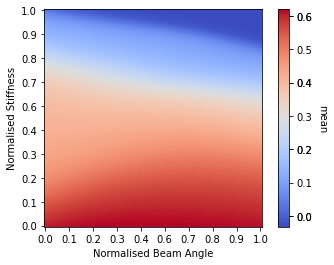

In [73]:
num_y_pts = num_d_pts = 100
fig = plotting_helpers.plot_amortised_phi(reverse_approx, y_lims, d_lims, num_y_pts, num_d_pts, 'mean')
fig.show()

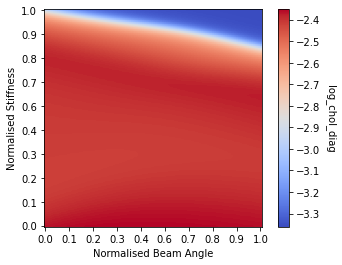

In [74]:
num_y_pts = num_d_pts = 100
fig = plotting_helpers.plot_amortised_phi(reverse_approx, y_lims, d_lims, num_y_pts, num_d_pts, 'log_chol_diag')
fig.show()

TypeError: cannot unpack non-iterable AxesSubplot object

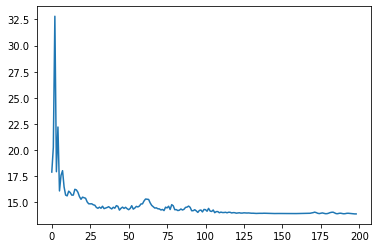

In [75]:
fig = plotting_helpers.plot_loss_history(reverse_loss)
fig.show()

In [83]:
max_iter = 100
num_samples = 1000
y_lims = (0.0, 1.0)
d_lims = (0.0, 1.0)
num_y_pts = num_d_pts = 10
num_layers = 5
nn_width = 10
activation = 'tanh'
phi_lims = {'mean': {'lb':-0.5, 'ub':1.5}, 'log_chol_diag': {'lb':-3, 'ub':-2.}} #, }
forward_approx, forward_loss = \
computation_helpers.train_nn_amortised_normal_approx(beam_gp, y_lims, d_lims, num_y_pts, num_d_pts, 
                                                     noise_cov, prior_mean, prior_cov, 
                                                     prng, num_samples, max_iter,
                                                     num_layers, nn_width, activation, phi_lims,
                                                     loss_name='forward_kl', 
                                                     use_reparameterisation=False)

Loss = 0.0009455141262151301, Params = Jaxtainer({'W_0': DeviceArray([[-0.85361165,  0.10228787, -0.26648444, -0.9732416 ,
              -0.25754884,  2.065165  ,  1.829349  , -0.28121567,
              -0.4030418 ,  0.02247756],
             [-0.19699338,  0.14237651,  0.36207885, -1.0551943 ,
               0.8148043 , -1.4481964 ,  0.03363218,  1.0201149 ,
              -0.34489942,  0.17664057]], dtype=float32), 'b_0': DeviceArray([ 0.09999771, -0.09999747, -0.09999883,  0.09999724,
              0.09999824,  0.09999707,  0.09999876,  0.09999813,
              0.09999266, -0.09999895], dtype=float32), 'W_1': DeviceArray([[-0.55030245,  0.15684816, -0.6928164 ,  0.66309714,
               0.07340799,  0.08788113,  0.27850738,  0.4757263 ,
              -0.09239759,  0.44840366],
             [ 0.28077316,  0.69391346,  0.46359062,  0.7210315 ,
              -0.2866464 , -0.00864659,  0.0929286 ,  0.23579553,
              -0.025302  ,  0.2752737 ],
             [-0.730971  , -0.5639

Loss = 0.0018175607547163963, Params = Jaxtainer({'W_0': DeviceArray([[-0.92212874,  0.03479517, -0.33329046, -1.0343515 ,
              -0.19095446,  2.12979   ,  1.7550442 , -0.2142835 ,
              -0.3367487 , -0.04302185],
             [-0.23366892,  0.05277155,  0.37020075, -0.9704771 ,
               0.8275029 , -1.4719125 ,  0.00617503,  1.016947  ,
              -0.35578868,  0.1898891 ]], dtype=float32), 'b_0': DeviceArray([ 0.15154782, -0.18414341, -0.06815138,  0.1967106 ,
              0.08299099,  0.03952079,  0.08651669,  0.05539334,
              0.05115364, -0.06126523], dtype=float32), 'W_1': DeviceArray([[-6.06196940e-01,  9.61830914e-02, -7.39571154e-01,
               5.90582788e-01,  1.31025165e-03,  1.51076078e-01,
               3.49803627e-01,  5.51630735e-01, -1.60195500e-01,
               5.16566217e-01],
             [ 3.47450763e-01,  7.62130320e-01,  5.49376249e-01,
               7.94412017e-01, -2.22347960e-01, -7.71027654e-02,
               2.661923

Loss = 0.0042997500859200954, Params = Jaxtainer({'W_0': DeviceArray([[-0.89084214,  0.08369329, -0.41538185, -1.0588704 ,
              -0.14315407,  2.2093432 ,  1.6941518 , -0.1426571 ,
              -0.25492948, -0.11116304],
             [-0.17281294,  0.05267043,  0.32259342, -0.880144  ,
               0.81354636, -1.4255959 , -0.05838521,  1.0319536 ,
              -0.2953236 ,  0.18028174]], dtype=float32), 'b_0': DeviceArray([ 0.22357081, -0.15321729, -0.11959876,  0.2933552 ,
              0.03359022,  0.08119699,  0.03223392,  0.07198987,
              0.11001164, -0.07660147], dtype=float32), 'W_1': DeviceArray([[-0.54964554,  0.02104791, -0.8116896 ,  0.5101228 ,
               0.03905381,  0.22210178,  0.36349583,  0.5213782 ,
              -0.23335555,  0.5479481 ],
             [ 0.4228222 ,  0.7229571 ,  0.51235366,  0.7635062 ,
              -0.14205039, -0.11236332, -0.05333522,  0.15057771,
               0.08007345,  0.13857478],
             [-0.57813793, -0.7232

Loss = 0.003316640155389905, Params = Jaxtainer({'W_0': DeviceArray([[-0.8617705 ,  0.1256046 , -0.48458368, -1.0774689 ,
              -0.10376276,  2.2768462 ,  1.6241117 , -0.0839632 ,
              -0.18567237, -0.1678693 ],
             [-0.15419015,  0.05957628,  0.26915506, -0.8218581 ,
               0.79394644, -1.3824489 , -0.11426342,  1.0523475 ,
              -0.2431202 ,  0.17072129]], dtype=float32), 'b_0': DeviceArray([ 0.26582918, -0.12373781, -0.17129156,  0.37786826,
             -0.0201325 ,  0.11030103, -0.02180131,  0.0875762 ,
              0.16168904, -0.08784345], dtype=float32), 'W_1': DeviceArray([[-0.5060581 , -0.04086508, -0.8681707 ,  0.439283  ,
               0.0710313 ,  0.2814249 ,  0.37296703,  0.48642543,
              -0.29529727,  0.57232004],
             [ 0.48529786,  0.6855911 ,  0.46606672,  0.7419112 ,
              -0.07816701, -0.1431509 , -0.1208463 ,  0.1832265 ,
               0.11542799,  0.07975998],
             [-0.4936767 , -0.79126

Loss = 0.0011833147145807743, Params = Jaxtainer({'W_0': DeviceArray([[-0.8417368 ,  0.16278808, -0.5440718 , -1.1087499 ,
              -0.06827813,  2.3385534 ,  1.6229511 , -0.03386731,
              -0.12973417, -0.21686012],
             [-0.14155288,  0.07093865,  0.2203878 , -0.8017211 ,
               0.7778547 , -1.3281188 , -0.14511192,  1.0717291 ,
              -0.20413828,  0.1529672 ]], dtype=float32), 'b_0': DeviceArray([ 0.2882572 , -0.09192374, -0.22104037,  0.39869952,
             -0.06617206,  0.15778004, -0.03434216,  0.10778031,
              0.196305  , -0.11140208], dtype=float32), 'W_1': DeviceArray([[-0.4743076 , -0.09346999, -0.9151932 ,  0.38965032,
               0.09330892,  0.32847506,  0.38049933,  0.4612957 ,
              -0.3447963 ,  0.59036016],
             [ 0.53812224,  0.6549226 ,  0.41872463,  0.7097903 ,
              -0.0185282 , -0.1628228 , -0.17523743,  0.18453418,
               0.13851961,  0.03139514],
             [-0.43903536, -0.8477

Loss = 0.0022388403303921223, Params = Jaxtainer({'W_0': DeviceArray([[-0.8163541 ,  0.19326419, -0.59391695, -1.126948  ,
              -0.03915545,  2.3896525 ,  1.5875244 ,  0.0088556 ,
              -0.07907085, -0.2584751 ],
             [-0.09373181,  0.0647494 ,  0.20373365, -0.75413716,
               0.7605922 , -1.2980325 , -0.20150165,  1.078606  ,
              -0.15566465,  0.14536864]], dtype=float32), 'b_0': DeviceArray([ 0.34009925, -0.07946983, -0.24060585,  0.44856334,
             -0.1190486 ,  0.17929827, -0.08125867,  0.10780963,
              0.23992607, -0.1229232 ], dtype=float32), 'W_1': DeviceArray([[-0.4898906 , -0.1387975 , -0.97352463,  0.34589803,
               0.10742798,  0.37363675,  0.38881522,  0.44000274,
              -0.39307824,  0.6018    ],
             [ 0.6043097 ,  0.62849545,  0.40080357,  0.68273616,
               0.03689431, -0.18332714, -0.2232895 ,  0.18662292,
               0.16242252, -0.00729279],
             [-0.37038776, -0.8962

Loss = 0.0026116298977285624, Params = Jaxtainer({'W_0': DeviceArray([[-0.7917153 ,  0.218744  , -0.63685614, -1.1314201 ,
              -0.01489121,  2.4310992 ,  1.5410405 ,  0.04590711,
              -0.03327255, -0.29415244],
             [-0.07125791,  0.06021088,  0.18490618, -0.7153284 ,
               0.7441222 , -1.2798387 , -0.24159862,  1.0870533 ,
              -0.1173966 ,  0.14679109]], dtype=float32), 'b_0': DeviceArray([ 0.3980176 , -0.07882561, -0.24637027,  0.5124767 ,
             -0.16079843,  0.1722476 , -0.13845295,  0.10023057,
              0.28741634, -0.11732512], dtype=float32), 'W_1': DeviceArray([[-5.0549585e-01, -1.7941314e-01, -1.0390019e+00,
               2.8731412e-01,  1.2267317e-01,  4.1855407e-01,
               3.9866889e-01,  4.1456723e-01, -4.4073781e-01,
               6.1401266e-01],
             [ 6.6842794e-01,  6.0569739e-01,  4.0257156e-01,
               6.7395461e-01,  8.4636271e-02, -2.0523776e-01,
              -2.6693994e-01,  1.912954

Loss = 0.0021824112627655268, Params = Jaxtainer({'W_0': DeviceArray([[-0.7441031 ,  0.23417176, -0.667955  , -1.0897664 ,
               0.00725897,  2.4505062 ,  1.4789844 ,  0.07759252,
               0.01616269, -0.3231503 ],
             [-0.02009234,  0.0313358 ,  0.1981717 , -0.6558501 ,
               0.7427482 , -1.307804  , -0.30216467,  1.0882521 ,
              -0.06133892,  0.16657302]], dtype=float32), 'b_0': DeviceArray([ 0.46914816, -0.09600796, -0.23087071,  0.5866078 ,
             -0.18949549,  0.13702148, -0.209052  ,  0.08855733,
              0.3462908 , -0.09510185], dtype=float32), 'W_1': DeviceArray([[-0.53010505, -0.21483485, -1.1117178 ,  0.21830198,
               0.13746372,  0.46547094,  0.40882003,  0.38094196,
              -0.49199012,  0.624558  ],
             [ 0.7183579 ,  0.58546036,  0.3999497 ,  0.6705149 ,
               0.12620234, -0.2239036 , -0.30415502,  0.19805911,
               0.21115468, -0.07169541],
             [-0.21284541, -0.9761

Loss = 0.0006494316039606929, Params = Jaxtainer({'W_0': DeviceArray([[-0.71446055,  0.25107718, -0.6982708 , -1.0787225 ,
               0.0232356 ,  2.4780827 ,  1.4471804 ,  0.10554945,
               0.05518588, -0.35110003],
             [ 0.02553945,  0.00567683,  0.20966162, -0.60469496,
               0.7406881 , -1.3314302 , -0.35671812,  1.0891404 ,
              -0.01124962,  0.18319097]], dtype=float32), 'b_0': DeviceArray([ 0.49494803, -0.09357455, -0.2327745 ,  0.6124618 ,
             -0.23736545,  0.13904539, -0.23063235,  0.07741401,
              0.37069577, -0.09227781], dtype=float32), 'W_1': DeviceArray([[-0.54260075, -0.24634248, -1.1276706 ,  0.20453326,
               0.1472383 ,  0.48940095,  0.4073711 ,  0.3779575 ,
              -0.5209462 ,  0.6328616 ],
             [ 0.7565884 ,  0.5676458 ,  0.37185678,  0.644381  ,
               0.16470815, -0.23203258, -0.33258846,  0.18747601,
               0.2239385 , -0.09857336],
             [-0.14316106, -1.0111

Loss = 0.0007313599926419556, Params = Jaxtainer({'W_0': DeviceArray([[-0.7009041 ,  0.269583  , -0.7274898 , -1.084787  ,
               0.03483504,  2.511116  ,  1.4391769 ,  0.12990949,
               0.08460557, -0.37688816],
             [ 0.06382567, -0.01592155,  0.21808699, -0.5633677 ,
               0.73611885, -1.3482063 , -0.40355316,  1.0901304 ,
               0.03196638,  0.19572432]], dtype=float32), 'b_0': DeviceArray([ 0.49911514, -0.08037383, -0.24449302,  0.6180357 ,
             -0.29735816,  0.15949102, -0.22900902,  0.06191227,
              0.37652367, -0.0998822 ], dtype=float32), 'W_1': DeviceArray([[-0.5539237 , -0.27499798, -1.1214263 ,  0.21529783,
               0.15105067,  0.4998074 ,  0.39907256,  0.39365596,
              -0.5349529 ,  0.6390692 ],
             [ 0.7937297 ,  0.5519534 ,  0.3346225 ,  0.60744864,
               0.2012782 , -0.2346092 , -0.35571888,  0.16773511,
               0.23031569, -0.12174042],
             [-0.09124895, -1.0411

Loss = 0.0007045784150250256, Params = Jaxtainer({'W_0': DeviceArray([[-0.7238238 ,  0.2969124 , -0.7622581 , -1.1266923 ,
               0.02933991,  2.5640788 ,  1.4750621 ,  0.1484814 ,
               0.09341586, -0.40610564],
             [ 0.0668068 , -0.01281868,  0.20740959, -0.56409615,
               0.7025807 , -1.3258374 , -0.4071019 ,  1.0802985 ,
               0.0419074 ,  0.18915983]], dtype=float32), 'b_0': DeviceArray([ 0.4747523 , -0.04984726, -0.27322987,  0.59256274,
             -0.369453  ,  0.20454906, -0.19828406,  0.03330497,
              0.3573171 , -0.12719087], dtype=float32), 'W_1': DeviceArray([[-0.54818076, -0.30136338, -1.0898798 ,  0.25283512,
               0.1487659 ,  0.49172658,  0.3824718 ,  0.43040192,
              -0.5323088 ,  0.64532703],
             [ 0.828722  ,  0.5380745 ,  0.29462436,  0.5658839 ,
               0.23531127, -0.23417754, -0.3757523 ,  0.14435187,
               0.23322935, -0.14213732],
             [-0.07055507, -1.0662

Loss = 0.0004420465847942978, Params = Jaxtainer({'W_0': DeviceArray([[-0.74392307,  0.3214264 , -0.79312927, -1.1637771 ,
               0.02526791,  2.6106722 ,  1.5060047 ,  0.16527386,
               0.10143661, -0.43196148],
             [ 0.0697761 , -0.01035954,  0.19830379, -0.5646614 ,
               0.6734539 , -1.3065681 , -0.41116396,  1.0720713 ,
               0.05114439,  0.18362963]], dtype=float32), 'b_0': DeviceArray([ 0.45647237, -0.02516582, -0.29557675,  0.5731372 ,
             -0.4272147 ,  0.23969848, -0.17548114,  0.01020443,
              0.34308398, -0.14817718], dtype=float32), 'W_1': DeviceArray([[-0.54527843, -0.32513547, -1.0669607 ,  0.2810527 ,
               0.14733694,  0.4874594 ,  0.36994016,  0.45789906,
              -0.533116  ,  0.6504294 ],
             [ 0.86206245,  0.5256098 ,  0.2609111 ,  0.5311217 ,
               0.26570302, -0.23458509, -0.3944991 ,  0.12559164,
               0.23656294, -0.16017972],
             [-0.05234707, -1.0887

Loss = 0.0007267621112987399, Params = Jaxtainer({'W_0': DeviceArray([[-0.7621406 ,  0.3435753 , -0.8208651 , -1.197437  ,
               0.02179026,  2.6524062 ,  1.5334883 ,  0.18044716,
               0.10863706, -0.45505205],
             [ 0.07220531, -0.00810625,  0.19032389, -0.56546384,
               0.6474557 , -1.2895811 , -0.41511154,  1.0649447 ,
               0.05944461,  0.17928897]], dtype=float32), 'b_0': DeviceArray([ 0.4397341 , -0.00291483, -0.31566516,  0.55517465,
             -0.47927904,  0.27128047, -0.15511651, -0.0102316 ,
              0.3302872 , -0.16675495], dtype=float32), 'W_1': DeviceArray([[-0.5421867 , -0.3467135 , -1.0463153 ,  0.30611497,
               0.1464376 ,  0.48340774,  0.3590763 ,  0.48188788,
              -0.5335491 ,  0.6547886 ],
             [ 0.8927928 ,  0.51437753,  0.23023923,  0.49951035,
               0.29314667, -0.23490855, -0.41154647,  0.1086566 ,
               0.23954077, -0.17638537],
             [-0.03691197, -1.1087

Loss = 0.001044252421706915, Params = Jaxtainer({'W_0': DeviceArray([[-0.77429664,  0.3617835 , -0.84315276, -1.2213368 ,
               0.02347409,  2.6818957 ,  1.5497732 ,  0.19481279,
               0.11703068, -0.47363502],
             [ 0.08252031, -0.01421589,  0.19556862, -0.5546449 ,
               0.64618313, -1.2946798 , -0.43254462,  1.0641116 ,
               0.07368731,  0.18840797]], dtype=float32), 'b_0': DeviceArray([ 0.433313  ,  0.00940985, -0.3210455 ,  0.550137  ,
             -0.5021758 ,  0.28123778, -0.15043147, -0.02178526,
              0.325416  , -0.1685517 ], dtype=float32), 'W_1': DeviceArray([[-5.4408985e-01, -3.6659151e-01, -1.0392449e+00,
               3.1190300e-01,  1.4852378e-01,  4.8748517e-01,
               3.5333776e-01,  4.8866907e-01, -5.4226941e-01,
               6.5700948e-01],
             [ 9.1979498e-01,  5.0414723e-01,  1.9741890e-01,
               4.6349531e-01,  3.1868893e-01, -2.3312676e-01,
              -4.2621154e-01,  8.7863065

Loss = 0.001027399324811995, Params = Jaxtainer({'W_0': DeviceArray([[-0.78532475,  0.3782564 , -0.86318547, -1.2431033 ,
               0.02524985,  2.7081637 ,  1.5640103 ,  0.20785499,
               0.12466333, -0.49020925],
             [ 0.09157418, -0.01955342,  0.20074932, -0.54510194,
               0.64566445, -1.2998625 , -0.44863015,  1.0634834 ,
               0.08648537,  0.19776241]], dtype=float32), 'b_0': DeviceArray([ 0.4271464 ,  0.02078438, -0.32600015,  0.5450848 ,
             -0.52300346,  0.2903807 , -0.14612046, -0.03218654,
              0.3208795 , -0.16986845], dtype=float32), 'W_1': DeviceArray([[-0.5445582 , -0.38465503, -1.032552  ,  0.31722814,
               0.15073723,  0.49093756,  0.34820318,  0.49458885,
              -0.5498045 ,  0.65899736],
             [ 0.9447313 ,  0.49487996,  0.16740689,  0.43031457,
               0.3419991 , -0.23143806, -0.43949163,  0.06849892,
               0.24047264, -0.20507489],
             [-0.00422534, -1.14125

Loss = 0.0007562951650470495, Params = Jaxtainer({'W_0': DeviceArray([[-0.7887159 ,  0.39023966, -0.876394  , -1.2491854 ,
               0.03490882,  2.7172399 ,  1.5634081 ,  0.2207522 ,
               0.13422415, -0.500625  ],
             [ 0.11249736, -0.03746613,  0.22577573, -0.5157635 ,
               0.6744131 , -1.3331928 , -0.48375452,  1.0727009 ,
               0.10772696,  0.22850145]], dtype=float32), 'b_0': DeviceArray([ 0.43276304,  0.0211123 , -0.3127693 ,  0.5564005 ,
             -0.5142363 ,  0.274689  , -0.15995482, -0.03164772,
              0.32436877, -0.1503213 ], dtype=float32), 'W_1': DeviceArray([[-0.5530742 , -0.40120035, -1.0403792 ,  0.30048218,
               0.15477026,  0.50475746,  0.3471274 ,  0.48266193,
              -0.569045  ,  0.65747017],
             [ 0.96231925,  0.48639145,  0.12933719,  0.3813323 ,
               0.36412436, -0.2239814 , -0.45065325,  0.0391736 ,
               0.23472854, -0.21912423],
             [ 0.01711151, -1.1547

Loss = 0.0004327549831941724, Params = Jaxtainer({'W_0': DeviceArray([[-0.79177326,  0.40117642, -0.88822424, -1.2545087 ,
               0.0438069 ,  2.7251034 ,  1.5625706 ,  0.23243983,
               0.14284638, -0.5098326 ],
             [ 0.1314814 , -0.05369464,  0.24884301, -0.4890637 ,
               0.7009654 , -1.3639388 , -0.51597846,  1.0812731 ,
               0.12703072,  0.25708163]], dtype=float32), 'b_0': DeviceArray([ 0.43783167,  0.02141687, -0.30060494,  0.56665915,
             -0.506079  ,  0.26019132, -0.1727242 , -0.03095085,
              0.32754225, -0.13213137], dtype=float32), 'W_1': DeviceArray([[-5.6062919e-01, -4.1621777e-01, -1.0476047e+00,
               2.8507712e-01,  1.5846910e-01,  5.1735246e-01,
               3.4634006e-01,  4.7126463e-01, -5.8648944e-01,
               6.5594578e-01],
             [ 9.7882104e-01,  4.7867608e-01,  9.4585642e-02,
               3.3641207e-01,  3.8431051e-01, -2.1712562e-01,
              -4.6109781e-01,  1.281490

Loss = 0.00045297990436665714, Params = Jaxtainer({'W_0': DeviceArray([[-0.79097164,  0.4099891 , -0.8966873 , -1.252822  ,
               0.05566668,  2.7250001 ,  1.5553001 ,  0.24356546,
               0.15204465, -0.5158851 ],
             [ 0.15315965, -0.07202113,  0.27552608, -0.45814648,
               0.7335227 , -1.4010547 , -0.5521215 ,  1.0924807 ,
               0.14811401,  0.29010436]], dtype=float32), 'b_0': DeviceArray([ 0.444633  ,  0.02007046, -0.28665096,  0.57931376,
             -0.4942111 ,  0.24239856, -0.187702  , -0.02830932,
              0.33204883, -0.11135124], dtype=float32), 'W_1': DeviceArray([[-0.5701316 , -0.42978942, -1.0558902 ,  0.2675382 ,
               0.16195133,  0.5306241 ,  0.34619883,  0.4584367 ,
              -0.60358196,  0.65369684],
             [ 0.992135  ,  0.471672  ,  0.05955224,  0.28812644,
               0.4029586 , -0.20859638, -0.47085595, -0.01359934,
               0.22294004, -0.24385962],
             [ 0.05544757, -1.178

Loss = 0.0005544191226363182, Params = Jaxtainer({'W_0': DeviceArray([[-0.7864008 ,  0.41704473, -0.9018206 , -1.2462943 ,
               0.07061308,  2.7173016 ,  1.5411494 ,  0.25494623,
               0.16166683, -0.5193673 ],
             [ 0.17883866, -0.09263394,  0.30756313, -0.42388427,
               0.7743602 , -1.4462578 , -0.5946824 ,  1.1119782 ,
               0.17150117,  0.32748803]], dtype=float32), 'b_0': DeviceArray([ 0.4607015 ,  0.0129406 , -0.26139513,  0.6006718 ,
             -0.4645135 ,  0.20868793, -0.21627907, -0.00925826,
              0.3426483 , -0.07928342], dtype=float32), 'W_1': DeviceArray([[-0.58322304, -0.4420978 , -1.0759039 ,  0.23596255,
               0.16513304,  0.55195653,  0.35015726,  0.42932725,
              -0.6305878 ,  0.64932835],
             [ 1.0040863 ,  0.46524322,  0.02209799,  0.23630229,
               0.41992164, -0.19824861, -0.47971848, -0.04353118,
               0.2135738 , -0.25507525],
             [ 0.07531714, -1.1883

Loss = 0.0004271650977898389, Params = Jaxtainer({'W_0': DeviceArray([[-0.78234106,  0.42361647, -0.9063915 , -1.2397639 ,
               0.08394542,  2.710161  ,  1.528556  ,  0.26517856,
               0.1702396 , -0.5223585 ],
             [ 0.20216972, -0.11130129,  0.33678374, -0.39258304,
               0.8114585 , -1.4875062 , -0.6333938 ,  1.1297798 ,
               0.19273163,  0.36170146]], dtype=float32), 'b_0': DeviceArray([ 0.47529036,  0.00650172, -0.23833674,  0.62022924,
             -0.4375646 ,  0.17785639, -0.2423483 ,  0.00823269,
              0.3522519 , -0.04981993], dtype=float32), 'W_1': DeviceArray([[-0.59535044, -0.4532621 , -1.0942262 ,  0.2070296 ,
               0.1680196 ,  0.57141274,  0.3539623 ,  0.4022768 ,
              -0.6551839 ,  0.6452204 ],
             [ 1.0154698 ,  0.45937234, -0.0117507 ,  0.18892351,
               0.4353167 , -0.18881509, -0.48850718, -0.06880552,
               0.20501348, -0.26514152],
             [ 0.0930395 , -1.1974

Loss = 0.0003137215389870107, Params = Jaxtainer({'W_0': DeviceArray([[-0.7784749 ,  0.42967576, -0.9102864 , -1.2330351 ,
               0.09620792,  2.7029033 ,  1.5166452 ,  0.27448142,
               0.17805186, -0.52472967],
             [ 0.22360195, -0.12823595,  0.36386192, -0.36374247,
               0.8457768 , -1.5257672 , -0.6691151 ,  1.1462982 ,
               0.2122226 ,  0.3935668 ]], dtype=float32), 'b_0': DeviceArray([ 0.48834142,  0.00079779, -0.21739967,  0.6380379 ,
             -0.41325963,  0.14991929, -0.26587114,  0.02369738,
              0.3608415 , -0.02281077], dtype=float32), 'W_1': DeviceArray([[-0.6059465 , -0.4634787 , -1.1105933 ,  0.18077743,
               0.17089088,  0.58894193,  0.35750186,  0.37773064,
              -0.6772223 ,  0.64149314],
             [ 1.0260694 ,  0.45402277, -0.04255152,  0.14519772,
               0.4493823 , -0.1801003 , -0.49699304, -0.09061436,
               0.19714604, -0.27428186],
             [ 0.10883585, -1.2056

Loss = 0.0003826288157142699, Params = Jaxtainer({'W_0': DeviceArray([[-0.775247  ,  0.43534583, -0.9138545 , -1.2270386 ,
               0.1071205 ,  2.6967404 ,  1.5065632 ,  0.28274044,
               0.18497023, -0.52694696],
             [ 0.24294627, -0.14338152,  0.38858232, -0.33767787,
               0.87701905, -1.5603303 , -0.7012733 ,  1.1608189 ,
               0.22976175,  0.42253038]], dtype=float32), 'b_0': DeviceArray([ 0.5000503 , -0.00421992, -0.19831109,  0.65401125,
             -0.39124405,  0.12467432, -0.28706664,  0.03744455,
              0.3685194 ,  0.00175867], dtype=float32), 'W_1': DeviceArray([[-0.61470073, -0.4728343 , -1.1253682 ,  0.15699549,
               0.17389983,  0.60477185,  0.36084118,  0.3553053 ,
              -0.6972037 ,  0.6382397 ],
             [ 1.0357764 ,  0.44917053, -0.07024066,  0.10578495,
               0.46228835, -0.17228892, -0.50504506, -0.10895235,
               0.19008721, -0.28250536],
             [ 0.12290638, -1.2130

Loss = 0.00038610323099419475, Params = Jaxtainer({'W_0': DeviceArray([[-0.7717727 ,  0.44054556, -0.91666096, -1.2206371 ,
               0.11754563,  2.6895838 ,  1.4959282 ,  0.2904014 ,
               0.19152634, -0.52837485],
             [ 0.26098672, -0.15709838,  0.4118423 , -0.31343415,
               0.9063318 , -1.5930328 , -0.73153096,  1.1745849 ,
               0.24612565,  0.45007455]], dtype=float32), 'b_0': DeviceArray([ 0.5110064 , -0.00875102, -0.18040547,  0.66883826,
             -0.37059534,  0.10088646, -0.30703706,  0.05062141,
              0.3757765 ,  0.02501074], dtype=float32), 'W_1': DeviceArray([[-0.6219636 , -0.48139614, -1.1390672 ,  0.13468581,
               0.17708486,  0.6194826 ,  0.36408138,  0.33397916,
              -0.71561915,  0.63519275],
             [ 1.0445548 ,  0.44476312, -0.0956523 ,  0.06883269,
               0.4742434 , -0.16489199, -0.5125633 , -0.12572289,
               0.18353862, -0.29010856],
             [ 0.13557582, -1.219

Loss = 0.0003003424499183893, Params = Jaxtainer({'W_0': DeviceArray([[-0.7793938 ,  0.44664782, -0.92258036, -1.2269908 ,
               0.11969079,  2.6978264 ,  1.5045934 ,  0.2939864 ,
               0.19300097, -0.53322667],
             [ 0.27103356, -0.16770138,  0.42884174, -0.2980653 ,
               0.925622  , -1.6130319 , -0.7494565 ,  1.1789254 ,
               0.25605923,  0.4693866 ]], dtype=float32), 'b_0': DeviceArray([ 0.5140557 , -0.01122995, -0.16874425,  0.67575145,
             -0.3603495 ,  0.08868125, -0.31576934,  0.05073671,
              0.37754914,  0.0398377 ], dtype=float32), 'W_1': DeviceArray([[-0.6257274 , -0.48964882, -1.145959  ,  0.12207747,
               0.1812635 ,  0.62801284,  0.36599475,  0.32151988,
              -0.7277408 ,  0.63426036],
             [ 1.0546634 ,  0.44054127, -0.11219715,  0.0461433 ,
               0.4856464 , -0.16173829, -0.5204212 , -0.13206547,
               0.18033594, -0.29584244],
             [ 0.14437377, -1.2249

Loss = 0.00036417855881154537, Params = Jaxtainer({'W_0': DeviceArray([[-0.7867368 ,  0.45228192, -0.92800486, -1.2327025 ,
               0.12132169,  2.7056277 ,  1.5133647 ,  0.29708394,
               0.19416684, -0.5377543 ],
             [ 0.2800223 , -0.17732488,  0.44428176, -0.28409928,
               0.9429848 , -1.6310954 , -0.76542443,  1.1825993 ,
               0.26500863,  0.48677355]], dtype=float32), 'b_0': DeviceArray([ 0.5167031 , -0.01345253, -0.15815797,  0.6820046 ,
             -0.3511986 ,  0.07763956, -0.32354048,  0.05074364,
              0.37909108,  0.05324651], dtype=float32), 'W_1': DeviceArray([[-0.6293283 , -0.4971475 , -1.1521678 ,  0.11058497,
               0.1852187 ,  0.63573074,  0.36784196,  0.31009007,
              -0.7387779 ,  0.6334041 ],
             [ 1.0641749 ,  0.43667233, -0.1266999 ,  0.02570553,
               0.49613482, -0.15898451, -0.52784806, -0.13640162,
               0.1774509 , -0.30095544],
             [ 0.15218464, -1.229

Loss = 0.0004495088360272348, Params = Jaxtainer({'W_0': DeviceArray([[-0.79409814,  0.45748323, -0.93317   , -1.2383232 ,
               0.12240795,  2.713878  ,  1.5229982 ,  0.29973218,
               0.19489005, -0.54228747],
             [ 0.28779912, -0.18604375,  0.45800227, -0.27173418,
               0.95840377, -1.6467026 , -0.7790568 ,  1.1855123 ,
               0.27279997,  0.50184953]], dtype=float32), 'b_0': DeviceArray([ 0.5189921 , -0.0154643 , -0.14863515,  0.68762106,
             -0.3429984 ,  0.06784115, -0.33034322,  0.05079444,
              0.3803821 ,  0.06513699], dtype=float32), 'W_1': DeviceArray([[-0.6328146 , -0.50394446, -1.1578567 ,  0.10023252,
               0.18876171,  0.6426836 ,  0.36955434,  0.2996904 ,
              -0.7488875 ,  0.63269025],
             [ 1.0731325 ,  0.43314174, -0.13942738,  0.00788104,
               0.5056276 , -0.15672778, -0.53487635, -0.13877283,
               0.17484692, -0.30541345],
             [ 0.15912402, -1.2337

Loss = 0.0003201581130269915, Params = Jaxtainer({'W_0': DeviceArray([[-0.8206563 ,  0.46481422, -0.943797  , -1.2660728 ,
               0.11449495,  2.7468054 ,  1.5605314 ,  0.29827374,
               0.18700695, -0.5537051 ],
             [ 0.2811191 , -0.19020681,  0.4624044 , -0.2749918 ,
               0.9624091 , -1.6405077 , -0.771524  ,  1.1776137 ,
               0.26965582,  0.50308394]], dtype=float32), 'b_0': DeviceArray([ 0.5139058 , -0.01550407, -0.14412269,  0.6855139 ,
             -0.34070984,  0.06884492, -0.32684773,  0.04495932,
              0.37663418,  0.06889056], dtype=float32), 'W_1': DeviceArray([[-0.63235873, -0.5101478 , -1.160206  ,  0.09757767,
               0.19236733,  0.64481205,  0.36970645,  0.29508087,
              -0.7566091 ,  0.6341128 ],
             [ 1.0866605 ,  0.42988026, -0.14305888,  0.01130882,
               0.5147531 , -0.16145682, -0.54307234, -0.1278572 ,
               0.1748243 , -0.3068482 ],
             [ 0.16012555, -1.2374

Loss = 0.00028808374190703034, Params = Jaxtainer({'W_0': DeviceArray([[-0.84800106,  0.47189   , -0.95441926, -1.2949497 ,
               0.10558046,  2.7805681 ,  1.5992384 ,  0.29593763,
               0.17849468, -0.5649174 ],
             [ 0.27298486, -0.1934576 ,  0.46519336, -0.28009284,
               0.9642338 , -1.6321162 , -0.7617976 ,  1.1676713 ,
               0.2652717 ,  0.5028949 ]], dtype=float32), 'b_0': DeviceArray([ 0.50780046, -0.01516486, -0.14085285,  0.68200666,
             -0.3399185 ,  0.07160775, -0.32179725,  0.03790943,
              0.37221262,  0.07131013], dtype=float32), 'W_1': DeviceArray([[-0.6313176 , -0.51578987, -1.1616515 ,  0.09642869,
               0.19582105,  0.6458711 ,  0.36950636,  0.2917572 ,
              -0.76325566,  0.6357783 ],
             [ 1.0995764 ,  0.42690182, -0.14491785,  0.01687393,
               0.52321565, -0.16668864, -0.5508625 , -0.11583433,
               0.17533161, -0.30784714],
             [ 0.16035561, -1.240

Loss = 0.00042453384958207607, Params = Jaxtainer({'W_0': DeviceArray([[-0.8706572 ,  0.47807807, -0.9633281 , -1.3184538 ,
               0.09830892,  2.8080883 ,  1.6308427 ,  0.2945178 ,
               0.17163642, -0.57439727],
             [ 0.26708174, -0.19681235,  0.46876323, -0.283014  ,
               0.966833  , -1.626835  , -0.7551969 ,  1.1604097 ,
               0.26235068,  0.5039193 ]], dtype=float32), 'b_0': DeviceArray([ 0.5033276 , -0.01508505, -0.13711809,  0.6799626 ,
             -0.33851144,  0.0724261 , -0.31888297,  0.03337004,
              0.3689003 ,  0.07454845], dtype=float32), 'W_1': DeviceArray([[-0.630704  , -0.5209035 , -1.1635525 ,  0.09416519,
               0.19884627,  0.6474929 ,  0.36949265,  0.2873128 ,
              -0.7697631 ,  0.63705486],
             [ 1.1110202 ,  0.42420238, -0.1475166 ,  0.01992306,
               0.5308264 , -0.17076313, -0.5578398 , -0.10663214,
               0.17541522, -0.3089542 ],
             [ 0.16093016, -1.244

Loss = 0.0004770459490828216, Params = Jaxtainer({'W_0': DeviceArray([[-0.89267313,  0.48388165, -0.97179264, -1.3408556 ,
               0.09075832,  2.8340771 ,  1.6610264 ,  0.29248494,
               0.164932  , -0.58285964],
             [ 0.26123497, -0.19974346,  0.47185495, -0.28584442,
               0.9685004 , -1.6219627 , -0.7489042 ,  1.1524793 ,
               0.25945342,  0.50532144]], dtype=float32), 'b_0': DeviceArray([ 0.49713802, -0.01453856, -0.13498461,  0.67640096,
             -0.33908933,  0.07547118, -0.31375295,  0.02506079,
              0.36462846,  0.07715914], dtype=float32), 'W_1': DeviceArray([[-0.62965685, -0.52563584, -1.1635767 ,  0.09393032,
               0.20207156,  0.6476957 ,  0.36897147,  0.2851372 ,
              -0.7740902 ,  0.63841784],
             [ 1.121564  ,  0.42171076, -0.1489187 ,  0.0232483 ,
               0.537936  , -0.17475572, -0.5643163 , -0.0976578 ,
               0.17609431, -0.31001297],
             [ 0.16117215, -1.2467

Loss = 0.00047903170343488455, Params = Jaxtainer({'W_0': DeviceArray([[-0.9123837 ,  0.4891493 , -0.9793434 , -1.3608751 ,
               0.08398288,  2.85709   ,  1.6877611 ,  0.2908221 ,
               0.15896417, -0.59039634],
             [ 0.25611624, -0.20244394,  0.47486845, -0.2881898 ,
               0.97010607, -1.6179816 , -0.74360806,  1.1456647 ,
               0.25696626,  0.5068666 ]], dtype=float32), 'b_0': DeviceArray([ 0.4917639 , -0.01406964, -0.1328078 ,  0.67338645,
             -0.33946705,  0.07774763, -0.30959934,  0.01826306,
              0.36090654,  0.07985891], dtype=float32), 'W_1': DeviceArray([[-0.62872696, -0.52992827, -1.1638116 ,  0.09337959,
               0.20498744,  0.6480677 ,  0.36852705,  0.28255188,
              -0.7781905 ,  0.6395876 ],
             [ 1.1311905 ,  0.41944823, -0.15040655,  0.02587109,
               0.5443947 , -0.1782619 , -0.57020813, -0.09000511,
               0.17663045, -0.3110202 ],
             [ 0.16138327, -1.249

Loss = 0.0005177685525268316, Params = Jaxtainer({'W_0': DeviceArray([[-0.9306351 ,  0.49400833, -0.98631996, -1.3796942 ,
               0.07781797,  2.8785126 ,  1.7124302 ,  0.28935426,
               0.15340526, -0.59731513],
             [ 0.2511244 , -0.20477706,  0.47739238, -0.2908348 ,
               0.97152615, -1.6138126 , -0.73839283,  1.1393957 ,
               0.25446886,  0.50812835]], dtype=float32), 'b_0': DeviceArray([ 0.48692992, -0.01363503, -0.13077764,  0.6705874 ,
             -0.3397055 ,  0.07976697, -0.3059837 ,  0.01263923,
              0.35753837,  0.08234368], dtype=float32), 'W_1': DeviceArray([[-0.6277709 , -0.53383905, -1.1642268 ,  0.09273418,
               0.2075258 ,  0.64845777,  0.3681409 ,  0.27984577,
              -0.7820595 ,  0.64069176],
             [ 1.1400932 ,  0.41738516, -0.15185547,  0.02838554,
               0.55022   , -0.18150842, -0.57559395, -0.08316669,
               0.17710435, -0.31188995],
             [ 0.16143344, -1.2515

Loss = 0.0005363550153560936, Params = Jaxtainer({'W_0': DeviceArray([[-0.9463141 ,  0.49831825, -0.9923102 , -1.3955165 ,
               0.07234755,  2.8965197 ,  1.7332162 ,  0.28844014,
               0.1486792 , -0.6033726 ],
             [ 0.24723223, -0.20708111,  0.48019624, -0.29240227,
               0.9729803 , -1.6111717 , -0.7347472 ,  1.1348519 ,
               0.25261116,  0.50969774]], dtype=float32), 'b_0': DeviceArray([ 0.4831395 , -0.01338371, -0.12846082,  0.66878086,
             -0.33975887,  0.08057657, -0.30369058,  0.00879683,
              0.35482848,  0.08504207], dtype=float32), 'W_1': DeviceArray([[-0.6270225 , -0.537397  , -1.1649414 ,  0.09146172,
               0.20970817,  0.6491666 ,  0.36785445,  0.276607  ,
              -0.78586125,  0.6415683 ],
             [ 1.1481223 ,  0.41550803, -0.1535809 ,  0.029815  ,
               0.55544454, -0.18420397, -0.5804639 , -0.07778176,
               0.17733632, -0.31275755],
             [ 0.1615874 , -1.2536

Loss = 0.0005124091985635459, Params = Jaxtainer({'W_0': DeviceArray([[-0.9601345 ,  0.5021857 , -0.9975869 , -1.4092606 ,
               0.06740749,  2.9121656 ,  1.7512798 ,  0.28783056,
               0.14453416, -0.60876465],
             [ 0.2440074 , -0.20926967,  0.48299912, -0.29340062,
               0.9743499 , -1.609349  , -0.7320018 ,  1.1313438 ,
               0.2511169 ,  0.51134217]], dtype=float32), 'b_0': DeviceArray([ 0.47998244, -0.01322773, -0.126123  ,  0.66750723,
             -0.3397594 ,  0.08079989, -0.30210978,  0.00593665,
              0.35252902,  0.08772049], dtype=float32), 'W_1': DeviceArray([[-0.62638813, -0.54063785, -1.165754  ,  0.08997084,
               0.21161738,  0.6499786 ,  0.36762175,  0.27326575,
              -0.7894411 ,  0.6423114 ],
             [ 1.1554141 ,  0.41379738, -0.15536709,  0.03067503,
               0.56014735, -0.18653037, -0.5848825 , -0.07334913,
               0.17745526, -0.31357938],
             [ 0.16176113, -1.2555

Loss = 0.00047827407252043486, Params = Jaxtainer({'W_0': DeviceArray([[-0.9725258 ,  0.50568324, -1.0023166 , -1.4215175 ,
               0.06292285,  2.9260938 ,  1.76735   ,  0.2873688 ,
               0.14082482, -0.6136217 ],
             [ 0.24120434, -0.21130079,  0.4856566 , -0.29414034,
               0.97560865, -1.607937  , -0.72975147,  1.1284072 ,
               0.24983625,  0.51293284]], dtype=float32), 'b_0': DeviceArray([ 0.4772336 , -0.01311706, -0.12389824,  0.6664904 ,
             -0.33974043,  0.08078756, -0.30089298,  0.00360685,
              0.35050473,  0.09025147], dtype=float32), 'W_1': DeviceArray([[-0.6258241 , -0.54358935, -1.1665691 ,  0.08848245,
               0.21331838,  0.6507833 ,  0.36742422,  0.2700514 ,
              -0.792744  ,  0.64297074],
             [ 1.162051  ,  0.41223893, -0.15710007,  0.03127125,
               0.5644025 , -0.18859449, -0.5888978 , -0.06953074,
               0.17752878, -0.3143395 ],
             [ 0.16192743, -1.257

Loss = 0.00048536687972955406, Params = Jaxtainer({'W_0': DeviceArray([[-0.9836833 ,  0.50885415, -1.006576  , -1.4325446 ,
               0.0588544 ,  2.93858   ,  1.781729  ,  0.28701106,
               0.13748738, -0.61801064],
             [ 0.2387313 , -0.21316908,  0.48813927, -0.29472616,
               0.97676474, -1.6067975 , -0.7278593 ,  1.1258951 ,
               0.24871457,  0.5144405 ]], dtype=float32), 'b_0': DeviceArray([ 0.47481748, -0.01303567, -0.12180943,  0.6656398 ,
             -0.33970064,  0.08063916, -0.2999419 ,  0.0016802 ,
              0.34870732,  0.09261545], dtype=float32), 'W_1': DeviceArray([[-0.6253075 , -0.5462764 , -1.1673743 ,  0.08704872,
               0.21483867,  0.65155566,  0.36725843,  0.2669981 ,
              -0.7957756 ,  0.64356464],
             [ 1.1680901 ,  0.4108206 , -0.1587729 ,  0.03169842,
               0.56825566, -0.19043903, -0.59254634, -0.06621309,
               0.17757578, -0.31503808],
             [ 0.16208257, -1.258

Loss = 0.00047334437840618193, Params = Jaxtainer({'W_0': DeviceArray([[-0.9937405 ,  0.51173335, -1.010417  , -1.4425234 ,
               0.05517456,  2.9498074 ,  1.7946068 ,  0.28673944,
               0.13447918, -0.6219795 ],
             [ 0.23653376, -0.21487677,  0.49044308, -0.2952213 ,
               0.97783405, -1.6058536 , -0.7262546 ,  1.1237353 ,
               0.24772047,  0.5158595 ]], dtype=float32), 'b_0': DeviceArray([ 4.7269481e-01, -1.2975748e-02, -1.1985473e-01,
              6.6490477e-01, -3.3963078e-01,  8.0397256e-02,
             -2.9921770e-01,  1.0440941e-04,  3.4710991e-01,
              9.4816469e-02], dtype=float32), 'W_1': DeviceArray([[-0.6248258 , -0.54872155, -1.1681747 ,  0.08568618,
               0.21619675,  0.6522889 ,  0.36712533,  0.264098  ,
              -0.7985514 ,  0.6441037 ],
             [ 1.1735857 ,  0.40953118, -0.16040692,  0.03200207,
               0.57174426, -0.19209026, -0.5958587 , -0.06334478,
               0.17760529, -0.3

Loss = 0.0003961922775488347, Params = Jaxtainer({'W_0': DeviceArray([[-1.0028582 ,  0.5143609 , -1.0138996 , -1.4516772 ,
               0.05186178,  2.9600024 ,  1.8062073 ,  0.28653285,
               0.13174874, -0.6255736 ],
             [ 0.2345263 , -0.21641077,  0.49254027, -0.29573452,
               0.9788364 , -1.6049734 , -0.72482824,  1.1218451 ,
               0.24680544,  0.5171787 ]], dtype=float32), 'b_0': DeviceArray([ 0.4708149 , -0.01292431, -0.11804101,  0.6642213 ,
             -0.33952084,  0.08012333, -0.29866755, -0.00117334,
              0.34568074,  0.09685693], dtype=float32), 'W_1': DeviceArray([[-0.6243694 , -0.5509455 , -1.168973  ,  0.08441577,
               0.21741068,  0.65297437,  0.36702406,  0.26134613,
              -0.8010845 ,  0.64459735],
             [ 1.1786019 ,  0.40835983, -0.16201782,  0.03224222,
               0.57490504, -0.19357781, -0.59886473, -0.06087786,
               0.17762841, -0.31626046],
             [ 0.16233721, -1.2616

Loss = 0.00029456763877533376, Params = Jaxtainer({'W_0': DeviceArray([[-1.0114121 ,  0.51681155, -1.0171634 , -1.4605081 ,
               0.04889582,  2.9697077 ,  1.8170469 ,  0.28633696,
               0.12917246, -0.62885654],
             [ 0.23242642, -0.21768466,  0.49425232, -0.29661354,
               0.9797915 , -1.6037022 , -0.72321606,  1.1200254 ,
               0.2458037 ,  0.5183385 ]], dtype=float32), 'b_0': DeviceArray([ 0.4690336 , -0.0128378 , -0.11644575,  0.6634208 ,
             -0.33936352,  0.08002476, -0.29812035, -0.00226851,
              0.34433722,  0.09871309], dtype=float32), 'W_1': DeviceArray([[-0.6239026 , -0.5529671 , -1.1697547 ,  0.08330863,
               0.21849234,  0.65357554,  0.36693966,  0.25876695,
              -0.80337346,  0.64506626],
             [ 1.1832304 ,  0.40729672, -0.16358486,  0.03258579,
               0.57776767, -0.1949652 , -0.6016026 , -0.05872426,
               0.17767367, -0.31677267],
             [ 0.16237144, -1.262

Loss = 0.00025172127061523497, Params = Jaxtainer({'W_0': DeviceArray([[-1.0248954 ,  0.52009064, -1.0222158 , -1.4762546 ,
               0.04635608,  2.98679   ,  1.8343763 ,  0.28535384,
               0.1249104 , -0.6323033 ],
             [ 0.22530496, -0.21676882,  0.49203008, -0.30383053,
               0.9808674 , -1.5941998 , -0.7152019 ,  1.1153669 ,
               0.2417956 ,  0.5183574 ]], dtype=float32), 'b_0': DeviceArray([ 0.4650222 , -0.01190314, -0.11671411,  0.6597707 ,
             -0.33908346,  0.08367608, -0.29475066, -0.00470482,
              0.34180242,  0.09987492], dtype=float32), 'W_1': DeviceArray([[-0.62266165, -0.5547936 , -1.1702348 ,  0.08357047,
               0.2193743 ,  0.6534106 ,  0.36659655,  0.25688776,
              -0.8050989 ,  0.6458148 ],
             [ 1.1883801 ,  0.4063452 , -0.16448124,  0.0356728 ,
               0.5802629 , -0.1971384 , -0.60435575, -0.05579796,
               0.17817874, -0.31692663],
             [ 0.16133411, -1.264

Loss = 0.00025155837647616863, Params = Jaxtainer({'W_0': DeviceArray([[-1.0372211 ,  0.52310514, -1.026814  , -1.4908193 ,
               0.04408877,  3.0023887 ,  1.8501269 ,  0.28446296,
               0.1210162 , -0.6354082 ],
             [ 0.21874055, -0.21587616,  0.4899831 , -0.31058165,
               0.9818754 , -1.5854686 , -0.70786846,  1.1110872 ,
               0.23810597,  0.51842976]], dtype=float32), 'b_0': DeviceArray([ 0.4613761 , -0.0110308 , -0.11694132,  0.65633833,
             -0.33876193,  0.08700857, -0.2917373 , -0.00684147,
              0.33950156,  0.10097138], dtype=float32), 'W_1': DeviceArray([[-0.6215077 , -0.55645317, -1.170736  ,  0.08382646,
               0.22018622,  0.65325654,  0.36631256,  0.2551013 ,
              -0.80666035,  0.6464941 ],
             [ 1.1931206 ,  0.40548164, -0.1654054 ,  0.03849529,
               0.5825395 , -0.19911483, -0.6068571 , -0.0532353 ,
               0.17865136, -0.31706727],
             [ 0.16033676, -1.265

Loss = 0.00024216763267759234, Params = Jaxtainer({'W_0': DeviceArray([[-1.0496179 ,  0.5260797 , -1.0313377 , -1.5059327 ,
               0.04208946,  3.0178995 ,  1.8657832 ,  0.28329992,
               0.11713745, -0.638119  ],
             [ 0.21176122, -0.2146452 ,  0.48754892, -0.31811047,
               0.982832  , -1.5763236 , -0.7001199 ,  1.1059726 ,
               0.23424368,  0.51873386]], dtype=float32), 'b_0': DeviceArray([ 0.45716137, -0.00990699, -0.11769527,  0.65191984,
             -0.33833688,  0.09123166, -0.28799146, -0.00995399,
              0.3369884 ,  0.10210404], dtype=float32), 'W_1': DeviceArray([[-0.6200642 , -0.5579597 , -1.1709365 ,  0.08479383,
               0.22108626,  0.6527137 ,  0.36595497,  0.2538769 ,
              -0.80766857,  0.6472269 ],
             [ 1.197668  ,  0.40469822, -0.16610491,  0.04159931,
               0.58468574, -0.20108663, -0.6091737 , -0.05074891,
               0.17930692, -0.31716606],
             [ 0.15910175, -1.266

Loss = 0.00022473189164884388, Params = Jaxtainer({'W_0': DeviceArray([[-1.0629407 ,  0.5290909 , -1.0361217 , -1.5226595 ,
               0.04047714,  3.0344105 ,  1.882479  ,  0.28152642,
               0.11307379, -0.64036375],
             [ 0.20389362, -0.21304056,  0.4843618 , -0.32690993,
               0.9838892 , -1.5661086 , -0.69136643,  1.0991892 ,
               0.2300275 ,  0.51944375]], dtype=float32), 'b_0': DeviceArray([ 0.45087716, -0.00818934, -0.12002549,  0.6447275 ,
             -0.33749002,  0.0983743 , -0.28166103, -0.01660478,
              0.3336428 ,  0.10359755], dtype=float32), 'W_1': DeviceArray([[-0.61791104, -0.5593763 , -1.1699442 ,  0.08803884,
               0.22243881,  0.65106416,  0.3654082 ,  0.25403738,
              -0.8067809 ,  0.6483884 ],
             [ 1.2021067 ,  0.40397024, -0.16620465,  0.04570259,
               0.58680075, -0.20323466, -0.6113233 , -0.04812856,
               0.18057095, -0.3171367 ],
             [ 0.15745088, -1.266

Loss = 0.00024578007287345827, Params = Jaxtainer({'W_0': DeviceArray([[-1.074097  ,  0.5317032 , -1.0400933 , -1.5367281 ,
               0.03889141,  3.0479078 ,  1.8958365 ,  0.28032756,
               0.10962958, -0.6422779 ],
             [ 0.19743608, -0.21179198,  0.48202518, -0.334051  ,
               0.9846175 , -1.5581206 , -0.6847097 ,  1.09428   ,
               0.22651246,  0.5203478 ]], dtype=float32), 'b_0': DeviceArray([ 0.44602954, -0.00685415, -0.1214897 ,  0.63906634,
             -0.33681723,  0.10350563, -0.27730608, -0.02103139,
              0.3309832 ,  0.10515925], dtype=float32), 'W_1': DeviceArray([[-0.61605394, -0.56065345, -1.1695137 ,  0.09030858,
               0.223484  ,  0.6499399 ,  0.36503083,  0.2533228 ,
              -0.806319  ,  0.6493487 ],
             [ 1.2061139 ,  0.40331718, -0.16691318,  0.04871064,
               0.5886252 , -0.20495473, -0.61321473, -0.04676789,
               0.18155555, -0.31715804],
             [ 0.15601124, -1.267

Loss = 0.00028795894468203187, Params = Jaxtainer({'W_0': DeviceArray([[-1.1228539 ,  0.5439022 , -1.0625415 , -1.5956093 ,
               0.04428129,  3.1059835 ,  1.9517363 ,  0.2706991 ,
               0.09070269, -0.6441495 ],
             [ 0.1518104 , -0.1898689 ,  0.4459633 , -0.3871747 ,
               0.99646145, -1.5013418 , -0.6338826 ,  1.0589898 ,
               0.19674416,  0.520797  ]], dtype=float32), 'b_0': DeviceArray([ 0.41720906,  0.00433677, -0.14217965,  0.60308784,
             -0.33028156,  0.142832  , -0.24503902, -0.04350687,
              0.31495556,  0.10640515], dtype=float32), 'W_1': DeviceArray([[-0.60582477, -0.5615307 , -1.1663581 ,  0.10607613,
               0.22316445,  0.6413973 ,  0.36130586,  0.25751135,
              -0.8014208 ,  0.65354306],
             [ 1.216592  ,  0.40297726, -0.16318966,  0.07229895,
               0.5893402 , -0.21344878, -0.6171568 , -0.0387451 ,
               0.18675296, -0.31489056],
             [ 0.14578742, -1.269

Loss = 0.00032060701050795615, Params = Jaxtainer({'W_0': DeviceArray([[-1.1667079 ,  0.5549125 , -1.0827073 , -1.6489224 ,
               0.04910183,  3.1581542 ,  2.0016234 ,  0.26219636,
               0.07362196, -0.6457832 ],
             [ 0.11067238, -0.17007712,  0.41351926, -0.4352364 ,
               1.0069797 , -1.4502962 , -0.5884062 ,  1.0276424 ,
               0.1698229 ,  0.5213756 ]], dtype=float32), 'b_0': DeviceArray([ 0.39150122,  0.01437187, -0.16058171,  0.57063556,
             -0.32441628,  0.17786779, -0.21662205, -0.06291636,
              0.30057874,  0.10765686], dtype=float32), 'W_1': DeviceArray([[-0.5965487 , -0.5623134 , -1.1638023 ,  0.12014835,
               0.2227601 ,  0.6337948 ,  0.35799894,  0.26074478,
              -0.797058  ,  0.6573143 ],
             [ 1.2260208 ,  0.40268752, -0.16061433,  0.09329838,
               0.5899615 , -0.22098866, -0.6206247 , -0.03267968,
               0.19141598, -0.3128884 ],
             [ 0.1365993 , -1.270

Loss = 0.000323039130307734, Params = Jaxtainer({'W_0': DeviceArray([[-1.205976  ,  0.5647941 , -1.1007745 , -1.6971743 ,
               0.05343444,  3.2050188 ,  2.046058  ,  0.2546957 ,
               0.05824104, -0.6473124 ],
             [ 0.07383436, -0.152392  ,  0.3844674 , -0.47863454,
               1.0162895 , -1.4044789 , -0.5478854 ,  0.9999226 ,
               0.1455786 ,  0.5217294 ]], dtype=float32), 'b_0': DeviceArray([ 0.36887273,  0.02322497, -0.17673625,  0.5415964 ,
             -0.3193166 ,  0.20879802, -0.19193965, -0.0793435 ,
              0.28775886,  0.10863895], dtype=float32), 'W_1': DeviceArray([[-0.58834296, -0.56300646, -1.1618267 ,  0.13253213,
               0.22226474,  0.6271246 ,  0.35509455,  0.26300678,
              -0.7933045 ,  0.6606733 ],
             [ 1.2343978 ,  0.4024528 , -0.15929095,  0.11197787,
               0.5905366 , -0.22763146, -0.6236186 , -0.02857399,
               0.19555682, -0.31112722],
             [ 0.12852985, -1.27241

Loss = 0.0003154705627821386, Params = Jaxtainer({'W_0': DeviceArray([[-1.241496  ,  0.5737705 , -1.1171266 , -1.7413431 ,
               0.05758753,  3.2475529 ,  2.0860844 ,  0.2479448 ,
               0.04431011, -0.64863515],
             [ 0.04042054, -0.13638332,  0.35808286, -0.5184411 ,
               1.0249525 , -1.3628002 , -0.51126385,  0.97485685,
               0.12360694,  0.5221277 ]], dtype=float32), 'b_0': DeviceArray([ 0.3477242 ,  0.03153192, -0.1919381 ,  0.5139457 ,
             -0.31392428,  0.23782633, -0.16896406, -0.09468653,
              0.2759949 ,  0.1101305 ], dtype=float32), 'W_1': DeviceArray([[-0.58095425, -0.56359696, -1.1596687 ,  0.14465953,
               0.22205403,  0.62063   ,  0.35238773,  0.26542446,
              -0.78910804,  0.66379404],
             [ 1.2422421 ,  0.40228456, -0.15877376,  0.12931664,
               0.5912067 , -0.23368077, -0.6262374 , -0.02574109,
               0.19957246, -0.30952588],
             [ 0.1211153 , -1.2739

Loss = 0.0003247662680223584, Params = Jaxtainer({'W_0': DeviceArray([[-1.2701725 ,  0.58086365, -1.1301806 , -1.7762318 ,
               0.05887732,  3.2820916 ,  2.1182723 ,  0.2425491 ,
               0.03229471, -0.650993  ],
             [ 0.0170228 , -0.12648225,  0.34037244, -0.54436934,
               1.0240223 , -1.3333526 , -0.4856945 ,  0.9571445 ,
               0.10575724,  0.5163928 ]], dtype=float32), 'b_0': DeviceArray([ 0.3369607 ,  0.03470309, -0.19855256,  0.5019439 ,
             -0.31807575,  0.25270677, -0.1577715 , -0.10219461,
              0.26745957,  0.10446286], dtype=float32), 'W_1': DeviceArray([[-0.579438  , -0.5644645 , -1.1597679 ,  0.14942686,
               0.2210395 ,  0.6179542 ,  0.35129178,  0.26457977,
              -0.78953373,  0.6653476 ],
             [ 1.2479764 ,  0.40200484, -0.16082996,  0.13992126,
               0.5915169 , -0.23748316, -0.6280574 , -0.02633524,
               0.20112108, -0.30850607],
             [ 0.11733229, -1.2747

Loss = 0.00032021227525547147, Params = Jaxtainer({'W_0': DeviceArray([[-1.2958268 ,  0.5872719 , -1.1418662 , -1.807786  ,
               0.06020411,  3.313154  ,  2.1469374 ,  0.23774238,
               0.02143516, -0.65310013],
             [-0.0036124 , -0.11797982,  0.3247029 , -0.5674888 ,
               1.0226605 , -1.307131  , -0.4632084 ,  0.94153005,
               0.08973059,  0.51063824]], dtype=float32), 'b_0': DeviceArray([ 0.32782978,  0.03726579, -0.20410125,  0.4914155 ,
             -0.32218462,  0.26555794, -0.14850773, -0.10832756,
              0.25985897,  0.09890624], dtype=float32), 'W_1': DeviceArray([[-0.57922053, -0.56523395, -1.1600442 ,  0.15355404,
               0.22005221,  0.6156627 ,  0.3504323 ,  0.26340482,
              -0.7900323 ,  0.6666154 ],
             [ 1.2541542 ,  0.40179822, -0.16373143,  0.1493366 ,
               0.5918508 , -0.24074946, -0.6296075 , -0.02808872,
               0.20247045, -0.30754286],
             [ 0.11369596, -1.275

Loss = 0.00033272209111601114, Params = Jaxtainer({'W_0': DeviceArray([[-1.3188154 ,  0.5931139 , -1.1523529 , -1.8365327 ,
               0.0617406 ,  3.3411822 ,  2.1724622 ,  0.23346661,
               0.0116049 , -0.65490776],
             [-0.02194491, -0.11060855,  0.31067127, -0.58852714,
               1.0211687 , -1.2835283 , -0.44332135,  0.9277552 ,
               0.07529363,  0.5050128 ]], dtype=float32), 'b_0': DeviceArray([ 0.3200293 ,  0.03936061, -0.20883656,  0.48184007,
             -0.32605985,  0.27682826, -0.14085795, -0.11325025,
              0.25306407,  0.09358022], dtype=float32), 'W_1': DeviceArray([[-0.5804201 , -0.565907  , -1.1604345 ,  0.15723038,
               0.2191041 ,  0.6136585 ,  0.34977317,  0.26196638,
              -0.790497  ,  0.6676261 ],
             [ 1.2611371 ,  0.40167844, -0.16760024,  0.15784791,
               0.592251  , -0.24355578, -0.63089794, -0.03114503,
               0.20370653, -0.30661067],
             [ 0.11006122, -1.276

Loss = 0.00033723015803843737, Params = Jaxtainer({'W_0': DeviceArray([[-1.3392144e+00,  5.9840590e-01, -1.1616791e+00,
              -1.8626605e+00,  6.3486710e-02,  3.3663478e+00,
               2.1949177e+00,  2.2969919e-01,  2.7340911e-03,
              -6.5647089e-01],
             [-3.8063571e-02, -1.0445816e-01,  2.9819265e-01,
              -6.0765231e-01,  1.0193075e+00, -1.2623415e+00,
              -4.2592779e-01,  9.1572130e-01,  6.2361296e-02,
               4.9927369e-01]], dtype=float32), 'b_0': DeviceArray([ 0.31275493,  0.04126692, -0.21347402,  0.47210956,
             -0.32903078,  0.2876219 , -0.1339271 , -0.1172025 ,
              0.24694484,  0.08910166], dtype=float32), 'W_1': DeviceArray([[-0.5829746 , -0.56645155, -1.1604248 ,  0.16123874,
               0.21838422,  0.6114833 ,  0.34916425,  0.26075512,
              -0.790168  ,  0.66849464],
             [ 1.2690837 ,  0.4016727 , -0.17258832,  0.16585982,
               0.59285694, -0.24601355, -0.63187   ,

Loss = 0.00037806472391821444, Params = Jaxtainer({'W_0': DeviceArray([[-1.357095  ,  0.6031675 , -1.1699139 , -1.8864598 ,
               0.06553445,  3.3888795 ,  2.2143595 ,  0.22643119,
              -0.00525083, -0.657824  ],
             [-0.05189863, -0.09977602,  0.28717315, -0.6250565 ,
               1.0167526 , -1.2433823 , -0.41103816,  0.9053855 ,
               0.05087364,  0.49291205]], dtype=float32), 'b_0': DeviceArray([ 0.3063581 ,  0.04274451, -0.21783806,  0.46221903,
             -0.33125985,  0.2978225 , -0.1280407 , -0.12009995,
              0.24157512,  0.08493984], dtype=float32), 'W_1': DeviceArray([[-5.87544024e-01, -5.66860676e-01, -1.16010344e+00,
               1.65620729e-01,  2.17914045e-01,  6.09266281e-01,
               3.48662257e-01,  2.59761840e-01, -7.89158344e-01,
               6.69180691e-01],
             [ 1.27811646e+00,  4.01819944e-01, -1.79330349e-01,
               1.73559695e-01,  5.93804181e-01, -2.48093694e-01,
              -6.32376

Loss = 0.0003772027848754078, Params = Jaxtainer({'W_0': DeviceArray([[-1.3724967 ,  0.60751534, -1.177056  , -1.9081392 ,
               0.06824596,  3.4089124 ,  2.2307248 ,  0.22366285,
              -0.01243571, -0.65884274],
             [-0.06311136, -0.09692542,  0.2779565 , -0.6404273 ,
               1.0125859 , -1.2269008 , -0.39905116,  0.89678454,
               0.04078536,  0.4852119 ]], dtype=float32), 'b_0': DeviceArray([ 0.30179083,  0.04325791, -0.22107074,  0.4534168 ,
             -0.33426437,  0.30627242, -0.12437576, -0.12162814,
              0.23694722,  0.0798535 ], dtype=float32), 'W_1': DeviceArray([[-0.5955866 , -0.56722504, -1.1596944 ,  0.1694932 ,
               0.21734317,  0.60733503,  0.3483579 ,  0.2587689 ,
              -0.7882593 ,  0.6695402 ],
             [ 1.2901123 ,  0.40211576, -0.18863514,  0.18052688,
               0.59520215, -0.24970213, -0.6323149 , -0.05343068,
               0.2079137 , -0.30434737],
             [ 0.10047048, -1.2811

Loss = 0.000303022563457489, Params = Jaxtainer({'W_0': DeviceArray([[-1.3861991 ,  0.61222667, -1.1834008 , -1.9288911 ,
               0.07384465,  3.427178  ,  2.244588  ,  0.22134906,
              -0.01902201, -0.6584773 ],
             [-0.07358098, -0.09434263,  0.2687518 , -0.65725356,
               1.0101328 , -1.2106222 , -0.38805744,  0.88969773,
               0.0318073 ,  0.47836256]], dtype=float32), 'b_0': DeviceArray([ 0.29781544,  0.04372833, -0.22425596,  0.4433745 ,
             -0.33592078,  0.31459132, -0.12167756, -0.12193052,
              0.23286042,  0.07547142], dtype=float32), 'W_1': DeviceArray([[-0.6116305 , -0.5675348 , -1.1589884 ,  0.17334977,
               0.21672241,  0.60544115,  0.34841025,  0.2577901 ,
              -0.7871971 ,  0.6693065 ],
             [ 1.3142222 ,  0.40257698, -0.20060726,  0.18748477,
               0.5971326 , -0.25109866, -0.63222015, -0.06704547,
               0.20944868, -0.30312878],
             [ 0.09274286, -1.28335

Loss = 0.00017170152568724006, Params = Jaxtainer({'W_0': DeviceArray([[-1.3986548 ,  0.61892104, -1.1887431 , -1.9480245 ,
               0.0867353 ,  3.44335   ,  2.2558267 ,  0.2193245 ,
              -0.02533556, -0.6545216 ],
             [-0.08164287, -0.09295462,  0.2613879 , -0.67162985,
               1.0072072 , -1.1966993 , -0.3797885 ,  0.8839859 ,
               0.02377946,  0.47120976]], dtype=float32), 'b_0': DeviceArray([ 0.2951129 ,  0.04433765, -0.22648011,  0.43446743,
             -0.33593333,  0.32151118, -0.12072475, -0.12134182,
              0.22914433,  0.07234436], dtype=float32), 'W_1': DeviceArray([[-6.4830393e-01, -5.6782186e-01, -1.1579131e+00,
               1.7682007e-01,  2.1614687e-01,  6.0373563e-01,
               3.4990180e-01,  2.5578249e-01, -7.8620553e-01,
               6.6720891e-01],
             [ 1.3698161e+00,  4.0312982e-01, -2.1452400e-01,
               1.9378872e-01,  5.9910870e-01, -2.5220045e-01,
              -6.3387668e-01, -7.89924

Loss = 5.455452992464416e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.4116366 ,  0.63060373, -1.1932886 , -1.9666224 ,
               0.11437851,  3.4579237 ,  2.265113  ,  0.21739466,
              -0.03184395, -0.64365315],
             [-0.08799205, -0.0916295 ,  0.25535074, -0.68436754,
               1.0056571 , -1.1846279 , -0.37365866,  0.8793782 ,
               0.0163696 ,  0.464988  ]], dtype=float32), 'b_0': DeviceArray([ 0.29449496,  0.04584319, -0.22679059,  0.42879412,
             -0.33321586,  0.32545575, -0.1225941 , -0.12047548,
              0.2254848 ,  0.0709666 ], dtype=float32), 'W_1': DeviceArray([[-7.16337144e-01, -5.68280101e-01, -1.15710199e+00,
               1.78383887e-01,  2.15014055e-01,  6.02882922e-01,
               3.54408771e-01,  2.50729591e-01, -7.86839247e-01,
               6.61680102e-01],
             [ 1.45868349e+00,  4.03679371e-01, -2.30005130e-01,
               1.98969185e-01,  6.00427926e-01, -2.52961010e-01,
              -6.396806

Loss = -1.6765854525147006e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.4231081 ,  0.64313346, -1.1969653 , -1.9839486 ,
               0.14584778,  3.4708395 ,  2.2717454 ,  0.21595189,
              -0.0380192 , -0.63144034],
             [-0.09247573, -0.09273092,  0.25029844, -0.6964596 ,
               1.0017283 , -1.173486  , -0.3693033 ,  0.87625635,
               0.00991062,  0.45718807]], dtype=float32), 'b_0': DeviceArray([ 0.29397625,  0.0472792 , -0.22743866,  0.42158186,
             -0.32827884,  0.33026975, -0.12457545, -0.11847518,
              0.22229023,  0.07085662], dtype=float32), 'W_1': DeviceArray([[-7.9268116e-01, -5.6863385e-01, -1.1551688e+00,
               1.8089564e-01,  2.1397181e-01,  6.0163325e-01,
               3.5893515e-01,  2.4741083e-01, -7.8641486e-01,
               6.5565848e-01],
             [ 1.5572544e+00,  4.0433675e-01, -2.4791360e-01,
               2.0431629e-01,  6.0287917e-01, -2.5370783e-01,
              -6.4544052e-01, -9.1869

Loss = 7.24631900084205e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.4279573 ,  0.648826  , -1.1994241 , -1.9975913 ,
               0.1639382 ,  3.4820733 ,  2.2744215 ,  0.21526602,
              -0.04309262, -0.6249041 ],
             [-0.09346122, -0.09907149,  0.24708258, -0.70697933,
               0.99078214, -1.1638694 , -0.367996  ,  0.87510526,
               0.00452831,  0.44530246]], dtype=float32), 'b_0': DeviceArray([ 0.29719892,  0.04257705, -0.22694176,  0.4160642 ,
             -0.33303982,  0.33431107, -0.12885457, -0.11488387,
              0.21990338,  0.06406832], dtype=float32), 'W_1': DeviceArray([[-8.35085511e-01, -5.69027007e-01, -1.15186441e+00,
               1.83240205e-01,  2.11587921e-01,  6.00427032e-01,
               3.60014498e-01,  2.50083983e-01, -7.85960078e-01,
               6.53051674e-01],
             [ 1.59926081e+00,  4.05136883e-01, -2.70884633e-01,
               2.09340915e-01,  6.08603656e-01, -2.54316688e-01,
              -6.4493179

Loss = -8.879370579961687e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.4286157e+00,  6.4978039e-01, -1.2010279e+00,
              -2.0088298e+00,  1.7286675e-01,  3.4918735e+00,
               2.2743514e+00,  2.1533738e-01, -4.7465362e-02,
              -6.2178761e-01],
             [-9.2465892e-02, -1.0881131e-01,  2.4513654e-01,
              -7.1622843e-01,  9.7488123e-01, -1.1555641e+00,
              -3.6868176e-01,  8.7582898e-01, -3.3310661e-04,
               4.3155465e-01]], dtype=float32), 'b_0': DeviceArray([ 0.3021143 ,  0.03456903, -0.22584626,  0.41154695,
             -0.34322578,  0.33774945, -0.13418163, -0.1100947 ,
              0.21787535,  0.05441126], dtype=float32), 'W_1': DeviceArray([[-0.85344523, -0.5694345 , -1.1477807 ,  0.18538864,
               0.20787853,  0.59929097,  0.35824046,  0.25917363,
              -0.78551114,  0.6530504 ],
             [ 1.6107879 ,  0.40594634, -0.2953417 ,  0.21397528,
               0.6167835 , -0.25485182, -0.6402087 ,

Loss = 0.0001182205232908018, Params = Jaxtainer({'W_0': DeviceArray([[-1.4439312 ,  0.6792975 , -1.2034061 , -2.022347  ,
               0.23226978,  3.5010743 ,  2.2798073 ,  0.2060671 ,
              -0.05100441, -0.5992287 ],
             [-0.09523114, -0.102493  ,  0.24289846, -0.7250023 ,
               0.9877405 , -1.1479644 , -0.36723602,  0.86822385,
              -0.00412985,  0.43036476]], dtype=float32), 'b_0': DeviceArray([ 0.30117652,  0.04463023, -0.22538787,  0.4062433 ,
             -0.3193044 ,  0.3410103 , -0.1368542 , -0.11700614,
              0.21617009,  0.0618245 ], dtype=float32), 'W_1': DeviceArray([[-9.29995954e-01, -5.69737911e-01, -1.14559209e+00,
               1.87342778e-01,  2.13178754e-01,  5.98245740e-01,
               3.83784682e-01,  2.13645756e-01, -7.85043776e-01,
               6.28878295e-01],
             [ 1.68629956e+00,  4.06509280e-01, -3.12333018e-01,
               2.18220040e-01,  6.08106434e-01, -2.55361348e-01,
              -6.748636

Loss = 0.0004125427803955972, Params = Jaxtainer({'W_0': DeviceArray([[-1.4461707 ,  0.6975207 , -1.2034205 , -2.0309882 ,
               0.2769088 ,  3.508476  ,  2.2772303 ,  0.19924597,
              -0.05311365, -0.5823117 ],
             [-0.09067909, -0.10667849,  0.2437644 , -0.7319515 ,
               0.98944366, -1.1419429 , -0.3714239 ,  0.8654019 ,
              -0.00637219,  0.4252195 ]], dtype=float32), 'b_0': DeviceArray([ 0.3092579 ,  0.04260322, -0.22223304,  0.40390313,
             -0.30988973,  0.34324306, -0.1450808 , -0.11870766,
              0.21585089,  0.0623053 ], dtype=float32), 'W_1': DeviceArray([[-0.9855914 , -0.57013   , -1.1402425 ,  0.18917434,
               0.2152076 ,  0.5972209 ,  0.40284136,  0.18037483,
              -0.784573  ,  0.6096035 ],
             [ 1.7340893 ,  0.4073773 , -0.34259862,  0.22223243,
               0.60727036, -0.2557274 , -0.69819826, -0.07132731,
               0.21732314, -0.21579865],
             [-0.1693632 , -1.2996

Loss = 0.0007329429499804974, Params = Jaxtainer({'W_0': DeviceArray([[-1.4429334 ,  0.7113474 , -1.2020773 , -2.037996  ,
               0.3154425 ,  3.5143764 ,  2.270699  ,  0.19363077,
              -0.05420828, -0.5676006 ],
             [-0.08215526, -0.11419463,  0.2470191 , -0.73855793,
               0.9891914 , -1.1374195 , -0.37932897,  0.86470693,
              -0.00703627,  0.42011884]], dtype=float32), 'b_0': DeviceArray([ 0.32104376,  0.0368192 , -0.2175707 ,  0.40221167,
             -0.30411765,  0.3446629 , -0.155996  , -0.11836252,
              0.21657486,  0.06161148], dtype=float32), 'W_1': DeviceArray([[-1.0325496 , -0.5705305 , -1.1330371 ,  0.19095603,
               0.21575165,  0.59620696,  0.41851914,  0.15294632,
              -0.78403395,  0.59290403],
             [ 1.7715039 ,  0.40837282, -0.38006723,  0.22598669,
               0.6098849 , -0.25597984, -0.71605474, -0.04332285,
               0.21833394, -0.19354044],
             [-0.19371489, -1.3023

Loss = 0.0006251564482226968, Params = Jaxtainer({'W_0': DeviceArray([[-1.4363008 ,  0.72244275, -1.1997833 , -2.0443044 ,
               0.34984475,  3.519058  ,  2.2614598 ,  0.18899676,
              -0.05449599, -0.55424875],
             [-0.07078783, -0.12367174,  0.2520335 , -0.74483913,
               0.98833096, -1.1340814 , -0.38983878,  0.8655191 ,
              -0.00638407,  0.41579226]], dtype=float32), 'b_0': DeviceArray([ 0.3351363 ,  0.02920106, -0.21182407,  0.40060797,
             -0.2997347 ,  0.3454014 , -0.16881812, -0.11639112,
              0.21815269,  0.06104022], dtype=float32), 'W_1': DeviceArray([[-1.0737033 , -0.5709168 , -1.124817  ,  0.19265282,
               0.21540408,  0.5952319 ,  0.4318417 ,  0.12964115,
              -0.7834674 ,  0.5780723 ],
             [ 1.8025517 ,  0.40945214, -0.42226583,  0.22947013,
               0.61471456, -0.2561379 , -0.7300805 , -0.0216398 ,
               0.21933243, -0.17394419],
             [-0.21204272, -1.3052

Loss = 0.0003708785225171596, Params = Jaxtainer({'W_0': DeviceArray([[-1.4280149 ,  0.7316973 , -1.1970658 , -2.05004   ,
               0.38088068,  3.5229692 ,  2.2511184 ,  0.18511344,
              -0.05431492, -0.54196095],
             [-0.05843311, -0.13365981,  0.25767332, -0.7506725 ,
               0.98737943, -1.131394  , -0.40115014,  0.86724406,
              -0.00511905,  0.41240677]], dtype=float32), 'b_0': DeviceArray([ 0.34992838,  0.02101179, -0.20572455,  0.3991493 ,
             -0.29604557,  0.34577546, -0.1821116 , -0.1135731 ,
              0.22013067,  0.06085757], dtype=float32), 'W_1': DeviceArray([[-1.1102455 , -0.5712806 , -1.116423  ,  0.19420385,
               0.21461546,  0.5943342 ,  0.44351453,  0.10944057,
              -0.7829421 ,  0.56466484],
             [ 1.8291359 ,  0.41051033, -0.4654084 ,  0.23265612,
               0.62055475, -0.25625584, -0.74168706, -0.00415254,
               0.22027493, -0.15626317],
             [-0.22659674, -1.3080

Loss = 0.00021472327352967113, Params = Jaxtainer({'W_0': DeviceArray([[-1.4196548 ,  0.73989123, -1.194331  , -2.0553164 ,
               0.40903622,  3.5264025 ,  2.240984  ,  0.18172276,
              -0.05398622, -0.5306357 ],
             [-0.0462743 , -0.14324735,  0.26327354, -0.75599235,
               0.98650134, -1.1290824 , -0.4122146 ,  0.8694219 ,
              -0.00368378,  0.40978628]], dtype=float32), 'b_0': DeviceArray([ 0.36386797,  0.01340738, -0.19985835,  0.3978739 ,
             -0.29279745,  0.3459624 , -0.19464791, -0.11083062,
              0.22203895,  0.06090264], dtype=float32), 'W_1': DeviceArray([[-1.1429081e+00, -5.7162797e-01, -1.1082414e+00,
               1.9555044e-01,  2.1358629e-01,  5.9354591e-01,
               4.5389721e-01,  9.1735899e-02, -7.8253102e-01,
               5.5244249e-01],
             [ 1.8528606e+00,  4.1144785e-01, -5.0644428e-01,
               2.3554464e-01,  6.2641251e-01, -2.5637507e-01,
              -7.5203025e-01,  1.09647

Loss = 0.00031920813489705324, Params = Jaxtainer({'W_0': DeviceArray([[-1.4117829e+00,  7.4732971e-01, -1.1917162e+00,
              -2.0601606e+00,  4.3458411e-01,  3.5294602e+00,
               2.2314868e+00,  1.7868397e-01, -5.3627566e-02,
              -5.2023226e-01],
             [-3.4630839e-02, -1.5219854e-01,  2.6868758e-01,
              -7.6077527e-01,  9.8570919e-01, -1.1271043e+00,
              -4.2279509e-01,  8.7177801e-01, -2.1865310e-03,
               4.0774328e-01]], dtype=float32), 'b_0': DeviceArray([ 0.37654477,  0.00663371, -0.19435674,  0.39692298,
             -0.2901057 ,  0.3459464 , -0.20613016, -0.10855464,
              0.22371277,  0.06090918], dtype=float32), 'W_1': DeviceArray([[-1.1721884 , -0.5719705 , -1.1003869 ,  0.19663712,
               0.21234716,  0.5928988 ,  0.46314782,  0.07614   ,
              -0.78231066,  0.5412813 ],
             [ 1.8743811 ,  0.41225415, -0.5443515 ,  0.23818356,
               0.63195527, -0.2565084 , -0.76149654,

Loss = 0.00030570526723749936, Params = Jaxtainer({'W_0': DeviceArray([[-1.4035779e+00,  7.5376439e-01, -1.1890407e+00,
              -2.0645359e+00,  4.5773613e-01,  3.5321252e+00,
               2.2220657e+00,  1.7604637e-01, -5.3070098e-02,
              -5.1057673e-01],
             [-2.2841815e-02, -1.6109858e-01,  2.7417198e-01,
              -7.6506901e-01,  9.8503476e-01, -1.1254580e+00,
              -4.3331414e-01,  8.7450546e-01, -3.8393203e-04,
               4.0645486e-01]], dtype=float32), 'b_0': DeviceArray([ 3.88715595e-01,  1.53043773e-04, -1.88992798e-01,
              3.96214813e-01, -2.87875026e-01,  3.45773786e-01,
             -2.17049554e-01, -1.06377736e-01,  2.25392237e-01,
              6.11366481e-02], dtype=float32), 'W_1': DeviceArray([[-1.19824612e+00, -5.72302759e-01, -1.09273160e+00,
               1.97549537e-01,  2.10892960e-01,  5.92344522e-01,
               4.71304923e-01,  6.24980628e-02, -7.82194436e-01,
               5.31101286e-01],
           

Loss = 0.00014936714433133602, Params = Jaxtainer({'W_0': DeviceArray([[-1.3942274e+00,  7.5889224e-01, -1.1862111e+00,
              -2.0683277e+00,  4.7873268e-01,  3.5344710e+00,
               2.2123671e+00,  1.7391531e-01, -5.2164927e-02,
              -5.0152439e-01],
             [-1.1638169e-02, -1.6963804e-01,  2.7873048e-01,
              -7.7034229e-01,  9.8622125e-01, -1.1230403e+00,
              -4.4282731e-01,  8.7828648e-01,  1.8435674e-03,
               4.0686825e-01]], dtype=float32), 'b_0': DeviceArray([ 0.39940405, -0.00560858, -0.18559135,  0.3918311 ,
             -0.28236407,  0.34822455, -0.2259372 , -0.10211936,
              0.22768521,  0.06452878], dtype=float32), 'W_1': DeviceArray([[-1.2212768e+00, -5.7231951e-01, -1.0849556e+00,
               2.0052539e-01,  2.1014389e-01,  5.9060854e-01,
               4.7827363e-01,  5.0738424e-02, -7.7966398e-01,
               5.2219009e-01],
             [ 1.9094192e+00,  4.1352525e-01, -6.1633980e-01,
            

Loss = 0.00013742901501245797, Params = Jaxtainer({'W_0': DeviceArray([[-1.3834976e+00,  7.6274383e-01, -1.1832020e+00,
              -2.0715590e+00,  4.9789196e-01,  3.5365396e+00,
               2.2022505e+00,  1.7232783e-01, -5.0845500e-02,
              -4.9292123e-01],
             [-7.9821143e-04, -1.7791855e-01,  2.8272393e-01,
              -7.7585852e-01,  9.8843616e-01, -1.1203125e+00,
              -4.5161480e-01,  8.8275069e-01,  4.3449835e-03,
               4.0832409e-01]], dtype=float32), 'b_0': DeviceArray([ 0.40998068, -0.01140801, -0.18301405,  0.38582966,
             -0.2752296 ,  0.35189214, -0.23404768, -0.09630884,
              0.23055245,  0.06988557], dtype=float32), 'W_1': DeviceArray([[-1.2417947e+00, -5.7217062e-01, -1.0773934e+00,
               2.0445187e-01,  2.0978512e-01,  5.8830708e-01,
               4.8436221e-01,  4.0443018e-02, -7.7595055e-01,
               5.1426357e-01],
             [ 1.9224663e+00,  4.1400155e-01, -6.5269250e-01,
            

Loss = 0.00024721401860006154, Params = Jaxtainer({'W_0': DeviceArray([[-1.3661894 ,  0.7639224 , -1.1787947 , -2.0742378 ,
               0.5160693 ,  3.5380528 ,  2.1880987 ,  0.17204943,
              -0.04776339, -0.48331982],
             [ 0.01337583, -0.18804006,  0.28800955, -0.7810326 ,
               0.991837  , -1.1179413 , -0.46237412,  0.88932514,
               0.00848054,  0.4126423 ]], dtype=float32), 'b_0': DeviceArray([ 0.4252633 , -0.01971116, -0.17886536,  0.38006058,
             -0.2671852 ,  0.355308  , -0.24489488, -0.08756123,
              0.23522982,  0.07829391], dtype=float32), 'W_1': DeviceArray([[-1.2592664 , -0.5720003 , -1.0691348 ,  0.20833041,
               0.20884801,  0.5860217 ,  0.48937336,  0.03224508,
              -0.7722039 ,  0.50698984],
             [ 1.9301536 ,  0.41449592, -0.697867  ,  0.24203533,
               0.65850705, -0.25535116, -0.7860896 ,  0.05585414,
               0.22109121, -0.0790988 ],
             [-0.2713748 , -1.320

Loss = 0.00028443161863833666, Params = Jaxtainer({'W_0': DeviceArray([[-1.3397979 ,  0.76221865, -1.1722846 , -2.0765896 ,
               0.5340846 ,  3.5388806 ,  2.1679695 ,  0.17345962,
              -0.0419719 , -0.47140372],
             [ 0.03266528, -0.200124  ,  0.29562056, -0.78602636,
               0.9971983 , -1.1161337 , -0.47662878,  0.8988174 ,
               0.01529834,  0.42210326]], dtype=float32), 'b_0': DeviceArray([ 0.44643188, -0.03067424, -0.17255186,  0.37472823,
             -0.25783676,  0.35821763, -0.25936672, -0.07541937,
              0.24228914,  0.09088121], dtype=float32), 'W_1': DeviceArray([[-1.2732754 , -0.5718318 , -1.058799  ,  0.21200296,
               0.20641375,  0.5838505 ,  0.49293193,  0.02716299,
              -0.7686209 ,  0.5001938 ],
             [ 1.9319086 ,  0.41501993, -0.75582266,  0.24195874,
               0.672502  , -0.25478375, -0.7861552 ,  0.0523032 ,
               0.22038227, -0.06851167],
             [-0.26275733, -1.322

Loss = 0.00018544976774137467, Params = Jaxtainer({'W_0': DeviceArray([[-1.3056225 ,  0.75786394, -1.1644039 , -2.0783513 ,
               0.55242336,  3.539417  ,  2.14395   ,  0.17652005,
              -0.03366282, -0.45772305],
             [ 0.05351483, -0.21227625,  0.3038012 , -0.79080296,
               1.0038266 , -1.1145386 , -0.49155876,  0.9096312 ,
               0.02322098,  0.43377653]], dtype=float32), 'b_0': DeviceArray([ 0.47274846, -0.04417915, -0.16481723,  0.3700849 ,
             -0.24682738,  0.3608453 , -0.27620408, -0.06000398,
              0.25157338,  0.10666828], dtype=float32), 'W_1': DeviceArray([[-1.2847337 , -0.5716638 , -1.0474205 ,  0.21545455,
               0.20312591,  0.5818057 ,  0.4955884 ,  0.02401335,
              -0.76522934,  0.49381247],
             [ 1.9275519 ,  0.41558886, -0.8245287 ,  0.24177764,
               0.69077444, -0.2541991 , -0.7833673 ,  0.04383188,
               0.21969523, -0.05738904],
             [-0.24706566, -1.324

Loss = 2.273615427839104e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.2707773 ,  0.75336933, -1.1565647 , -2.0800428 ,
               0.57033896,  3.5398784 ,  2.1203728 ,  0.18012778,
              -0.0247706 , -0.44397455],
             [ 0.0729906 , -0.22292855,  0.3113997 , -0.7952869 ,
               1.0107169 , -1.1130327 , -0.5053429 ,  0.9201753 ,
               0.03086996,  0.44531405]], dtype=float32), 'b_0': DeviceArray([ 0.4987771 , -0.05708782, -0.15729636,  0.36566553,
             -0.23544839,  0.36333802, -0.29237282, -0.04430054,
              0.26104265,  0.12270693], dtype=float32), 'W_1': DeviceArray([[-1.294563  , -0.5714942 , -1.0357853 ,  0.21870174,
               0.19948015,  0.57987595,  0.49772486,  0.02198267,
              -0.762015  ,  0.48780444],
             [ 1.9215304 ,  0.41610983, -0.8950711 ,  0.24147439,
               0.7100589 , -0.25361127, -0.7798496 ,  0.03391947,
               0.21898122, -0.04651143],
             [-0.23035407, -1.3268

Loss = -2.1570100216194987e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.2531824 ,  0.746927  , -1.1529956 , -2.0808558 ,
               0.5826903 ,  3.5404494 ,  2.1058052 ,  0.18042283,
              -0.02413459, -0.44243008],
             [ 0.0827161 , -0.2346861 ,  0.31494537, -0.7990739 ,
               1.012323  , -1.1115373 , -0.5142437 ,  0.92401475,
               0.03125379,  0.44183156]], dtype=float32), 'b_0': DeviceArray([ 0.5180054 , -0.06998052, -0.15237688,  0.36173368,
             -0.22702049,  0.36576048, -0.304863  , -0.03318895,
              0.26649034,  0.12947148], dtype=float32), 'W_1': DeviceArray([[-1.30613   , -0.5713189 , -1.0385447 ,  0.22174698,
               0.20414583,  0.5780578 ,  0.50235003,  0.01114425,
              -0.7589762 ,  0.48348567],
             [ 1.9187796 ,  0.41656154, -0.9091998 ,  0.24106902,
               0.71087956, -0.25302517, -0.7808827 ,  0.03889455,
               0.21824014, -0.03834153],
             [-0.21819632, -1.32

Loss = 1.2121200597903226e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.2546116 ,  0.73963356, -1.1535226 , -2.0805933 ,
               0.58853215,  3.5410893 ,  2.0999558 ,  0.17697941,
              -0.03248481, -0.45260537],
             [ 0.08297852, -0.24618961,  0.3151028 , -0.802187  ,
               1.0085337 , -1.1100831 , -0.5189809 ,  0.92150855,
               0.02481158,  0.42595845]], dtype=float32), 'b_0': DeviceArray([ 0.5296617 , -0.08234879, -0.14997575,  0.35837567,
             -0.2222507 ,  0.36809042, -0.31376734, -0.02723562,
              0.2674983 ,  0.12705822], dtype=float32), 'W_1': DeviceArray([[-1.3204747 , -0.5711398 , -1.0543599 ,  0.22459194,
               0.2164113 ,  0.57634884,  0.50954354, -0.00694631,
              -0.7561154 ,  0.48067954],
             [ 1.9207432 ,  0.41694605, -0.8802381 ,  0.24058034,
               0.69423753, -0.25244117, -0.78686243,  0.05683357,
               0.2174787 , -0.03275115],
             [-0.21225014, -1.330

Loss = -1.2304447409405839e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.2712859 ,  0.7321523 , -1.1575519 , -2.0796776 ,
               0.5905636 ,  3.5417929 ,  2.1017091 ,  0.1711809 ,
              -0.04810111, -0.47250885],
             [ 0.07392924, -0.25674742,  0.3118848 , -0.80479693,
               1.0010332 , -1.1086534 , -0.519528  ,  0.9139595 ,
               0.01172163,  0.39810342]], dtype=float32), 'b_0': DeviceArray([ 0.5353109 , -0.09402853, -0.14965518,  0.35545653,
             -0.21948682,  0.37032178, -0.31963864, -0.02457688,
              0.26503024,  0.11722924], dtype=float32), 'W_1': DeviceArray([[-1.3373274 , -0.57095796, -1.0804526 ,  0.2272443 ,
               0.23468858,  0.57474524,  0.51887333, -0.03100854,
              -0.7534349 ,  0.47900566],
             [ 1.9260448 ,  0.4172723 , -0.8258859 ,  0.24000725,
               0.6658622 , -0.2518521 , -0.79634595,  0.08397155,
               0.21670209, -0.02881519],
             [-0.21127042, -1.33

Loss = -2.5471374101471156e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.2923169e+00,  7.2615606e-01, -1.1625537e+00,
              -2.0786355e+00,  5.9190345e-01,  3.5425091e+00,
               2.1064918e+00,  1.6531281e-01, -6.4858973e-02,
              -4.9384627e-01],
             [ 6.0793564e-02, -2.6447508e-01,  3.0726394e-01,
              -8.0714083e-01,  9.9310648e-01, -1.1072552e+00,
              -5.1779693e-01,  9.0526640e-01, -3.3300528e-03,
               3.6752194e-01]], dtype=float32), 'b_0': DeviceArray([ 0.53848267, -0.1042496 , -0.15014338,  0.3528331 ,
             -0.21711175,  0.37242258, -0.32390916, -0.02270356,
              0.2616564 ,  0.10580689], dtype=float32), 'W_1': DeviceArray([[-1.3545449 , -0.57077605, -1.1073744 ,  0.22969872,
               0.25318587,  0.5732537 ,  0.52829117, -0.0550855 ,
              -0.7509577 ,  0.4776801 ],
             [ 1.9319434 ,  0.41754663, -0.77061844,  0.23936146,
               0.6374004 , -0.25125736, -0.8059359 

Loss = 5.405092451837845e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.3075353 ,  0.71920455, -1.1667861 , -2.0773659 ,
               0.59396   ,  3.5431874 ,  2.1097734 ,  0.16065812,
              -0.07886574, -0.51273406],
             [ 0.04816748, -0.27124164,  0.3026196 , -0.8092593 ,
               0.9861177 , -1.1059117 , -0.5156711 ,  0.89748347,
              -0.01747098,  0.33868647]], dtype=float32), 'b_0': DeviceArray([ 0.5439974 , -0.11510713, -0.150208  ,  0.350631  ,
             -0.21409792,  0.37434313, -0.32859707, -0.01956264,
              0.25971106,  0.09645602], dtype=float32), 'W_1': DeviceArray([[-1.3698491 , -0.5705999 , -1.1319692 ,  0.23193605,
               0.27001363,  0.57189095,  0.5368305 , -0.07726041,
              -0.7487222 ,  0.47642884],
             [ 1.9348139 ,  0.4177896 , -0.72390914,  0.23869212,
               0.6129675 , -0.2506713 , -0.81369877,  0.13493656,
               0.21522114, -0.02163284],
             [-0.20986493, -1.3345

Loss = 6.918858707649633e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.3150651 ,  0.71032125, -1.1700602 , -2.0753684 ,
               0.5966523 ,  3.5438328 ,  2.1107655 ,  0.15730889,
              -0.08959857, -0.5289336 ],
             [ 0.03613657, -0.2771574 ,  0.2980028 , -0.811111  ,
               0.97990566, -1.104628  , -0.51324284,  0.8905941 ,
              -0.03070396,  0.3116525 ]], dtype=float32), 'b_0': DeviceArray([ 0.553372  , -0.12779292, -0.14959094,  0.34916073,
             -0.21048698,  0.3760761 , -0.33429882, -0.0147639 ,
              0.25978062,  0.08963137], dtype=float32), 'W_1': DeviceArray([[-1.3834457 , -0.57043225, -1.1544565 ,  0.23395196,
               0.28527254,  0.5706632 ,  0.5445616 , -0.09766115,
              -0.7467391 ,  0.4752429 ],
             [ 1.9339005 ,  0.41801983, -0.6859923 ,  0.23804608,
               0.59262043, -0.25010893, -0.8193084 ,  0.15539134,
               0.21460615, -0.01756733],
             [-0.20185325, -1.3358

Loss = 2.9709339287364855e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.3054885 ,  0.695715  , -1.1707368 , -2.0726066 ,
               0.5998883 ,  3.5443475 ,  2.1044085 ,  0.15560684,
              -0.09370632, -0.5395941 ],
             [ 0.03351407, -0.28913566,  0.29586762, -0.8126467 ,
               0.9747874 , -1.1034904 , -0.5146356 ,  0.8862285 ,
              -0.03827111,  0.2924222 ]], dtype=float32), 'b_0': DeviceArray([ 0.5705641 , -0.14489578, -0.1472196 ,  0.3483936 ,
             -0.20645349,  0.37759748, -0.3430288 , -0.00791998,
              0.26373658,  0.08799554], dtype=float32), 'W_1': DeviceArray([[-1.3920505 , -0.5702778 , -1.1723374 ,  0.23576798,
               0.29778847,  0.5695562 ,  0.55039203, -0.11470703,
              -0.74497485,  0.47396648],
             [ 1.9288197 ,  0.41824168, -0.65761334,  0.23744114,
               0.5765043 , -0.24957727, -0.82249206,  0.17211534,
               0.21407762, -0.01319687],
             [-0.18373066, -1.337

Loss = -6.488000508397818e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.2961521 ,  0.6820637 , -1.171456  , -2.0696323 ,
               0.6028829 ,  3.5448422 ,  2.0989215 ,  0.15423071,
              -0.09727118, -0.5494629 ],
             [ 0.02931425, -0.29850972,  0.29339257, -0.81396925,
               0.9700738 , -1.1024253 , -0.515009  ,  0.88204676,
              -0.04616394,  0.27376133]], dtype=float32), 'b_0': DeviceArray([ 0.5869569 , -0.16107452, -0.14509474,  0.34792617,
             -0.20270263,  0.37900883, -0.3509764 , -0.00128806,
              0.26764774,  0.08651801], dtype=float32), 'W_1': DeviceArray([[-1.4002634 , -0.5701283 , -1.1889683 ,  0.23742932,
               0.30927542,  0.5685383 ,  0.55583173, -0.13046281,
              -0.743358  ,  0.47281247],
             [ 1.9229771 ,  0.4184343 , -0.6330821 ,  0.23684639,
               0.56240785, -0.24906585, -0.8248698 ,  0.18701537,
               0.21357141, -0.00904186],
             [-0.16593385, -1.338

Loss = -6.649987335549667e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.2932346 ,  0.67164534, -1.1730798 , -2.0663352 ,
               0.6052674 ,  3.5453403 ,  2.0972738 ,  0.15272877,
              -0.10254842, -0.56003994],
             [ 0.01923857, -0.30163416,  0.28973064, -0.8151934 ,
               0.9655558 , -1.1014221 , -0.51269954,  0.87719333,
              -0.0567984 ,  0.25350899]], dtype=float32), 'b_0': DeviceArray([ 0.59947044, -0.17454867, -0.143891  ,  0.34774697,
             -0.19954757,  0.3803673 , -0.35673487,  0.00440887,
              0.27007744,  0.08362618], dtype=float32), 'W_1': DeviceArray([[-1.4094015 , -0.56997865, -1.2053384 ,  0.23898269,
               0.32019773,  0.56757927,  0.5613754 , -0.14547732,
              -0.7418196 ,  0.47182298],
             [ 1.9163951 ,  0.41859654, -0.611319  ,  0.23621136,
               0.54989535, -0.24855621, -0.8266282 ,  0.20044374,
               0.21301927, -0.00514097],
             [-0.15167397, -1.339

Loss = -5.4425203416030854e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.2967651e+00,  6.6421741e-01, -1.1756591e+00,
              -2.0622938e+00,  6.0688245e-01,  3.5458438e+00,
               2.0997279e+00,  1.5109468e-01, -1.0966465e-01,
              -5.7138008e-01],
             [ 2.5113877e-03, -2.9773164e-01,  2.8487107e-01,
              -8.1640524e-01,  9.6126676e-01, -1.1004827e+00,
              -5.0757009e-01,  8.7156844e-01, -7.0729606e-02,
               2.3158431e-01]], dtype=float32), 'b_0': DeviceArray([ 0.6081447 , -0.18556993, -0.1436461 ,  0.34804562,
             -0.19713362,  0.38169044, -0.36017746,  0.00921013,
              0.2709888 ,  0.07929517], dtype=float32), 'W_1': DeviceArray([[-1.4194460e+00, -5.6982821e-01, -1.2215630e+00,
               2.4044810e-01,  3.3061585e-01,  5.6666768e-01,
               5.6709749e-01, -1.5980990e-01, -7.4033445e-01,
               4.7097147e-01],
             [ 1.9081273e+00,  4.1873547e-01, -5.9246629e-01,
           

Loss = -9.304742707172409e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.304218  ,  0.6586602 , -1.178932  , -2.057197  ,
               0.60776937,  3.5463495 ,  2.105379  ,  0.14949362,
              -0.11778124, -0.58304745],
             [-0.02023959, -0.28716514,  0.27901927, -0.81764007,
               0.95741165, -1.0996026 , -0.49995327,  0.865451  ,
              -0.08773097,  0.20846792]], dtype=float32), 'b_0': DeviceArray([ 0.6143172 , -0.19508371, -0.14415327,  0.3489739 ,
             -0.19544087,  0.3829807 , -0.3617387 ,  0.01344153,
              0.27097288,  0.0740263 ], dtype=float32), 'W_1': DeviceArray([[-1.4300992e+00, -5.6967700e-01, -1.2374425e+00,
               2.4183328e-01,  3.4046328e-01,  5.6579930e-01,
               5.7290548e-01, -1.7340416e-01, -7.3890030e-01,
               4.7020671e-01],
             [ 1.8973829e+00,  4.1885599e-01, -5.7705307e-01,
               2.3476997e-01,  5.2976567e-01, -2.4752076e-01,
              -8.2703054e-01,  2.22741

Loss = -0.0001289207866648212, Params = Jaxtainer({'W_0': DeviceArray([[-1.299036  ,  0.6467261 , -1.1812671 , -2.05046   ,
               0.60752684,  3.5469127 ,  2.107952  ,  0.14840068,
              -0.12057044, -0.5923897 ],
             [-0.03722972, -0.28208357,  0.27408996, -0.8185757 ,
               0.9534725 , -1.0987315 , -0.49389458,  0.8600681 ,
              -0.10088729,  0.18858951]], dtype=float32), 'b_0': DeviceArray([ 0.62577516, -0.20918134, -0.14423487,  0.35080564,
             -0.1947898 ,  0.3842505 , -0.364173  ,  0.01789509,
              0.27388734,  0.07052557], dtype=float32), 'W_1': DeviceArray([[-1.43633819e+00, -5.69532037e-01, -1.25086141e+00,
               2.43127972e-01,  3.48936498e-01,  5.64982057e-01,
               5.77144742e-01, -1.85254112e-01, -7.37544298e-01,
               4.69319254e-01],
             [ 1.88478744e+00,  4.18959141e-01, -5.64586341e-01,
               2.33991444e-01,  5.22089183e-01, -2.46999919e-01,
              -8.25420

Loss = -0.00014903898409102112, Params = Jaxtainer({'W_0': DeviceArray([[-1.2905631 ,  0.63332176, -1.1833571 , -2.043624  ,
               0.6068172 ,  3.5474882 ,  2.1100378 ,  0.14748497,
              -0.12154561, -0.6006749 ],
             [-0.05205963, -0.27889916,  0.26944783, -0.81933236,
               0.94956964, -1.0978768 , -0.4881296 ,  0.85515183,
              -0.11237161,  0.17048247]], dtype=float32), 'b_0': DeviceArray([ 0.63787264, -0.22388457, -0.1443844 ,  0.3527314 ,
             -0.19453344,  0.38548553, -0.3663964 ,  0.02211915,
              0.2774589 ,  0.06754448], dtype=float32), 'W_1': DeviceArray([[-1.4405410e+00, -5.6938010e-01, -1.2628688e+00,
               2.4435058e-01,  3.5645840e-01,  5.6420517e-01,
               5.8061624e-01, -1.9598854e-01, -7.3624712e-01,
               4.6847397e-01],
             [ 1.8722291e+00,  4.1901976e-01, -5.5426371e-01,
               2.3315682e-01,  5.1554054e-01, -2.4646895e-01,
              -8.2334942e-01,  2.3958

Loss = -0.00017257197760045528, Params = Jaxtainer({'W_0': DeviceArray([[-1.2672652 ,  0.6109035 , -1.1849118 , -2.0348134 ,
               0.60333323,  3.548107  ,  2.1101205 ,  0.14690375,
              -0.11592102, -0.6071243 ],
             [-0.06253455, -0.28057733,  0.2650983 , -0.819591  ,
               0.9446916 , -1.0970273 , -0.48280895,  0.85085213,
              -0.12087525,  0.1543493 ]], dtype=float32), 'b_0': DeviceArray([ 0.6560258 , -0.24461211, -0.14440711,  0.35541174,
             -0.19630568,  0.3867426 , -0.36912614,  0.02648507,
              0.28454408,  0.06601848], dtype=float32), 'W_1': DeviceArray([[-1.43818450e+00, -5.69208920e-01, -1.27336395e+00,
               2.45555535e-01,  3.62844884e-01,  5.63430786e-01,
               5.82421601e-01, -2.05703378e-01, -7.34936774e-01,
               4.67529714e-01],
             [ 1.85599065e+00,  4.19017226e-01, -5.46656787e-01,
               2.32148290e-01,  5.10458708e-01, -2.45876104e-01,
              -8.1970

Loss = -0.0002660602913238108, Params = Jaxtainer({'W_0': DeviceArray([[-1.2406033 ,  0.5860378 , -1.1863828 , -2.0262473 ,
               0.5991456 ,  3.5487251 ,  2.110074  ,  0.1464464 ,
              -0.10810166, -0.6127122 ],
             [-0.07032146, -0.28569487,  0.2607573 , -0.8200436 ,
               0.93993497, -1.0960076 , -0.47768208,  0.84721607,
              -0.12707002,  0.1401193 ]], dtype=float32), 'b_0': DeviceArray([ 0.6742018 , -0.2658943 , -0.14502689,  0.35713607,
             -0.19779758,  0.38848087, -0.3712729 ,  0.03115974,
              0.2923375 ,  0.06554236], dtype=float32), 'W_1': DeviceArray([[-1.4321972 , -0.56890583, -1.282864  ,  0.24727164,
               0.36856642,  0.56228787,  0.583293  , -0.21465002,
              -0.732856  ,  0.46676716],
             [ 1.840006  ,  0.4187621 , -0.54056406,  0.22953598,
               0.5060866 , -0.24461558, -0.8157827 ,  0.25245658,
               0.20709261,  0.01714265],
             [-0.01665074, -1.345

Loss = -0.00022184911358635873, Params = Jaxtainer({'W_0': DeviceArray([[-1.238019  ,  0.5793657 , -1.1880168 , -2.01978   ,
               0.5980025 ,  3.5492377 ,  2.112642  ,  0.14575332,
              -0.11202251, -0.6186141 ],
             [-0.08613141, -0.27813587,  0.25605235, -0.82146204,
               0.93802667, -1.0946848 , -0.47156277,  0.84403676,
              -0.13920699,  0.1269255 ]], dtype=float32), 'b_0': DeviceArray([ 0.68202466, -0.27576655, -0.1467972 ,  0.35652703,
             -0.19612758,  0.39116028, -0.37163952,  0.03620761,
              0.29437357,  0.06582122], dtype=float32), 'W_1': DeviceArray([[-1.4390075 , -0.56834406, -1.2921718 ,  0.25006792,
               0.37443927,  0.5603832 ,  0.5869088 , -0.22328648,
              -0.7291906 ,  0.46673104],
             [ 1.8285552 ,  0.41803575, -0.5357823 ,  0.22362474,
               0.5019284 , -0.24197625, -0.81258196,  0.257963  ,
               0.20190334,  0.01972696],
             [-0.00277646, -1.34

Loss = -0.0001939241192303598, Params = Jaxtainer({'W_0': DeviceArray([[-1.2719679 ,  0.60273045, -1.189582  , -2.016934  ,
               0.60432625,  3.549592  ,  2.1177773 ,  0.14483261,
              -0.13634223, -0.6252037 ],
             [-0.11211286, -0.25377527,  0.25159758, -0.82334346,
               0.939686  , -1.0935342 , -0.46499205,  0.84100455,
              -0.1598662 ,  0.11415181]], dtype=float32), 'b_0': DeviceArray([ 0.67513436, -0.26797342, -0.14847898,  0.3549995 ,
             -0.19050139,  0.39351246, -0.371172  ,  0.04063245,
              0.28656954,  0.06530645], dtype=float32), 'W_1': DeviceArray([[-1.4696689 , -0.56776875, -1.3015994 ,  0.25258932,
               0.38035747,  0.55868334,  0.59536815, -0.23195747,
              -0.72589046,  0.46742326],
             [ 1.828029  ,  0.41725308, -0.5312297 ,  0.21831906,
               0.49814194, -0.23963934, -0.8118947 ,  0.26346007,
               0.19725986,  0.02167379],
             [-0.02734503, -1.346

Loss = -0.00021432514768093824, Params = Jaxtainer({'W_0': DeviceArray([[-1.3042591 ,  0.6262708 , -1.1908442 , -2.0140145 ,
               0.6094646 ,  3.5496836 ,  2.1221647 ,  0.14411356,
              -0.15976608, -0.6311018 ],
             [-0.14146367, -0.22254823,  0.24757868, -0.825232  ,
               0.94201833, -1.0926946 , -0.45868954,  0.8386445 ,
              -0.1835147 ,  0.10218614]], dtype=float32), 'b_0': DeviceArray([ 0.66880554, -0.25955692, -0.14972419,  0.35384735,
             -0.1859666 ,  0.39535534, -0.37143627,  0.04498536,
              0.2789137 ,  0.06517378], dtype=float32), 'W_1': DeviceArray([[-1.5005773 , -0.56719136, -1.3107749 ,  0.25475007,
               0.38563067,  0.5572824 ,  0.60400456, -0.24068172,
              -0.7231271 ,  0.4681422 ],
             [ 1.8237793 ,  0.41641924, -0.52629715,  0.21385221,
               0.49528408, -0.23776366, -0.81038165,  0.26939827,
               0.1934467 ,  0.02350341],
             [-0.05147029, -1.34

Loss = -8.859369700076059e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.3081751 ,  0.63187814, -1.1911296 , -2.0079165 ,
               0.60834813,  3.5498705 ,  2.1206818 ,  0.14280345,
              -0.16877417, -0.6342926 ],
             [-0.15761352, -0.20649521,  0.24431351, -0.82647353,
               0.9407759 , -1.0916826 , -0.45506826,  0.8361282 ,
              -0.1977525 ,  0.09379335]], dtype=float32), 'b_0': DeviceArray([ 0.67635566, -0.2638635 , -0.15044148,  0.35365114,
             -0.18571505,  0.39736158, -0.3743477 ,  0.04842759,
              0.2797217 ,  0.06794474], dtype=float32), 'W_1': DeviceArray([[-1.5183041 , -0.5665229 , -1.3186822 ,  0.2571645 ,
               0.38988957,  0.55584264,  0.6095832 , -0.24873015,
              -0.72016424,  0.46864718],
             [ 1.8165933 ,  0.41536903, -0.5211229 ,  0.20838323,
               0.4930184 , -0.2357364 , -0.8081188 ,  0.27545747,
               0.18909955,  0.02518363],
             [-0.05147188, -1.348

Loss = -0.0001949453289853409, Params = Jaxtainer({'W_0': DeviceArray([[-1.2952182 ,  0.62599665, -1.1910434 , -1.9995852 ,
               0.60253835,  3.5501995 ,  2.1166706 ,  0.14086804,
              -0.16852145, -0.6358927 ],
             [-0.16602972, -0.19978385,  0.24160406, -0.8267284 ,
               0.93652415, -1.0908018 , -0.45255882,  0.8329861 ,
              -0.20633237,  0.08692942]], dtype=float32), 'b_0': DeviceArray([ 0.69205755, -0.276208  , -0.15064523,  0.3550205 ,
             -0.18942757,  0.39901   , -0.37829039,  0.05022966,
              0.28559127,  0.07144667], dtype=float32), 'W_1': DeviceArray([[-1.52693522e+00, -5.65978467e-01, -1.32547176e+00,
               2.59050518e-01,  3.93356413e-01,  5.54700792e-01,
               6.13142669e-01, -2.55885273e-01, -7.17851162e-01,
               4.68836427e-01],
             [ 1.80681694e+00,  4.14517641e-01, -5.17017484e-01,
               2.04328135e-01,  4.91406739e-01, -2.34191313e-01,
              -8.05092

Loss = -0.00024738689535297453, Params = Jaxtainer({'W_0': DeviceArray([[-1.2764684 ,  0.614685  , -1.1912421 , -1.990476  ,
               0.59430057,  3.5507565 ,  2.1136782 ,  0.1386458 ,
              -0.16422501, -0.6370076 ],
             [-0.17050113, -0.1990313 ,  0.2396792 , -0.825437  ,
               0.9302556 , -1.0906054 , -0.45039043,  0.82901573,
              -0.21194534,  0.07970238]], dtype=float32), 'b_0': DeviceArray([ 0.70954615, -0.29170188, -0.14990903,  0.35912707,
             -0.19678883,  0.39919972, -0.3818754 ,  0.0499515 ,
              0.29248574,  0.07291507], dtype=float32), 'W_1': DeviceArray([[-1.52900589e+00, -5.65906703e-01, -1.33127832e+00,
               2.58905709e-01,  3.95960867e-01,  5.54586470e-01,
               6.15486920e-01, -2.62079924e-01, -7.17926562e-01,
               4.68467057e-01],
             [ 1.79565513e+00,  4.14513528e-01, -5.14605761e-01,
               2.06309140e-01,  4.90778476e-01, -2.34487221e-01,
              -8.0181

Loss = -9.493782999925315e-05, Params = Jaxtainer({'W_0': DeviceArray([[-1.280209  ,  0.61729246, -1.1921436 , -1.984029  ,
               0.5914063 ,  3.551242  ,  2.116273  ,  0.13740267,
              -0.17129508, -0.6397123 ],
             [-0.18544666, -0.18632758,  0.23732612, -0.8246455 ,
               0.9279604 , -1.0905148 , -0.44580477,  0.8262299 ,
              -0.22495772,  0.07092914]], dtype=float32), 'b_0': DeviceArray([ 0.7143744 , -0.2964221 , -0.14976592,  0.3624852 ,
             -0.20052469,  0.39924407, -0.38247332,  0.05054817,
              0.29203755,  0.07215549], dtype=float32), 'W_1': DeviceArray([[-1.5398552 , -0.5658953 , -1.3368222 ,  0.25855258,
               0.3986014 ,  0.554578  ,  0.6195816 , -0.26771763,
              -0.7182328 ,  0.4683075 ],
             [ 1.7869663 ,  0.41463166, -0.51452225,  0.20880087,
               0.49047384, -0.23493347, -0.7986079 ,  0.28780463,
               0.18843216,  0.03160543],
             [-0.0107675 , -1.351

Loss = -0.00026060259551741183, Params = Jaxtainer({'W_0': DeviceArray([[-1.2892064 ,  0.62243944, -1.1933681 , -1.9786009 ,
               0.589684  ,  3.5517595 ,  2.121063  ,  0.13644394,
              -0.1803874 , -0.6427823 ],
             [-0.202762  , -0.17155138,  0.23473498, -0.82403773,
               0.9270444 , -1.0903813 , -0.44019172,  0.8239311 ,
              -0.23922712,  0.06188684]], dtype=float32), 'b_0': DeviceArray([ 0.7151142 , -0.29827002, -0.15002126,  0.36545682,
             -0.20311065,  0.39932007, -0.38158983,  0.05127786,
              0.28964442,  0.07050779], dtype=float32), 'W_1': DeviceArray([[-1.550777  , -0.5659041 , -1.3417864 ,  0.2581734 ,
               0.40105549,  0.55458724,  0.6237208 , -0.27267563,
              -0.7185673 ,  0.46819034],
             [ 1.7784125 ,  0.41478413, -0.5161535 ,  0.2112475 ,
               0.49043092, -0.23536965, -0.7952521 ,  0.2895713 ,
               0.18988882,  0.03378283],
             [-0.0113383 , -1.35

Loss = -0.0002720828342717141, Params = Jaxtainer({'W_0': DeviceArray([[-1.2891846 ,  0.62196666, -1.1941168 , -1.9733726 ,
               0.5865469 ,  3.552306  ,  2.1228375 ,  0.13524875,
              -0.1840549 , -0.6446926 ],
             [-0.2120826 , -0.16549028,  0.23270467, -0.82320505,
               0.9240948 , -1.0901955 , -0.43652636,  0.82119846,
              -0.24746479,  0.054983  ]], dtype=float32), 'b_0': DeviceArray([ 0.72044855, -0.30377585, -0.149859  ,  0.36825934,
             -0.20657371,  0.39935145, -0.38227683,  0.05151174,
              0.29033592,  0.07001455], dtype=float32), 'W_1': DeviceArray([[-1.55601954e+00, -5.65896451e-01, -1.34645259e+00,
               2.57783771e-01,  4.03189242e-01,  5.54636419e-01,
               6.26924098e-01, -2.77397275e-01, -7.18942881e-01,
               4.68083054e-01],
             [ 1.77087903e+00,  4.14874792e-01, -5.16369224e-01,
               2.13594168e-01,  4.90269244e-01, -2.35836059e-01,
              -7.92750

Loss = -0.0001298406714340672, Params = Jaxtainer({'W_0': DeviceArray([[-1.2727334 ,  0.61151296, -1.1939507 , -1.9675287 ,
               0.5789845 ,  3.552706  ,  2.1191044 ,  0.13331482,
              -0.17830375, -0.6444403 ],
             [-0.2104825 , -0.17017798,  0.23180634, -0.8220676 ,
               0.9176923 , -1.090148  , -0.43640667,  0.8178187 ,
              -0.247951  ,  0.0514816 ]], dtype=float32), 'b_0': DeviceArray([ 0.7347913 , -0.3160718 , -0.14868319,  0.37117422,
             -0.21311505,  0.39909056, -0.38634953,  0.05072594,
              0.29655603,  0.07209051], dtype=float32), 'W_1': DeviceArray([[-1.5522608 , -0.56584466, -1.3514    ,  0.2573031 ,
               0.40497428,  0.55480105,  0.62902045, -0.28261012,
              -0.7194793 ,  0.46797666],
             [ 1.7623208 ,  0.4148326 , -0.5125416 ,  0.21608573,
               0.48983386, -0.23647268, -0.7914272 ,  0.29595232,
               0.19297826,  0.03711216],
             [ 0.01312706, -1.353

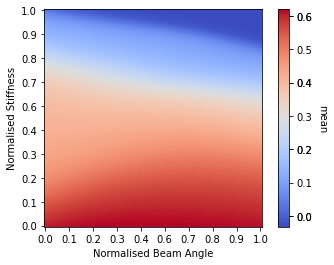

In [84]:
num_y_pts = num_d_pts = 100
fig = plotting_helpers.plot_amortised_phi(reverse_approx, y_lims, d_lims, num_y_pts, num_d_pts, 'mean')
fig.show()

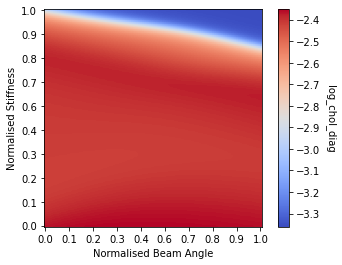

In [85]:
num_y_pts = num_d_pts = 100
fig = plotting_helpers.plot_amortised_phi(reverse_approx, y_lims, d_lims, num_y_pts, num_d_pts, 'log_chol_diag')
fig.show()

TypeError: cannot unpack non-iterable AxesSubplot object

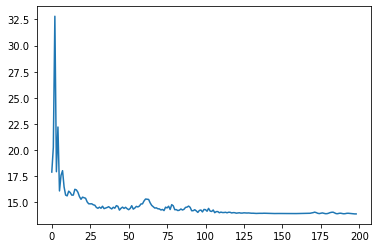

In [87]:
fig = plotting_helpers.plot_loss_history(reverse_loss)
fig.show()

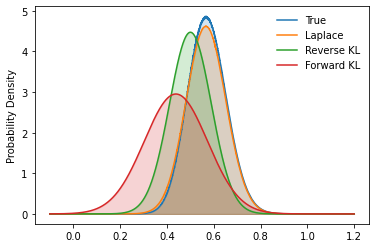

In [90]:
y = jnp.array([[0.3]])
d = jnp.array([[0.5]])
theta = jnp.linspace(-0.1, 1.2, 5000).reshape(-1,1)
true_posterior = computation_helpers.compute_true_log_posterior(model, noise_cov, prior_mean, prior_cov)
pdf_1 = true_posterior(theta, y, d)
pdf_2 = jnp.exp(laplace_approx.logpdf(theta, y, d)['logpdf'])
pdf_3 = jnp.exp(reverse_approx.logpdf(theta, x=y, d=d))
pdf_4 = jnp.exp(forward_approx.logpdf(theta, x=y, d=d))
plotting_helpers.plot_distributions(jnp.stack([pdf_1, pdf_2, pdf_3, pdf_4], axis=0), theta, 
                                    pdf_labels=['True', 'Laplace', 'Reverse KL', 'Forward KL'])

Create amortised inference posterior (Normal distribution):

In [5]:
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)

In [12]:
true_posterior = computation_helpers.compute_true_log_posterior(beam_model, noise_cov, prior_mean, prior_cov)
posterior = oed_toolbox.distributions.Posterior.from_jax_function(true_posterior)
ape_true = oed_toolbox.losses.APE(prior, likelihood, posterior, use_reparameterisation=True)
ape_vals = []
num_samples = 1000
for d_i in jnp.linspace(0,1,50):
    print(d_i)
    ape_vals.append(ape_true(d_i, num_samples, return_grad=False))

0.0
0.020408163
0.040816326
0.06122449
0.08163265
0.10204081
0.12244898
0.14285713
0.1632653
0.18367347
0.20408162
0.2244898
0.24489796
0.26530612
0.28571427
0.30612245
0.3265306
0.34693876
0.36734694
0.3877551
0.40816325
0.42857143
0.4489796
0.46938774
0.48979592
0.5102041
0.53061223
0.5510204
0.57142854
0.59183675
0.6122449
0.63265306
0.6530612
0.67346936
0.6938775
0.7142857
0.7346939
0.75510204
0.7755102
0.79591835
0.8163265
0.83673465
0.85714287
0.877551
0.8979592
0.9183673
0.9387755
0.95918363
0.97959185
1.0


<AxesSubplot:>

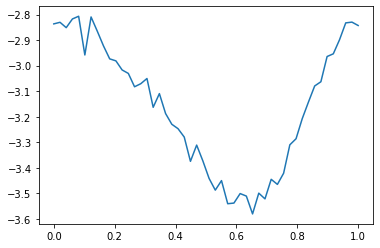

In [13]:
import numpy as np
sns.lineplot(x=np.linspace(0,1,50).squeeze(), y=-1*np.array([x for x in ape_vals]).squeeze())

In [14]:
minimizer = oed_toolbox.optim.gradient_descent_for_map()
ape_laplace = oed_toolbox.losses.APE.using_laplace_approximation(model, minimizer, prior_mean, \
                                                   prior_cov, noise_cov, use_reparameterisation=True)
ape_vals = []
num_samples=1000
for d_i in jnp.linspace(0,1,50):
    print(d_i)
    ape_vals.append(ape_laplace(d_i, num_samples))

NameError: name 'model' is not defined

<AxesSubplot:>

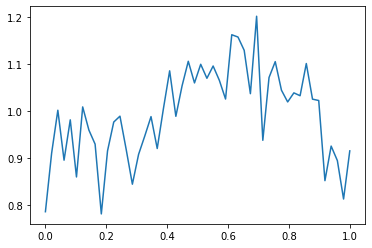

In [95]:
import numpy as np
sns.lineplot(x=np.linspace(0,1,50).squeeze(), y=-1*np.array([x[0] for x in ape_vals]).squeeze())

In [91]:
posterior = oed_toolbox.distributions.Posterior.from_approx_post(reverse_approx)
rev_ape = oed_toolbox.losses.APE(prior, likelihood, posterior, use_reparameterisation=True)

rev_ape_vals = []
num_samples=1000
for d_i in jnp.linspace(0,1,50):
    print(d_i)
    rev_ape_vals.append(rev_ape(d_i, num_samples))

0.0
0.020408163
0.040816326
0.06122449
0.08163265
0.10204081
0.12244898
0.14285713
0.1632653
0.18367347
0.20408162
0.2244898
0.24489796
0.26530612
0.28571427
0.30612245
0.3265306
0.34693876
0.36734694
0.3877551
0.40816325
0.42857143
0.4489796
0.46938774
0.48979592
0.5102041
0.53061223
0.5510204
0.57142854
0.59183675
0.6122449
0.63265306
0.6530612
0.67346936
0.6938775
0.7142857
0.7346939
0.75510204
0.7755102
0.79591835
0.8163265
0.83673465
0.85714287
0.877551
0.8979592
0.9183673
0.9387755
0.95918363
0.97959185
1.0


<AxesSubplot:>

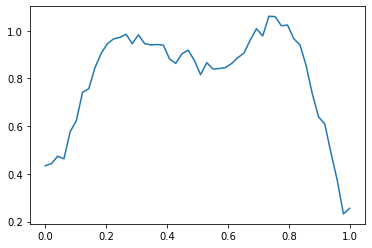

In [92]:
import numpy as np
sns.lineplot(x=np.linspace(0,1,50).squeeze(), y=np.array([x[0] for x in rev_ape_vals]).squeeze())

In [98]:
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(model, noise_cov)
posterior = oed_toolbox.distributions.Posterior.from_approx_post(forward_approx)
forw_ape = oed_toolbox.losses.APE(prior, likelihood, posterior, use_reparameterisation=True)

forw_ape_vals = []
num_samples=1000
for d_i in jnp.linspace(0,1,50):
    print(d_i)
    forw_ape_vals.append(forw_ape(d_i, num_samples))

0.0
0.020408163
0.040816326
0.06122449
0.08163265
0.10204081
0.12244898
0.14285713
0.1632653
0.18367347
0.20408162
0.2244898
0.24489796
0.26530612
0.28571427
0.30612245
0.3265306
0.34693876
0.36734694
0.3877551
0.40816325
0.42857143
0.4489796
0.46938774
0.48979592
0.5102041
0.53061223
0.5510204
0.57142854
0.59183675
0.6122449
0.63265306
0.6530612
0.67346936
0.6938775
0.7142857
0.7346939
0.75510204
0.7755102
0.79591835
0.8163265
0.83673465
0.85714287
0.877551
0.8979592
0.9183673
0.9387755
0.95918363
0.97959185
1.0


<AxesSubplot:>

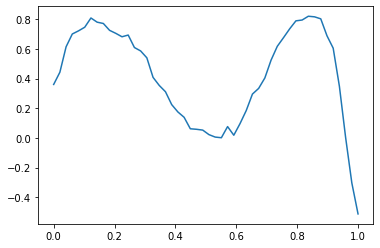

In [99]:
import numpy as np
sns.lineplot(x=np.linspace(0,1,50).squeeze(), y=np.array([x[0] for x in forw_ape_vals]).squeeze())

In [ ]:
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(model, noise_cov)
posterior = oed_toolbox.distributions.Posterior.from_approx_post(forward_approx)
ape = oed_toolbox.losses.APE(prior, likelihood, posterior)
adam = oed_toolbox.optim.adam_for_oed_loss(lr=1e-2)
d_0 = jnp.array([[0.5]])
num_samples = 100
rng = 19
adam(ape, d_0, num_samples, rng, verbose=True)

Create amortised inference posterior (Mixture distribution):

Let's see how the mean and covariance of the Laplace approximation and the amortised distribution change with the beam angle and design: